# CBSD Project - BF 5 dimensions of human personality
## OU - Salesperson Position (JIS)
### By: Derek Sweet, Marina Vicini, Emanuele Zangrando
* Object: 5 dimensions of human personality
* Number of Item: 10
* Likert Scale: 1-5
	- JIS: 230 (OU_df file)

Study Design: Within subject

Procedure: we conducted an experiment where participants were required to respond to the same questionnaire twice. First, they were asked to respond honestly to all of its questions. Then, we instructed them to fake their responses in the context of a Job Interview for a Salesperson Position (JIS), having the same subject responding in an honest condition and in one of instructed faking.

To sum up, participants were asked to respond to the same set of 10 items twice, first honestly and then altering their answers to obtain a personal gain in the context described before.

FAKING GOOD: we expect liars will give higher responses than truth-tellers because they have to appear in a better light.

## Imports and Data Load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import networkx as ntx
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import LeaveOneOut,cross_val_score,KFold,GridSearchCV,train_test_split,RandomizedSearchCV
from sklearn.covariance import GraphicalLassoCV,GraphicalLasso
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from numpy import mean
from numpy import absolute
from numpy import sqrt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import HeNormal

from sklearn.metrics import mean_squared_error

import keras

from numpy.random import default_rng
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

from tabulate import tabulate
from copy import deepcopy

In [ ]:
# For Derek (each person can add what they need to direct to the data)
os.chdir('/content/drive/MyDrive/UNIPD/Semester3/Social Data/CBSD Project')

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

Item: 
EX1G	EX2G	A1G	A2G	C1G	C2G	ES1G	ES2G	O1G	O2G

* EX = Extroversion scale
* A = Agreeableness scale
* C = Consciousness scale
* ES = Emotional stability scale 
* O = Openness scale

“I see myself as someone who ...”:
* EX1G - is outgoing, sociable (extroversion);
* EX2G - is reserved (extroversion reversed);
* A1G - tends to find fault with others (agreeableness, reversed);
* A2G - is generally trusting (agreeableness);
* C1G - tends to be lazy (consciousness, reversed)
* C2G - does a thorough job (consciousness);
* ES1G gets nervous easily (emotional stability, reversed);
* ES2G - is relaxed, handles stress well (emotional stability);
* O1G - has an active imagination (openness);
* O2G - has few artistic interests (openness, reversed).


In [ ]:
# Read data
df = pd.read_csv('BF_df_OU.csv')
df['CONDITION_BINARY'] = np.where(df['CONDITION']== 'H', 1, 0)

# Set variable names
input_variables = ['EX1G','EX2G','A1G','A2G','C1G','C2G','ES1G','ES2G','O1G','O2G']
input_labels = ['EX1G is outgoing',
                   'EX2G - is NOT reserved',
                   'A1G - NOT find faults',
                   'A2G - trusting',
                   'C1G - NOT lazy',
                   'C2G - thorough job',
                   'ES1G - NOT nervous',
                   'ES2G - relaxed',
                   'O1G - active imagination',
                   'O2G - NOT few art interest']
target_variable = 'CONDITION'
target_variable_binary = 'CONDITION_BINARY'

# Create X and y
X = df[input_variables].to_numpy()
y = df[target_variable_binary].to_numpy()
y = y.astype('int')
df

EX1G  EX2G  A1G  A2G  C1G  ...  ES2G  O1G  O2G  CONDITION  CONDITION_BINARY
0       3     2    3    3    4  ...     3    3    3          H                 1
1       4     4    4    4    5  ...     4    4    4          H                 1
2       4     2    2    4    4  ...     4    4    4          H                 1
3       4     3    2    4    4  ...     4    4    4          H                 1
4       5     3    3    1    5  ...     1    3    3          H                 1
..    ...   ...  ...  ...  ...  ...   ...  ...  ...        ...               ...
455     5     1    5    4    5  ...     4    5    4          D                 0
456     5     4    5    5    4  ...     4    5    4          D                 0
457     5     5    5    5    5  ...     3    5    5          D                 0
458     5     1    3    5    5  ...     5    5    5          D                 0
459     5     1    1    5    5  ...     5    5    4          D                 0

[460 rows x 12 columns]

In [ ]:
modelDf = pd.merge(df,df[df.CONDITION == 'H'], on = 'RESPONDENT', how = 'left')
# modelDf = modelDf[modelDf.CONDITION_x == 'D'].copy()
rows = int(len(modelDf)/2)
sample = round((rows*.20)/2.)*2
sample_index = int(sample/2)

rng = default_rng(1)
test_val_resp = rng.choice(rows, size=sample, replace=False)
test_resp = test_val_resp[:sample_index]
val_resp = test_val_resp[sample_index:]

trainDf = modelDf[~modelDf.RESPONDENT.isin(test_val_resp)]
testDf = modelDf[modelDf.RESPONDENT.isin(test_resp)]
valDf = modelDf[modelDf.RESPONDENT.isin(val_resp)]

y_hot = to_categorical(df.CONDITION_BINARY, num_classes = 2)
y_train_hot = to_categorical(trainDf.CONDITION_BINARY_x, num_classes = 2)
y_test_hot = to_categorical(testDf.CONDITION_BINARY_x, num_classes = 2)
y_val_hot = to_categorical(valDf.CONDITION_BINARY_x, num_classes = 2)

y = modelDf.CONDITION_BINARY_x
y_train = trainDf.CONDITION_BINARY_x
y_test = testDf.CONDITION_BINARY_x
y_val = valDf.CONDITION_BINARY_x


noise_columns = ['EX1G_x', 'EX2G_x', 'A1G_x', 'A2G_x', 'C1G_x', 
                 'C2G_x', 'ES1G_x', 'ES2G_x', 'O1G_x', 'O2G_x']
honest_columns = ['EX1G_y', 'EX2G_y', 'A1G_y', 'A2G_y', 'C1G_y', 
                  'C2G_y', 'ES1G_y', 'ES2G_y', 'O1G_y', 'O2G_y']

X_noise = modelDf[noise_columns].to_numpy()
X_train_noise = trainDf[noise_columns].to_numpy()
X_test_noise = testDf[noise_columns].to_numpy()
X_val_noise = valDf[noise_columns].to_numpy()

X_honest = modelDf[honest_columns].to_numpy()
X_train_honest = trainDf[honest_columns].to_numpy()
X_test_honest = testDf[honest_columns].to_numpy()
X_val_honest = valDf[honest_columns].to_numpy()

In [ ]:
# Reshape data to align repondents
# dfSS = pd.DataFrame(np.concatenate([X_noise,df.iloc[:,-3:]],axis=1),columns = df.columns)
reshapedDf = df.iloc[:,:-1].melt(id_vars=['CONDITION',	'RESPONDENT'], 
        var_name="QUESTION", 
        value_name="RESPONSE").pivot(index=['RESPONDENT','QUESTION'], 
                                     columns='CONDITION').reset_index()
reshapedDf.columns = ['RESPONDENT','QUESTION','D', 'H']
reshapedDf['D'] = reshapedDf['D'].astype('float')
reshapedDf['H'] = reshapedDf['H'].astype('float')
reshapedDf['EXPECTED DIRECTION'] = reshapedDf.D > reshapedDf.H
reshapedDf['UNEXPECTED DIRECTION'] = reshapedDf.D < reshapedDf.H
reshapedDf['UNCHANGED DIRECTION'] = reshapedDf.D == reshapedDf.H
reshapedDf

RESPONDENT QUESTION  ...  UNEXPECTED DIRECTION  UNCHANGED DIRECTION
0              1      A1G  ...                  True                False
1              1      A2G  ...                  True                False
2              1      C1G  ...                 False                False
3              1      C2G  ...                 False                False
4              1     ES1G  ...                 False                False
...          ...      ...  ...                   ...                  ...
2295         230     ES2G  ...                 False                 True
2296         230     EX1G  ...                 False                 True
2297         230     EX2G  ...                 False                 True
2298         230      O1G  ...                 False                False
2299         230      O2G  ...                 False                 True

[2300 rows x 7 columns]

## Useful functions 

In [ ]:
def confusion_tensor(X_H,X_pred,levels = 5):

  '''
  INPUT:
  X_H : matrix of honest questionnaires
  X_pred : matrix of reconstructed questionnaires
  levels : number of answer option for each question (suppose they are from 1 to levels)

  OUTPUT:
  conf_tens : tensor of shape (X_H.shape[0],X_H.shape[1],levels,levels) whose element T(n,q,i,j)
  is the confusion tensor for sample n
  mean_conf_tens : mean of all confusion tensors across the samples, the element P(q,i,j) is an estimator for
  P{ x_pred = j , x_H =i | question = q}.
  
  '''

  conf_tens = []

  for n in range(X_H.shape[0]):

    res = np.zeros(shape = (X_H.shape[1],levels,levels))

    for k in range(X_H.shape[1]):

      for i in range(levels):

        for j in range(levels):

          res[k,i,j] = int(X_H[n][k]==i+1 and X_pred[n][k]==j+1)

    conf_tens.append(res)

  conf_tens = np.array(conf_tens)
  mean_conf_tens = np.mean(conf_tens,axis = 0)

  return conf_tens, mean_conf_tens

## Descriptive Analysis

Overall Observations
* All responses have higher values when people respond dishonestly.
* Emotional Stability has the largest difference in honest and dishonest responses.
* Consciousness has a simliar response between honest and dishonest responses.

Extroversion Observation
* Honest resonses have a a slightly above average repsonse of "outgoing" and when faking for a salesperson interview they exaggerate they are extremely outgoing.
* Most people claim to be "reserved" in honest responses and fakers are less likley to say they are "reserved".

Agreeableness Observations
* Honest responses tend to "find fault" in people while dishonest respones trying to look like a good salesperson will claim to not "find fault" in people.
* Most people are neutral in "trust", but when pretending to be a salesperson they fake to be slightly more trusting.

Consciousness Observations
* People on average honestly claim to be "lazy" however they fake that they are not lazy when trying to do a job interview.
* Both honest and dishonest responses people resond that they do a a "thorough job".

Emotional Stability Observations
* People honestly respond they do get "nervous easily", but when faking they are a good salesperson they pretend they do not get nervous easily.
* Most people honestly respond they they are not "relaxed" and dont handle stress well. When trying to act as a salesperson they pretend to be highly relaxed and good at handling stress.

Openness Observations
* People have an average response to having and "active imagination" but when pretending to be a salesperson they exaggerate they they have a highly active imagination.
* People are neutral on "artistic interest" when answering honestly, but pretend to have high artistic interest when faking as a salesperson.

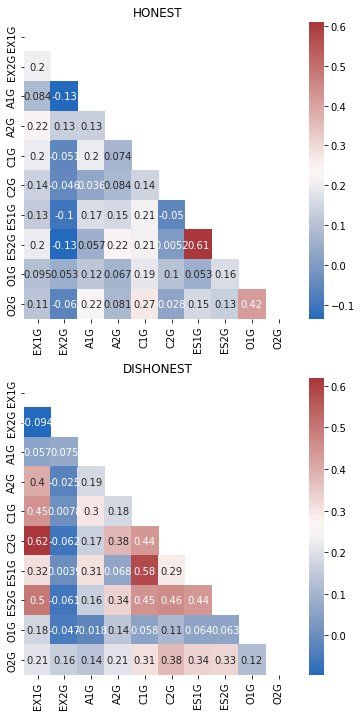

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(6,12))
current_palette = sns.color_palette("vlag", as_cmap=True)
corr_h = df[df.CONDITION=='H'].iloc[:,:-2].corr()
matrix_h = np.triu(corr_h)
hm = sns.heatmap(corr_h, annot = True,cmap=current_palette, mask = matrix_h, ax = ax1)
_ = ax1.set_title('HONEST')

corr_d = df[df.CONDITION=='D'].iloc[:,:-2].corr()
matrix_d = np.triu(corr_d)
hm = sns.heatmap(corr_d, annot = True,cmap=current_palette, mask = matrix_d, ax = ax2)
_ = ax2.set_title('DISHONEST')

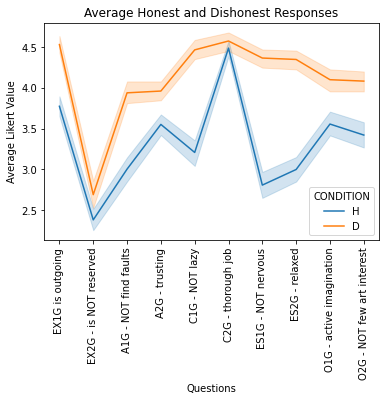

In [ ]:
visualDf = pd.melt(df, id_vars = ['CONDITION'],value_vars = input_variables)
_ = sns.lineplot(data=visualDf, x="variable", y="value", hue="CONDITION")
_.set_xticklabels(input_labels)
_.set_xlabel('Questions')
_.set_ylabel('Average Likert Value')
_.set_title('Average Honest and Dishonest Responses')
_ = plt.xticks(rotation=90)

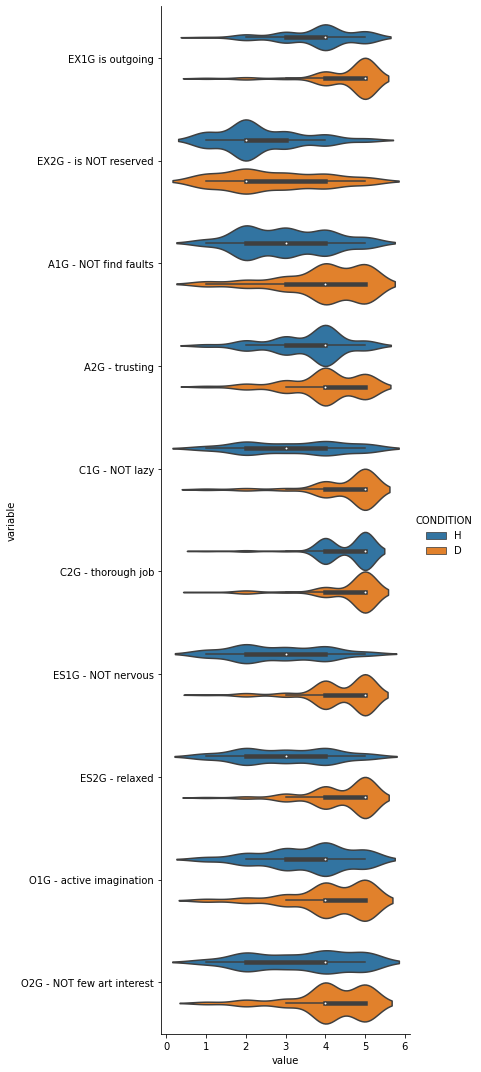

In [ ]:
_ = sns.catplot(x="value", y="variable", hue="CONDITION", data=visualDf, kind="violin", height = 15, aspect= .3)
_.set_yticklabels(input_labels)
# _ = plt.xticks(rotation=45)

## Benchmarks

In [ ]:
# Base model - Logistic Regression

cv = LeaveOneOut()

model = LogisticRegression(random_state=0)

scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

print(scores.mean())
print(scores.std())

0.8369565217391305
0.3694053362601397


Text(0.5, 1.0, 'Dishonest Minus Honest Average Response')

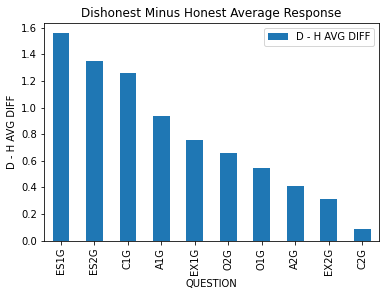

In [ ]:
diffDf = reshapedDf.groupby(['QUESTION']).mean()
# reshapedDf.info()
diffDf['D - H AVG DIFF'] =  diffDf.D-diffDf.H
_ = diffDf[['D - H AVG DIFF']].sort_values('D - H AVG DIFF',ascending=False).plot(kind = 'bar')
_.set_ylabel('D - H AVG DIFF')
_.set_title('Dishonest Minus Honest Average Response')

In [ ]:
def calculate_accuracy(X_pred,X_honest):
  # Converting predictions back to Likert scale
  pred_likert = np.round(X_pred)
  pred_likert[pred_likert > 5] = 5
  pred_likert[pred_likert < 1] = 1

  # Reconstruction accuracy by question
  X_accuracy = pred_likert == X_honest
  acc_by_question = np.sum(X_accuracy,axis=0)/len(X_accuracy)

  # Reconstruction accuracy total
  acc_total = np.sum(X_accuracy)/(10*len(X_accuracy))

  return acc_by_question,acc_total,pred_likert

X_bench = X_noise+diffDf['D - H AVG DIFF'].to_numpy()
bench_q, bench_t,_ = calculate_accuracy(X_bench, X_honest)
print(bench_q)
print(bench_t)

[0.22391304 0.68695652 0.12391304 0.67608696 0.17608696 0.55869565
 0.07391304 0.62173913 0.23043478 0.25869565]
0.3630434782608696


In [ ]:
x_bench = testDf.apply( lambda x: x[noise_columns] + diffDf['D - H AVG DIFF'].to_numpy() if x['CONDITION_x'] == 'D' else x[noise_columns], axis = 1)
mean_squared_error(x_bench,testDf[noise_columns])

0.41331947069943265

## Overall Discrimination

The first goal of the project is to be able to identify what questionnaire responses are honest or dishonest. To determine the best discrimination method to use, 10 different models were tested with 10 fold cross validation. Of the tested models: 

* 7 of them (LogReg, LDA, KNN, SVC, RF, XGB and MLP) took as input the ten questions 
* 1 of them (PolyLDA) took as input the polynomial interaction effects between the 10 questions (55 features in total)
* 2 of them (LR ES1G and LR PCA1) took as input a single feature for prediction

PolyLDA had the best accuracy tied with Random Forest and lowest variance. Given the interaction effects are difficult to interpret and only provide a small improvement over the simpler models, it is recommended to favor more interpretable models such as the Logistic regression. 

In [ ]:
df.loc[[1,2,3,4]]

EX1G  EX2G  A1G  A2G  C1G  ...  O1G  O2G  CONDITION  RESPONDENT  CONDITION_BINARY
1     4     4    4    4    5  ...    4    4          H           2                 1
2     4     2    2    4    4  ...    4    4          H           3                 1
3     4     3    2    4    4  ...    4    4          H           4                 1
4     5     3    3    1    5  ...    3    3          H           5                 1

[4 rows x 13 columns]

### Initializations for Discrimination

In [ ]:
def grid_search(model,model_name,params, X = X, y = y):
  '''
  Function to generalize the grid search process across models

  Parameters:
  - model: the sklearn initialized model before fitting with no parameters defined
  - params: a dictionary of parameters (key) and paramter values (value) to search

  Output:
  - gs_params: dictionary of the optimal parameters from grid search

  '''

  #Initalize grid search and fit it to X, y
  gs = GridSearchCV(model,param_grid=params,scoring='accuracy',cv=10)
  gs.fit(X, y)

  # Store, print, and return the best parameters
  print("{} Discrimination - Grid Search Results".format(model_name))
  gs_params = gs.best_params_
  print(gs_params)
  return gs_params

def model_cv_fit_eval(model,model_name, X2 = X, columns = input_variables):
  '''
  Function to generalize cross validation and evaluation outputs across models

  Parameters:
  - model: the sklearn initialized model before fitting with no parameters defined
  - model_name: the name of the model to be used in graphs
  - X2: The X inputs to the model (defaults to X)

  Output:
  - model_name: the name of the model
  - mean: the mean accuracy across the k folds
  - std: the standard deviation of accuracy across the k folds

  '''

  # Initialize lists for accuracy scores and confusion matricies across k folds
  scores = []
  conf_matrix_list_of_arrays = []

  pred_list = []
  y_list = []
  X_list = []
  tDf = []
  false_positives = []
  false_negatives = []

  i = 1

  # Create kfold cross validation to be used on all models
  kfold = KFold(n_splits=10, shuffle=True, random_state=0)

  # Loop through the k folds
  for train_index, test_index in kfold.split(X, y):

    # Split test and train based on k fold
    X_train, X_test = X2[train_index], X2[test_index]
    y_train, y_test = y[train_index], y[test_index]

    tDf_temp = df.loc[test_index,:]
    tDf_temp['fold'] = i
    tDf.append(tDf_temp)

    # Fit model
    model.fit(X_train, y_train)

    # Make prediction of test data and append to list
    pred = model.predict(X_test)
    pred_list.extend(pred)
    y_list.extend(y_test)
    X_list.append(X_test)

    # Generate confusion matrix and append to conf_matrix_list_of_arrays
    conf_matrix = confusion_matrix(y_test, pred)
    conf_matrix_list_of_arrays.append(conf_matrix)

    # Generate accuracy score and append to scores
    scores.append(accuracy_score(y_test, pred))

    i+=1

  # Average of all the confusion matricies across kfolds
  mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)

  # Average and stdev of all the kfold accuracy scores
  mean = np.mean(scores)
  std = np.std(scores)

  # Turn prediction a y_test lists into dataframe
  X_list = np.concatenate(X_list)
  # X_list = StandardScaler().fit_transform(np.concatenate(X_list))
  predsDf = pd.DataFrame(X_list, columns = columns)
  predsDf['pred'] = pred_list
  predsDf['y'] = y_list

  tDf = pd.concat(tDf)

  tDf['pred'] = pred_list
  tDf['y'] = y_list

  # Print results
  print("{} Discrimination - Cross Validation Results".format(model_name))
  print('Mean Accuracy {}%'.format(round(mean*100,2)))
  print('STD Accuracy {}%'.format(round(std*100,2)))

  # Display confusion matrix
  disp = ConfusionMatrixDisplay(confusion_matrix=mean_of_conf_matrix_arrays)
  disp.plot()
  plt.show()

  return model_name, mean, std, predsDf, tDf

In [ ]:
# Initialize lists to store kfold performance by model
models_accuracy = []
models_std = []

kfold = KFold(n_splits=10, shuffle=True, random_state=0)

### Logistic Regression

LogReg Discrimination - Cross Validation Results
Mean Accuracy 83.04%
STD Accuracy 4.64%


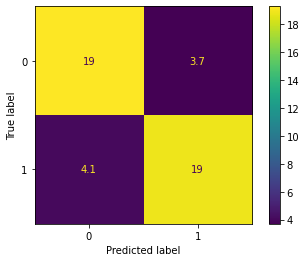

In [ ]:
# Logistic Regression Discrimination
from sklearn.linear_model import LogisticRegression

# Initialize model and model_name
model = LogisticRegression(random_state=0)
model_name = 'LogReg'

# Run cross validation, output evaluation metrics and append accuracy to list
lr_results = model_cv_fit_eval(model,model_name)
models_accuracy.append(lr_results[0:3])

### Linear Discriminant Analysis

LDA Discrimination - Cross Validation Results
Mean Accuracy 82.83%
STD Accuracy 5.19%


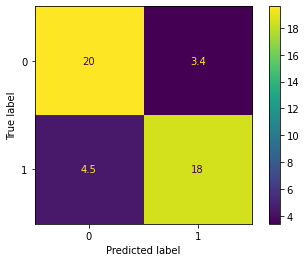

In [ ]:
# LDA Discrimination
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Initialize model and model_name
model = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
model_name = 'LDA'

# Run cross validation, output evaluation metrics and append accuracy to list
lda_results = model_cv_fit_eval(model,model_name)
models_accuracy.append(lda_results[0:3])

### Polynomial Linear Discriminant Analysis

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = X.copy()
X_poly = poly.fit_transform(X_poly)

poly_variables = poly.get_feature_names_out(input_variables)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_poly = scaler.fit_transform(X_poly)

PolyLDA Discrimination - Cross Validation Results
Mean Accuracy 84.57%
STD Accuracy 3.94%


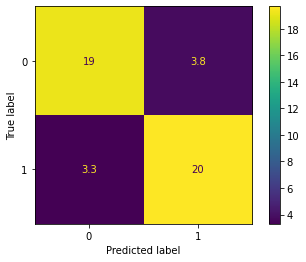

In [ ]:
# LDA Discrimination
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Initialize model and model_name
model = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
model_name = 'PolyLDA'

# Run cross validation, output evaluation metrics and append accuracy to list
poly_lda_results = model_cv_fit_eval(model,model_name,X2 = X_poly, columns = poly_variables)
models_accuracy.append(poly_lda_results[0:3])

### Polynomial Lasso linear regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
poly = PolynomialFeatures(degree = 2,interaction_only=True,include_bias=False)
X_poly = X.copy()
X_poly = poly.fit_transform(X_poly)

poly_variables = poly.get_feature_names_out(input_variables)
ss = StandardScaler()
ss.fit(X_poly)
X_poly = ss.fit_transform(X_poly)

lr_poly Discrimination - Cross Validation Results
Mean Accuracy 82.83%
STD Accuracy 3.43%


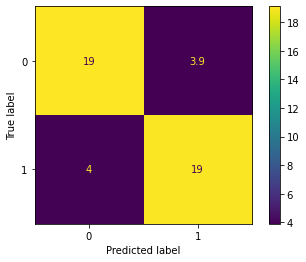

In [ ]:
# Cross validation to choose penalization and elastic net parameters, takes a while

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings("ignore")

#lr_lasso = LogisticRegression(penalty='elasticnet',C = 0.001,l1_ratio = 1,solver = 'saga')
lr_lasso  = LogisticRegressionCV(Cs = 100,penalty='elasticnet',l1_ratios = np.arange(0.5,1,0.2),solver = 'saga')
lr_lasso.fit(X_poly,y)
model = lr_lasso

poly_lr_results = model_cv_fit_eval(model,model_name = 'lr_poly',X2 = X_poly, columns = poly_variables)
models_accuracy.append(poly_lr_results[0:3])

lambda: 1000.0


selected variables: 

[]

lambda: 911.1627561154896


selected variables: 

[]

lambda: 830.2175681319744


selected variables: 

[]

lambda: 756.4633275546291


selected variables: 

[]

lambda: 689.2612104349695


selected variables: 

[]

lambda: 628.0291441834253


selected variables: 

[]

lambda: 572.236765935022


selected variables: 

[]

lambda: 521.4008287999685


selected variables: 

[]

lambda: 475.08101621027976


selected variables: 

[]

lambda: 432.8761281083057


selected variables: 

[]

lambda: 394.4206059437656


selected variables: 

[]

lambda: 359.38136638046257


selected variables: 

[]

lambda: 327.45491628777285


selected variables: 

[]

lambda: 298.364724028334


selected variables: 

[]

lambda: 271.85882427329403


selected variables: 

[]

lambda: 247.70763559917117


selected variables: 

[]

lambda: 225.7019719633919


selected variables: 

[]

lambda: 205.65123083486515


selected variables: 

[]

lambda: 187.3817422860383


selecte

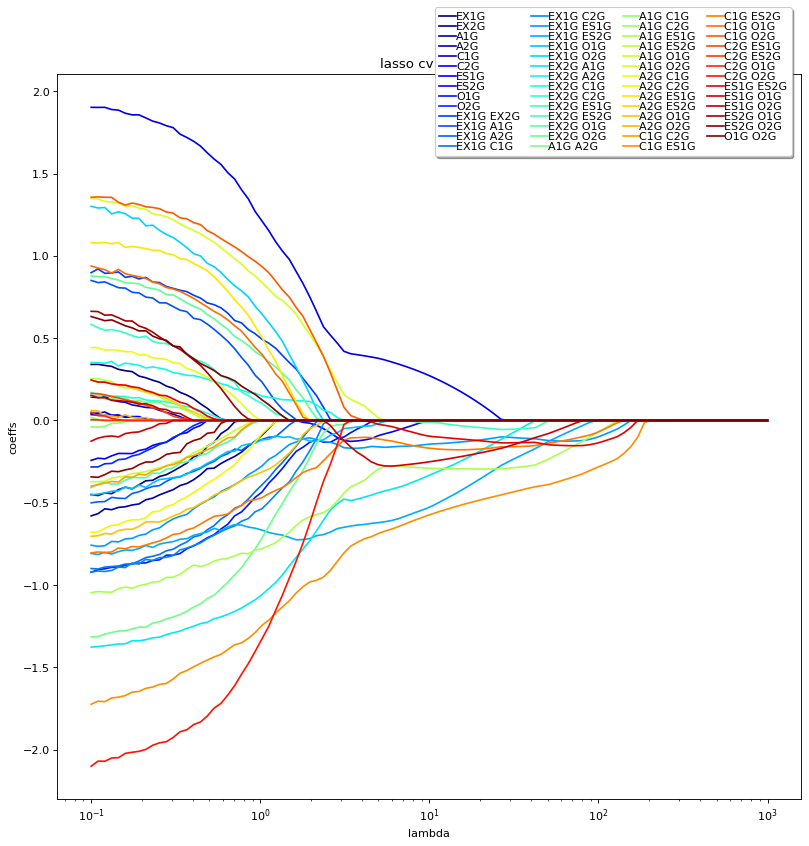

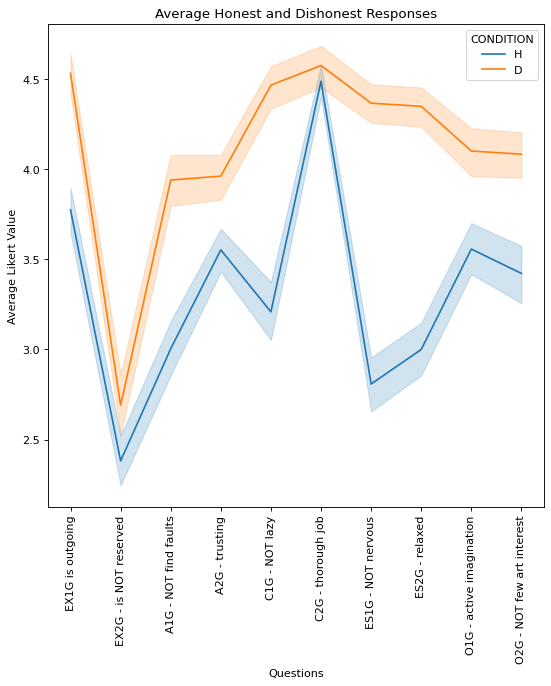

In [ ]:
# print results if needed, lasso filtration of importance for interaction variables
# the same plot can be done for the raw variables just by re-reunning this whole section with
# degree = 1 in the interaction of the polynomial features

n_alphas = 100
alphas = np.logspace(-3, 1, n_alphas)

coefs = []
for a in alphas:
    lasso = LogisticRegression(C = a,penalty = 'elasticnet',solver = 'saga',l1_ratio = 0.8)
    lasso.fit(X_poly, y)
    coefs.append(lasso.coef_[0])
    print('lambda:',1/a)
    print('\n')
    print('selected variables: \n')
    print(poly_variables[ np.where(lasso.coef_[0] != 0)  ])
    print('\n==================================================================================')

# #############################################################################
# Display results

coefs = np.array(coefs)

plt.figure(figsize=(12,12),dpi = 80)
colormap = plt.cm.gist_ncar
ax = plt.gca()
ax.set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, len(poly_variables)))))

ax.plot(1/alphas, coefs)
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim(ax.get_xlim()[::1])  # reverse axis
plt.xlabel('lambda')
plt.ylabel('coeffs')
plt.title('lasso cv coeffs')
plt.axis('tight')
plt.legend(poly_variables, ncol=4, loc='upper rights', 
           bbox_to_anchor=[0.5, 1.1], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=True, shadow=True)
plt.show()


plt.figure(figsize=(8,8),dpi = 80)
visualDf = pd.melt(df, id_vars = ['CONDITION'],value_vars = input_variables)
_ = sns.lineplot(data=visualDf, x="variable", y="value", hue="CONDITION")
_.set_xticklabels(input_labels)
_.set_xlabel('Questions')
_.set_ylabel('Average Likert Value')
_.set_title('Average Honest and Dishonest Responses')
_ = plt.xticks(rotation=90)

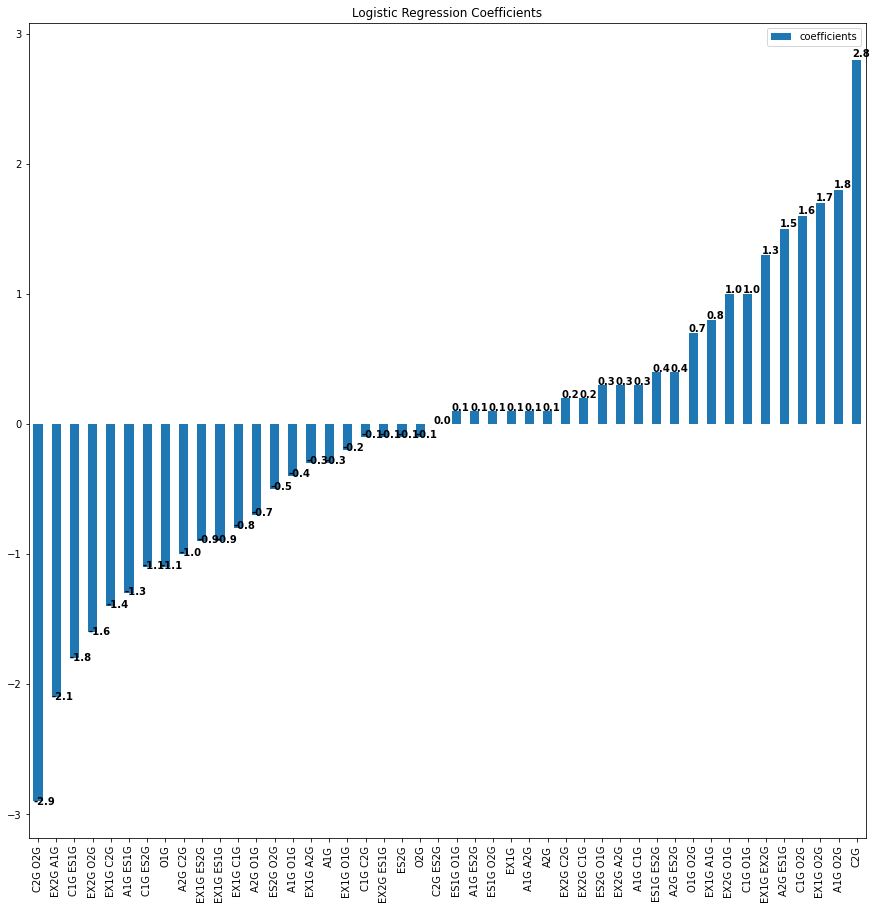

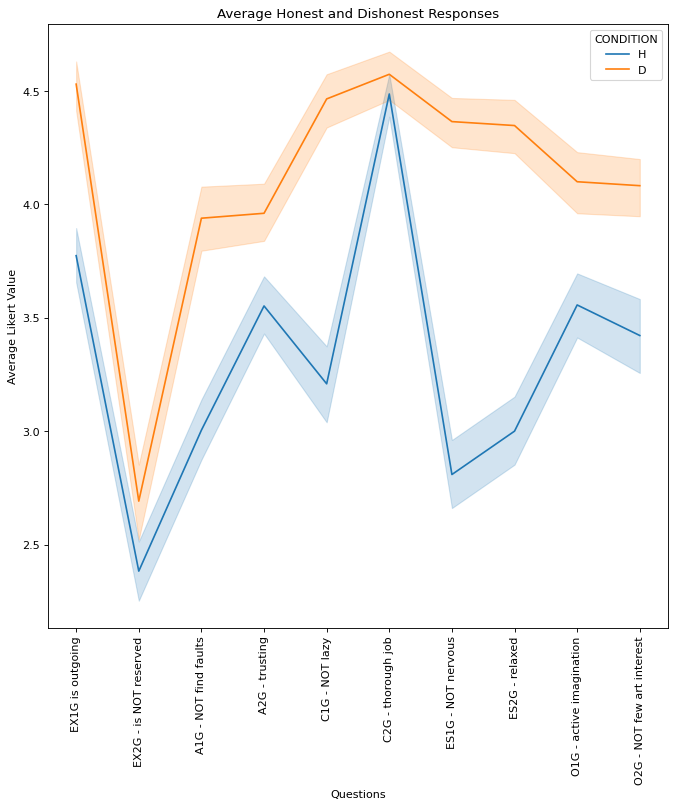

In [ ]:
df_lr_lasso = pd.DataFrame( lr_lasso.coef_,columns = poly_variables )
non_zero_coeffs = np.array( [model.coef_[0,i]  for i in range(model.coef_.shape[1]) if model.coef_[0,i]!=0. ]  )
non_zero_poly_variables = np.array( [np.array([poly_variables])[0,i] for i in range(model.coef_.shape[1]) if model.coef_[0,i]!=0. ]  ) 

# Make DF for plot
coefDf = pd.DataFrame({'coefficients':np.round(non_zero_coeffs,1)}, index = non_zero_poly_variables)

ax = coefDf.sort_values('coefficients').plot(kind='bar',figsize = (15,15))

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1, p.get_height() * 1.01),weight = 'bold')

ax.set_title('Logistic Regression Coefficients')
plt.show()

plt.figure(figsize=(10,10),dpi = 80)   # good to have a reference near
visualDf = pd.melt(df, id_vars = ['CONDITION'],value_vars = input_variables)
_ = sns.lineplot(data=visualDf, x="variable", y="value", hue="CONDITION")
_.set_xticklabels(input_labels)
_.set_xlabel('Questions')
_.set_ylabel('Average Likert Value')
_.set_title('Average Honest and Dishonest Responses')
_ = plt.xticks(rotation=90)

### K-Nearest Neighbors

KNN Discrimination - Grid Search Results
{'n_neighbors': 5, 'weights': 'uniform'}
KNN Discrimination - Cross Validation Results
Mean Accuracy 82.83%
STD Accuracy 4.06%


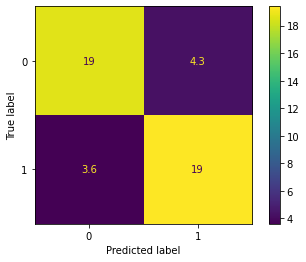

In [ ]:
# KNN Discrimination
from sklearn.neighbors import KNeighborsClassifier

# Initialize dictionary of parameters to search
params = [{'n_neighbors': [3, 5, 7, 9],
         'weights': ['uniform', 'distance']}]
model_name = 'KNN'

# Run grid search
model = KNeighborsClassifier()
gs_params = grid_search(model,model_name,params)

# Initialize optimal model and model_name
model = KNeighborsClassifier(n_neighbors=gs_params['n_neighbors'], weights=gs_params['weights'])


# Run cross validation, output evaluation metrics and append accuracy to list
knn_results = model_cv_fit_eval(model,model_name)
models_accuracy.append(knn_results[0:3])

### Support Vector Classification

SVC Discrimination - Cross Validation Results
Mean Accuracy 84.13%
STD Accuracy 4.57%


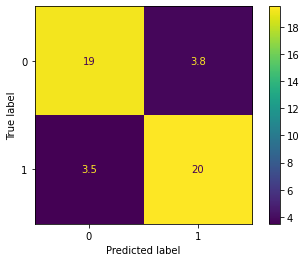

In [ ]:
# SVC Discrimination
from sklearn.svm import SVC

# Initialize optimal model and model_name
model = SVC(gamma='auto')
model_name = 'SVC'

# Run cross validation, output evaluation metrics and append accuracy to list
svc_results = model_cv_fit_eval(model,model_name)
models_accuracy.append(svc_results[0:3])

### Random Forest

RF Discrimination - Grid Search Results
{'max_depth': 4}
RF Discrimination - Cross Validation Results
Mean Accuracy 85.22%
STD Accuracy 4.94%


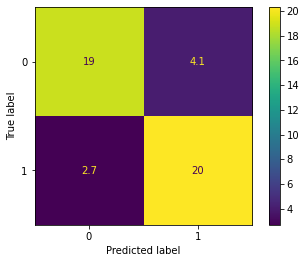

In [ ]:
# Random Forest Discrimination
from sklearn.ensemble import RandomForestClassifier

# Initialize dictionary of parameters to search
params = [{'max_depth': [3,4,5,6,7,8,9]}]
model_name = 'RF'

# Run grid search
model = RandomForestClassifier(random_state=0)
gs_params = grid_search(model,model_name,params)

# Initialize optimal model and model_name
model = RandomForestClassifier(max_depth=gs_params['max_depth'],random_state=0)


# Run cross validation, output evaluation metrics and append accuracy to list
rf_results = model_cv_fit_eval(model,model_name)
models_accuracy.append(rf_results[0:3])

### XGBoost

XGB Discrimination - Grid Search Results
{'max_depth': 5, 'n_estimators': 200}
XGB Discrimination - Cross Validation Results
Mean Accuracy 83.26%
STD Accuracy 5.33%


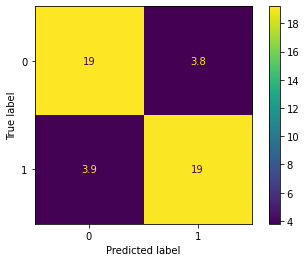

In [ ]:
# XGBoost Discrimination
from xgboost import XGBClassifier

# Initialize dictionary of parameters to search
params = [{'max_depth': [3,4,5,6,7,8,9], 'n_estimators': [100,200,300]}]
model_name = 'XGB'

# Run grid search
model = XGBClassifier(random_state=0)
gs_params = grid_search(model,model_name,params)

# Initialize optimal model and model_name
model = XGBClassifier(n_estimators=gs_params['n_estimators'],max_depth=gs_params['max_depth'],random_state=0)

# Run cross validation, output evaluation metrics and append accuracy to list
xgb_results = model_cv_fit_eval(model,model_name)
models_accuracy.append(xgb_results[0:3])

### Multi-Layer Perceptron

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/300
26/26 [==============================] - 1s 8ms/step - loss: 1.5776 - accuracy: 0.5048 - val_loss: 0.8373 - val_accuracy: 0.3478
Epoch 2/300
26/26 [==============================] - 0s 2ms/step - loss: 1.2426 - accuracy: 0.4734 - val_loss: 0.8093 - val_accuracy: 0.3478
Epoch 3/300
26/26 [==============================] - 0s 2ms/step - loss: 1.1404 - accuracy: 0.4976 - val_loss: 0.7403 - val_accuracy: 0.4783
Epoch 4/300
26/26 [==============================] - 0s 2ms/step - loss: 1.0182 - accuracy: 0.5580 - val_loss: 0.6980 - val_accuracy: 0.6087
Epoch 5/300
26/26 [==============================] - 0s 2ms/step - loss: 1.0807 - accuracy: 0.5121 - val_loss: 0.6845 - val_accuracy: 0.5652
Epoch 6/300
26/26 [==============================] - 0s 3ms/step - loss: 0.9162 - accuracy: 0.5580 - val_loss: 0.6488 - val_accuracy: 0.6087
Epoch 7/300
26/26 [==============================] - 0s 2

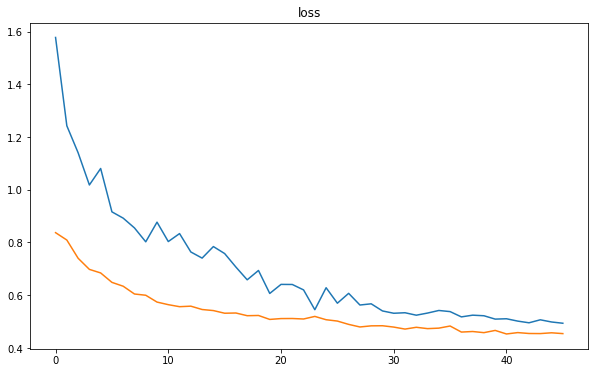

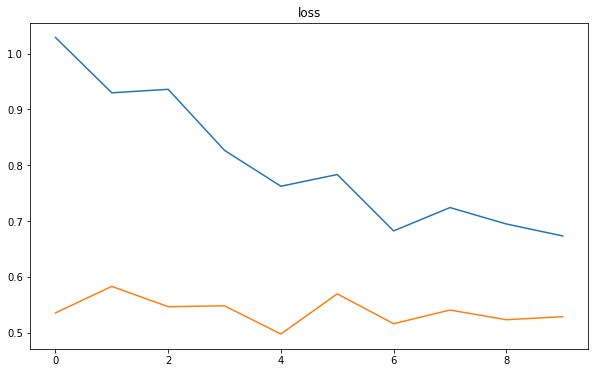

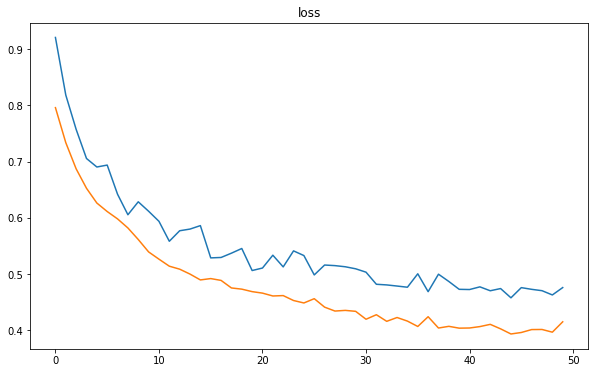

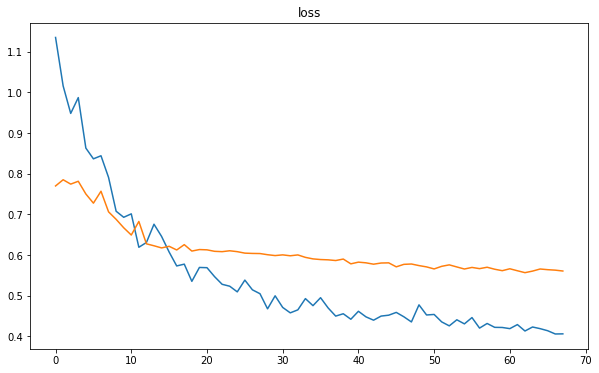

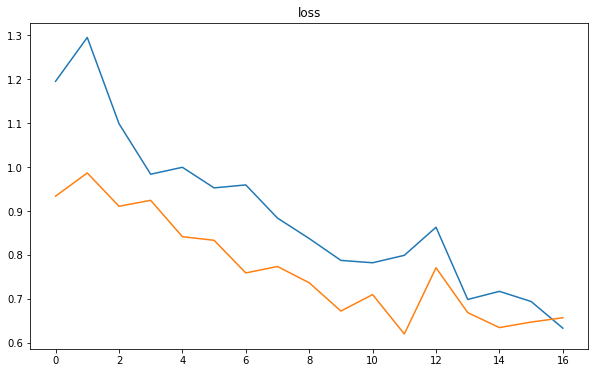

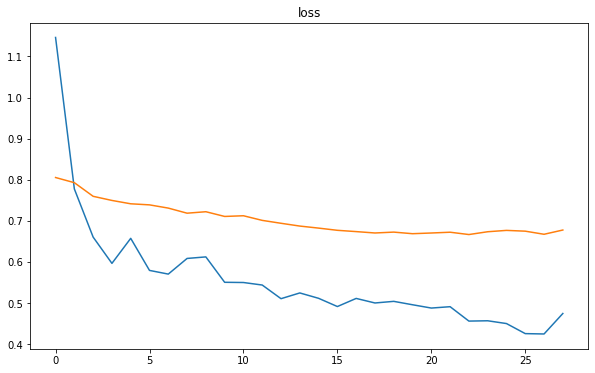

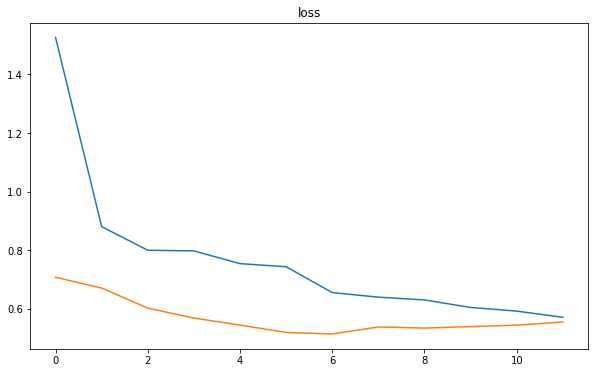

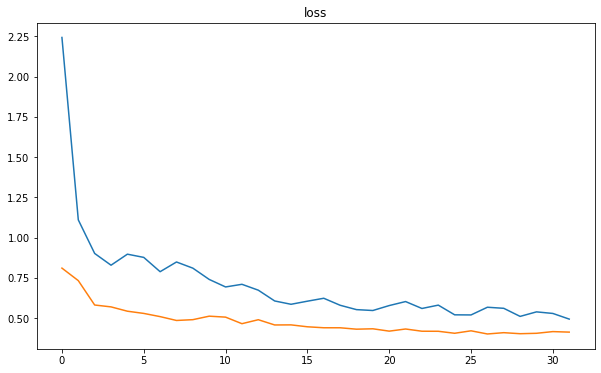

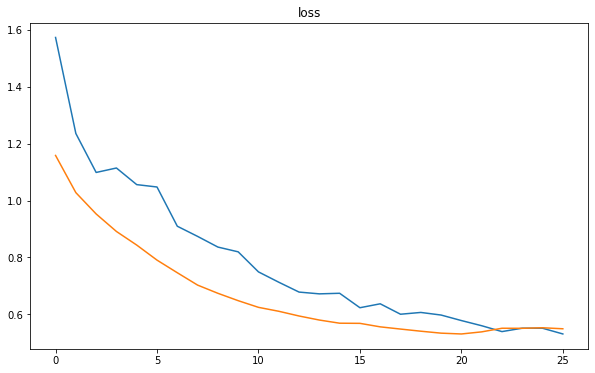

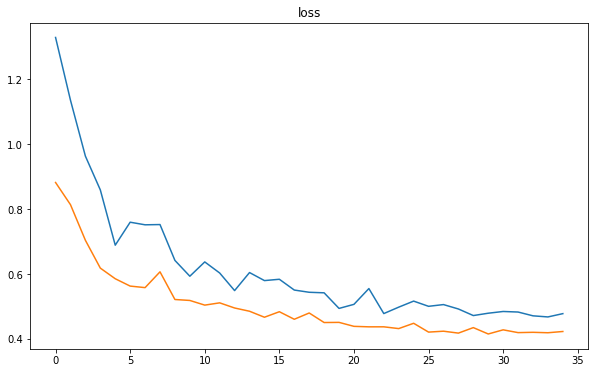

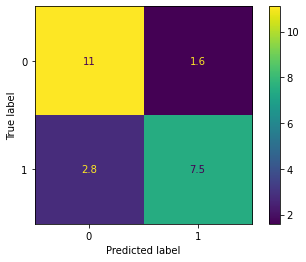

In [ ]:
# MLP Discrimination
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import HeNormal
from sklearn.preprocessing import StandardScaler

# Initialize lists
scores = []
loss_per_fold = []
conf_matrix_list_of_arrays = []

# Loop through k folds
fold_no = 1
for train_index, test_index in kfold.split(X, y):

  # Define the model architecture
  model = Sequential()
  model.add(Dense(32, activation='relu', kernel_initializer = HeNormal()))
  model.add(Dropout(0.1))
  model.add(Dense(1, activation='sigmoid'))

  # Compile the model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Further split test into test and val for early stopping and learning curves
  np.random.shuffle(test_index)
  idx = round(len(test_index)/2)
  val_index = test_index[:idx]
  test_index2 = test_index[idx:]

  X_train_, X_test_, X_val_ = X[train_index], X[test_index2], X[val_index]
  y_train_, y_test_, y_val_ = y[train_index], y[test_index2], y[val_index]

  # ss = StandardScaler()
  # X_train_ = ss.fit_transform(X_train_)
  # X_test_ = ss.transform(X_test_)
  # X_val_ = ss.transform(X_val_)

  # Create early stopping callback
  callback = EarlyStopping(monitor='val_loss', patience=5)

  # Fit data to model
  history = model.fit(X_train_, y_train_,
              batch_size=16,
              epochs=300,
              callbacks = [callback],
              validation_data=(X_val_, y_val_)
              )
  
  # Plot the learning curves
  plot_loss(history)

  # Print evaluation metrics
  score = model.evaluate(X_test_, y_test_, verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {score[0]}; {model.metrics_names[1]} of {score[1]*100}%')

  # Append accuracy and lost to lists
  scores.append(score[1])
  loss_per_fold.append(score[0])

  # Create confusion matrix and append to list conf_matrix_list_of_arrays
  preds = model.predict(X_test_)
  pred_class = (preds > 0.5).astype('int')
  conf_matrix = confusion_matrix(y_test_, pred_class)
  print(conf_matrix)
  conf_matrix_list_of_arrays.append(conf_matrix)

  # Increase fold number
  fold_no = fold_no + 1

# Get mean and stdev of kfold accuracy
mlp_mean = np.array(scores).mean()
mlp_std = np.array(scores).std()

# Print evaluation metrics
print("MLP Discrimination")
print("Cross Validation Results")
print('Mean Accuracy {}%'.format(round(mlp_mean*100,2)))
print('STD Accuracy {}%'.format(round(mlp_std*100,2)))

# Average confusion matricies and display plot
mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=mean_of_conf_matrix_arrays)
disp.plot()
plt.show()

# Append final scores to models_accuracy list
models_accuracy.append(('MLP',mlp_mean,mlp_std))

### Ensemble Method

In [ ]:
# Ensemble Accuracy
results = [lr_results, lda_results, poly_lda_results, knn_results, svc_results, rf_results, xgb_results]
results_label = ['lr_pred', 'lda_pred', 'poly_lda_pred', 'knn_pred', 'svc_pred', 'rf_pred', 'xgb_pred']

result_list = []

for result in results:
  predDf = result[4]
  predDf.index = predDf.RESPONDENT
  result_list.append(predDf['pred'])

respondent_preds = pd.concat(result_list, axis=1)
respondent_preds.columns = results_label
respondent_preds['ensemble_count'] = respondent_preds.sum(axis=1)
respondent_preds['ensemble_pred'] = (respondent_preds.ensemble_count>=4).astype('int')
respondent_preds['fold'] = lr_results[4]['fold']
respondent_preds['y'] = lr_results[4]['y']
respondent_preds['is_accurate'] = respondent_preds.ensemble_pred == respondent_preds.y
ensemble_accuracy = respondent_preds.groupby('fold').agg({"is_accurate": [np.sum, len]})
ensemble_accuracy
ensemble_accuracy.columns = ['sum','len']

# Append final scores to models_accuracy list
ensemble_mean = np.mean((ensemble_accuracy['sum']/ensemble_accuracy['len']))
ensemble_std = np.std((ensemble_accuracy['sum']/ensemble_accuracy['len']))
models_accuracy.append(('Ensemble',ensemble_mean,ensemble_std))


In [ ]:
respondent_preds.to_csv('BF_df_OU_preds.csv')

### Logistic Regression Interpretation

Text(0.5, 1.0, 'Logistic Regression Coefficients')

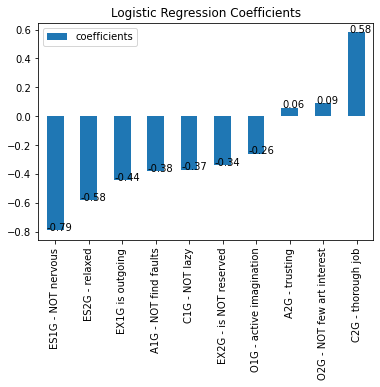

In [ ]:
# Instantiate model and fit
model = LogisticRegression()
model.fit(X, y)

# Make DF for plot
coefDf = pd.DataFrame({'coefficients':np.round(model.coef_[0],2)}, index = input_labels)

# Make plot
ax = coefDf.sort_values('coefficients').plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

ax.set_title('Logistic Regression Coefficients')

In [ ]:
# Changes in Expected Direction
direction = 'EXPECTED DIRECTION'
missclassified_respondents = respondent_preds[respondent_preds.lr_pred != respondent_preds.y].index.unique().to_list()
print("Average Questions Changed in {}".format(direction))
print("Misclassified:",reshapedDf[reshapedDf.RESPONDENT.isin(missclassified_respondents)].groupby(
    'RESPONDENT').sum()[direction].mean())
print("OVERALL:",reshapedDf.groupby('RESPONDENT').sum()[direction].mean())

Average Questions Changed in EXPECTED DIRECTION
Misclassified: 3.2972972972972974
OVERALL: 5.21304347826087


In [ ]:
# Changes in Unexpected Direction
direction = 'UNEXPECTED DIRECTION'
missclassified_respondents = respondent_preds[respondent_preds.lr_pred != respondent_preds.y].index.unique().to_list()
print("Average Questions Changed in {}".format(direction))
print("Misclassified:",reshapedDf[reshapedDf.RESPONDENT.isin(missclassified_respondents)].groupby(
    'RESPONDENT').sum()[direction].mean())
print("OVERALL:",reshapedDf.groupby('RESPONDENT').sum()[direction].mean())

Average Questions Changed in UNEXPECTED DIRECTION
Misclassified: 1.7837837837837838
OVERALL: 1.2565217391304349


In [ ]:
# Changes in Unchanged Direction
direction = 'UNCHANGED DIRECTION'
missclassified_respondents = respondent_preds[respondent_preds.lr_pred != respondent_preds.y].index.unique().to_list()
print("Average Questions Changed in {}".format(direction))
print("Misclassified:",reshapedDf[reshapedDf.RESPONDENT.isin(missclassified_respondents)].groupby(
    'RESPONDENT').sum()[direction].mean())
print("OVERALL:",reshapedDf.groupby('RESPONDENT').sum()[direction].mean())

Average Questions Changed in UNCHANGED DIRECTION
Misclassified: 4.918918918918919
OVERALL: 3.5304347826086957


Text(0.5, 1.0, 'XGBoost Feature Importances')

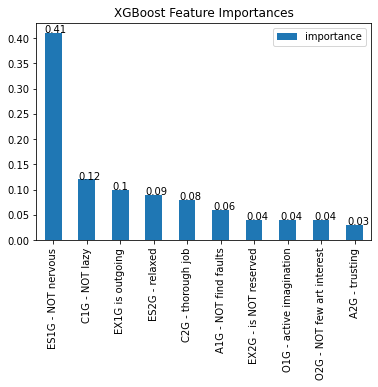

In [ ]:
# XGBoost Discrimination Interpretation
from xgboost import XGBClassifier
model = XGBClassifier()

# Fit model
model.fit(X, y)

# Make DF for plot
coefDf = pd.DataFrame({'importance':np.round(model.feature_importances_,2)}, index = input_labels)

# Make plot
ax = coefDf.sort_values('importance', ascending=False).plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(np.round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))

ax.set_title('XGBoost Feature Importances')

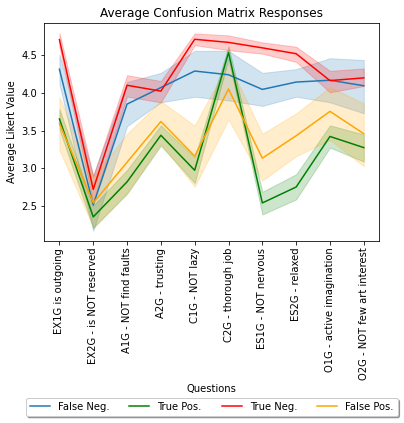

In [ ]:
# Plot the 
predDf = lr_results[3]

# Classify prediction into confusion classifications
predDf['CONFUSION_CLASS'] = np.where(
     (predDf['pred'] == 1) & (predDf['y'] == 1), 
    'True Pos.', 
     np.where(
        (predDf['pred'] == 0) & (predDf['y'] == 0), 'True Neg.',
        np.where(
          (predDf['pred'] == 1) & (predDf['y'] == 0), 'False Pos.', 'False Neg.'
        )
     )
)

# Plot a line for each confusion classification
visualDf = pd.melt(predDf, id_vars = ['CONFUSION_CLASS'],value_vars = input_variables)
_ = sns.lineplot(data=visualDf, x="variable", y="value", hue="CONFUSION_CLASS",
                 palette=["C0", "g", "r", "orange"])
_.set_xticklabels(input_labels)
_.set_xlabel('Questions')
_.set_ylabel('Average Likert Value')
_.set_title('Average Confusion Matrix Responses')
_ = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -.7),
          fancybox=True, shadow=True, ncol=5)
_ = plt.xticks(rotation=90)

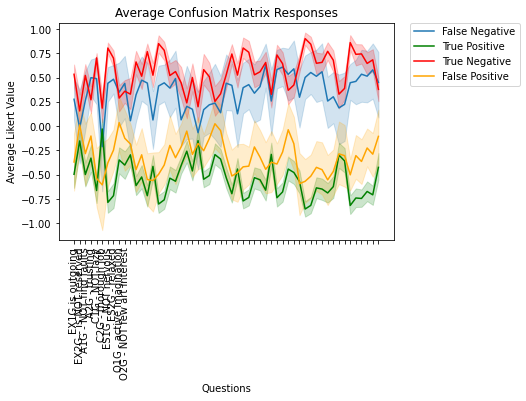

In [ ]:
# Plot the cofusion matrix responses among interaction effects

# Transform data for plot
predDf = poly_lda_results[3]
predDf['CONFUSION_CLASS'] = np.where(
     (predDf['pred'] == 1) & (predDf['y'] == 1), 
    'True Positive', 
     np.where(
        (predDf['pred'] == 0) & (predDf['y'] == 0), 'True Negative',
        np.where(
          (predDf['pred'] == 1) & (predDf['y'] == 0), 'False Positive', 'False Negative'
        )
     )
)

# Visualize
visualDf = pd.melt(predDf, id_vars = ['CONFUSION_CLASS'],value_vars = poly_variables)
_ = sns.lineplot(data=visualDf, x="variable", y="value", hue="CONFUSION_CLASS",
                 palette=["C0", "g", "r", "orange"])
_.set_xticklabels(input_labels)
_.set_xlabel('Questions')
_.set_ylabel('Average Likert Value')
_.set_title('Average Confusion Matrix Responses')
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
_ = plt.xticks(rotation=90)

### Logistic Regression with Feature Selection

In [ ]:
# Logistic Regression with Feature Selection Discrimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Initialize model
estimator = LogisticRegression(random_state=0)

# Initalize fit and print RFE to select best features for model prediction
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X, y)
print(selector.support_)

# Create new input X with only the selected features
X_selector = X[:,selector.support_]

# Fit model on new X
model = LogisticRegression(random_state=0)
model.fit(X_selector,y)

# Display coefficients of selected features
pd.DataFrame({'variable':np.array(input_variables)[selector.support_],'coef':model.coef_[0]})

[False False False False  True False  True  True False False]


variable      coef
0      C1G -0.476104
1     ES1G -0.869726
2     ES2G -0.521188

### PCA Analysis

Eigenvalues:
[3.46223117 1.10536672 1.0424274  0.98250408 0.7965154  0.77899891
 0.62279535 0.5017655  0.460571   0.26861096]

Variances (Percentage):
[34.54704581 11.02963747 10.40161255  9.80368206  7.94783846  7.77305437
  6.21441449  5.00674703  4.59569755  2.68027022]



Text(0.5, 1.0, 'PCA')

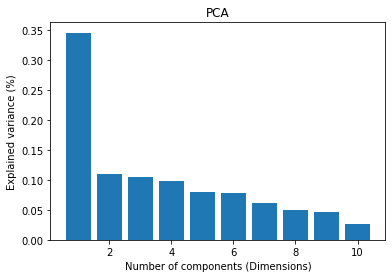

In [ ]:
# Do feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=None)
pca.fit(X_scaled)

# Get the eigenvalues
print("Eigenvalues:")
print(pca.explained_variance_)
print()

# Get explained variances
print("Variances (Percentage):")
print(pca.explained_variance_ratio_ * 100)
print()

# Make the scree plot
plt.bar(range(1,11),pca.explained_variance_ratio_)
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")
plt.title('PCA')

### Logistic Regression (only ES1G)

LR ES1G Discrimination - Cross Validation Results
Mean Accuracy 78.48%
STD Accuracy 5.0%


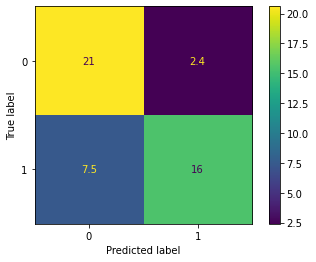

In [ ]:
# Logistic Regression Discrimination
from sklearn.linear_model import LogisticRegression

# Create new X with only ES1G as a feature
X_6 = X[:,6].reshape(-1,1)

# Initialize model and model_name
model = LogisticRegression(random_state=0)
model_name = 'LR ES1G'

# Run cross validation, output evaluation metrics and append accuracy to list
lresg1_results = model_cv_fit_eval(model,model_name,X2=X_6, columns = ['ES1G'])
models_accuracy.append(lresg1_results[0:3])

### Logistic Regression (1 principle component)

LR PCA1 Discrimination - Cross Validation Results
Mean Accuracy 79.78%
STD Accuracy 5.33%


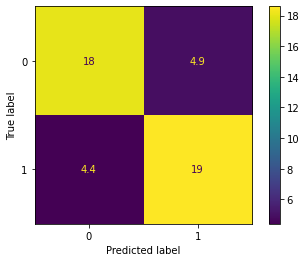

In [ ]:
# Logistic Regression PCA 1 Discrimination
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# Run PCA and create new X with only the first principle component
pca = PCA(n_components=1)
X_t = pca.fit_transform(X_scaled)

# Initialize optimal model and model_name
model = LogisticRegression(random_state=0)
model_name = 'LR PCA1'

# Run cross validation, output evaluation metrics and append accuracy to list
lrpca1_results = model_cv_fit_eval(model,model_name,X2=X_t, columns = ['PC1'])
models_accuracy.append(lrpca1_results[0:3])

### Compare Results

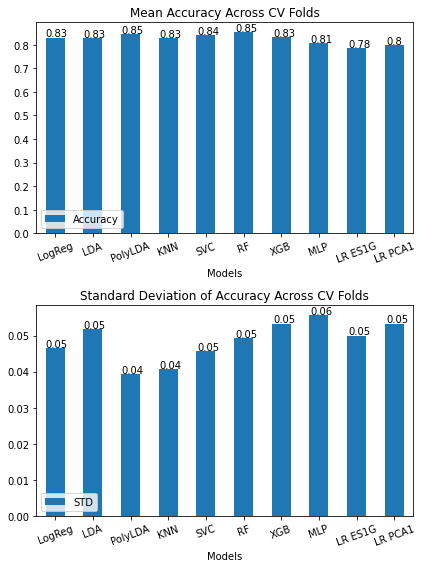

In [ ]:
# Plot result comparisons for cross validation discrimination

fig, ax = fig, axs = plt.subplots(2, figsize=(6,8))

# Create dataframe from model_accuracy list
discriminationDf = pd.DataFrame(models_accuracy, columns = ['Models','Accuracy','STD'])

# Plot model accuracies
ax[0] = discriminationDf.plot.bar(x='Models', y='Accuracy', rot=0, ax = ax[0])

# Add accuracy as annotations to bars 
for p in ax[0].patches:
    ax[0].annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))

# Move legend for accuracy plot
ax[0].legend(loc = "lower left")
ax[0].set_title("Mean Accuracy Across CV Folds")
plt.setp( axs[0].xaxis.get_majorticklabels(), rotation=20 )


# Plot standard deviation of accuracy
ax[1] = discriminationDf.plot.bar(x='Models', y='STD', rot=0, ax= ax[1])

# Add standard deviation as annotations to bars 
for p in ax[1].patches:
    ax[1].annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))

# Move legend for std plot
ax[1].legend(loc = "lower left")
plt.xticks(rotation=20)
ax[1].set_title("Standard Deviation of Accuracy Across CV Folds")
plt.tight_layout()

## Detecting H/D question by question

The second goal of the project is detecting whether each question has been faked or not.
* We first consider an initial analysis trying to predict the number of faked responses. 
* We predict the TF-IDF scores and we use them to predict each question as honest or dishonest. 
* We use these scores as input for a Random Forest Classification for an overall discrimination. However, this does not improve the previous results.
* Then we implement Random Forest (also balancing the dataset), Logistic Regression, Multi Layer Perceptron.
* Another considered approach is to use only the questions that are overall classified as faked to detect which are honest or dishonest.

The best results have been obtained with a Random Forest on raw data.

### Initial Analysis

In [ ]:
# loading data

BF_CTU = pd.read_csv('data/BF_CTU.csv')
BF_OU = pd.read_csv('data/BF_OU.csv')
BF_V = pd.read_csv('data/BF_V.csv')

In [ ]:
df = pd.read_csv('BF_df_OU.csv')

honest = df[df['CONDITION']=='H']
dishonest = df[df['CONDITION']=='D']

# Dataframe where each item is True/False whether the user lied or not
faked = dishonest.reset_index(drop=True) == honest

dishonest_t = dishonest.copy()
dishonest_t.drop(['CONDITION'], axis=1, inplace=True)
dishonest_t.reset_index(drop=True, inplace = True)

faked_all = df.copy()
faked_all.loc[:229] = honest == honest
faked_all.loc[230:] = faked.set_index(pd.Series(range(230, 460)))
faked_all

EX1G   EX2G    A1G    A2G    C1G  ...   ES1G   ES2G    O1G    O2G CONDITION
0     True   True   True   True   True  ...   True   True   True   True      True
1     True   True   True   True   True  ...   True   True   True   True      True
2     True   True   True   True   True  ...   True   True   True   True      True
3     True   True   True   True   True  ...   True   True   True   True      True
4     True   True   True   True   True  ...   True   True   True   True      True
..     ...    ...    ...    ...    ...  ...    ...    ...    ...    ...       ...
455  False  False  False  False   True  ...  False  False  False  False     False
456  False  False  False  False  False  ...   True  False  False   True     False
457  False  False  False  False   True  ...   True  False   True   True     False
458  False  False  False  False  False  ...  False  False  False  False     False
459   True   True  False   True   True  ...   True   True  False   True     False

[460 rows x 11 columns]

In [ ]:
faked

EX1G   EX2G    A1G    A2G    C1G  ...   ES1G   ES2G    O1G    O2G  CONDITION
0    False  False  False  False  False  ...  False  False  False  False      False
1    False  False  False   True   True  ...  False  False   True   True      False
2     True   True  False  False  False  ...  False   True  False  False      False
3    False   True  False  False  False  ...  False  False  False   True      False
4     True   True  False  False   True  ...  False  False  False  False      False
..     ...    ...    ...    ...    ...  ...    ...    ...    ...    ...        ...
225  False  False  False  False   True  ...  False  False  False  False      False
226  False  False  False  False  False  ...   True  False  False   True      False
227  False  False  False  False   True  ...   True  False   True   True      False
228  False  False  False  False  False  ...  False  False  False  False      False
229   True   True  False   True   True  ...   True   True  False   True      False

[230 rows x 11 columns]

Percentage of faked answers: 64.7
Percentage of OVERALL faked answers: 32.35
Avarage not faked questions per user 3.5304347826086957
Avarage faked questions per user 6.469565217391304


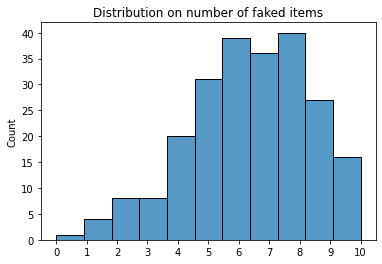

In [ ]:
# Percentage of values that have not been changed
perc_not_faked = sum(faked.drop(columns='CONDITION').sum())/(faked.drop(columns='CONDITION').size)*100
per_faked = 100 -perc_not_faked

print('Percentage of faked answers: '+ str(round(per_faked, 2)))

perc_not_faked = sum(faked_all.drop(columns='CONDITION').sum())/(faked_all.drop(columns='CONDITION').size)*100
per_faked = 100 -perc_not_faked

print('Percentage of OVERALL faked answers: '+ str(round(per_faked, 2)))

not_faked_answers = []
faked_answers = []
zeros = [0]*230
for i in range(0,230):
  # not been faked per row
  not_faked_answers.append((faked.drop(columns='CONDITION').iloc[i].sum()))
  faked_answers.append((10-faked.drop(columns='CONDITION').iloc[i].sum()))

df['UNCHANGED'] = np.array(zeros+not_faked_answers)

incr = []
decr = []

diff_pd = faked.drop(columns='CONDITION').copy()
for i in range(0,230):
  diff = df.iloc[i+230,:10] - df.iloc[i,:10]
  diff_pd.iloc[i, :10] = diff
  incr.append(sum(diff>0)) # di quanto sono aumentate le sue risposte
  decr.append(sum(diff<0))


df['INCREASED'] = np.array(zeros+incr)
df['DECREASED'] = np.array(zeros+decr)

print('Avarage not faked questions per user ' + str(np.array(not_faked_answers).mean()))
print('Avarage faked questions per user ' + str(np.array(faked_answers).mean()))

# ax = sns.histplot(np.array(not_faked_answers), bins=11)
# ax.set_title('Distribution on number of NOT faked items')
# ax.set_xticks(range(0,11))
#_.set_xticks([0,0.9,1.8,2.75,3.65,5,6,7,8,9,10]) #, ['0','1','2','3','4','5','6','7','8','9','10'])
# xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in ax]

ax = sns.histplot(np.array(faked_answers), bins=11)
ax.set_title('Distribution on number of faked items')
ax.set_xticks(range(0,11))
# plt.hist(np.array(faked_answers))
# plt.title("Distribution of faking questions per user")

In [ ]:
count_unch = []
count_incr = []
count_decr = []

for col in diff_pd.columns:
  count_unch.append(len(diff_pd[diff_pd[str(col)]==0]))
  count_incr.append(len(diff_pd[diff_pd[str(col)]>0]))
  count_decr.append(len(diff_pd[diff_pd[str(col)]<0]))

[Text(0, 0, 'EX1G'),
 Text(0, 0, 'EX2G'),
 Text(0, 0, 'A1G'),
 Text(0, 0, 'A2G'),
 Text(0, 0, 'C1G'),
 Text(0, 0, 'C2G'),
 Text(0, 0, 'ES1G'),
 Text(0, 0, 'ES2G'),
 Text(0, 0, 'O1G'),
 Text(0, 0, 'O2G')]

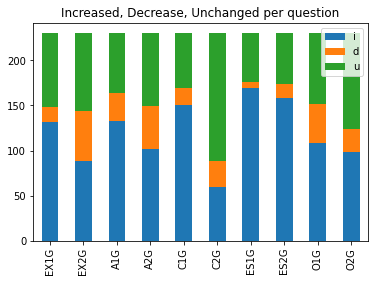

In [ ]:
ax = pd.DataFrame({'i':count_incr, 'd':count_decr, 'u':count_unch}).plot.bar(stacked=True, title='Increased, Decrease, Unchanged per question')
ax.set_xticklabels(input_variables)

# fig.savefig('~/Documents/output.png')

In [ ]:
def model_cv_fit_eval(model,model_name, X, y):
  '''
  Function to generalize cross validation and evaluation outputs across models

  Parameters:
  - model: the sklearn initialized model before fitting with no parameters defined
  - model_name: the name of the model to be used in graphs
  - X: The X inputs to the model
  - y: The output of the model

  Output:
  - model_name: the name of the model
  - mean: the mean accuracy across the k folds
  - std: the standard deviation of accuracy across the k folds

  '''

  # Initialize lists for accuracy scores and confusion matricies across k folds
  scores = []
  conf_matrix_list_of_arrays = []

  # Loop through the k folds

  if type(X) == pd.core.frame.DataFrame:


    kfold = KFold(n_splits=10, shuffle=True) ##############
    for train_index, test_index in kfold.split(X, y):

      # Split test and train based on k fold
      X_train, X_test = X.loc[train_index], X.loc[test_index] ### I added loc
      y_train, y_test = y.loc[train_index], y.loc[test_index] ### I added loc

      # Fit model
      model.fit(X_train, np.array(y_train).reshape(y_train.shape[0],)) ### I added this 

      # Generate confusion matrix and append to conf_matrix_list_of_arrays
      conf_matrix = confusion_matrix(y_test, model.predict(X_test))
      conf_matrix_list_of_arrays.append(conf_matrix)

      # Generate accuracy score and append to scores
      scores.append(accuracy_score(y_test, model.predict(X_test)))

    # Average of all the confusion matricies across kfolds
    mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)


  else:


    kfold = KFold(n_splits=10, shuffle=True) ##############
    for train_index, test_index in kfold.split(X, y):

      # Split test and train based on k fold
      X_train, X_test = X[train_index], X[test_index] ### I added loc
      y_train, y_test = y[train_index], y[test_index] ### I added loc

      # Fit model
      model.fit(X_train, np.array(y_train).reshape(y_train.shape[0],)) ### I added this 

      # Generate confusion matrix and append to conf_matrix_list_of_arrays
      conf_matrix = confusion_matrix(y_test, model.predict(X_test))
      conf_matrix_list_of_arrays.append(conf_matrix)

      # Generate accuracy score and append to scores
      scores.append(accuracy_score(y_test, model.predict(X_test)))

    # Average of all the confusion matricies across kfolds
    mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)
  

  # Average and stdev of all the kfold accuracy scores
  mean = np.mean(scores)
  std = np.std(scores)

  # Print results
  print("{} Discrimination - Cross Validation Results".format(model_name))
  print('Mean Accuracy {}%'.format(round(mean*100,2)))
  print('STD Accuracy {}%'.format(round(std*100,2)))

  # Display confusion matrix
  disp = ConfusionMatrixDisplay(confusion_matrix=mean_of_conf_matrix_arrays)
  disp.plot()
  plt.show()

  return model_name, mean, std

The code for the TF-IDF model has been taken from [here](https://github.com/albpurpura/TFIDF-Faking). To compute the TF-IDF scores, the model takes into account other two datasets.
The accuracy output per question are the baseline for this task.

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tqdm import tqdm

def load_data(fpath=''):
    if len(fpath) == 0:
        fpaths = ['data/BF_CTU.csv', 'data/BF_V.csv', 'data/BF_OU.csv']
    else:
        fpaths = fpath

    honest_data = []
    dishonest_data = []
    for fpath in fpaths:
        header = True
        for line in open(fpath):
            data = line.strip().split(',')
            if header:
                header = False
                continue
            is_honest = data[-1] == 'H'
            answers = np.array(data[:10])
            if is_honest:
                honest_data.append(answers)
            else:
                dishonest_data.append(answers)
    
    return np.array(honest_data), np.array(dishonest_data)


def compute_tf_idf(all_data, idfs=None):
    all_data = np.array(all_data)
    tfidfs = np.zeros_like(all_data)
    distinct_answ_values = [1, 2, 3, 4, 5]
    if idfs is None:
        idfs = np.ones(shape=(len(distinct_answ_values), all_data.shape[1])) * all_data.shape[0]
        for answ_value_idx in range(len(distinct_answ_values)):
            for answ_idx in range(all_data.shape[1]):
                unique, counts = np.unique(all_data[:, answ_idx], return_counts=True)
                idfs[answ_value_idx][answ_idx] = np.log(idfs[answ_value_idx][answ_idx] /
                                                        [counts[i] for i in range(len(counts)) if
                                                         unique[i] == distinct_answ_values[answ_value_idx]][0])

    for i in range(len(all_data)):
        for j in range(all_data.shape[1]):
            curr_v = all_data[i, j]
            curr_v_index_in_idf_matrix = \
                [k for k in range(len(distinct_answ_values)) if distinct_answ_values[k] == curr_v][0]
            tf_curr_v = np.count_nonzero(all_data[i] == curr_v)
            assert 2 == np.count_nonzero(np.array([1, 3, 3, 4]) == 3)
            assert curr_v_index_in_idf_matrix == curr_v - 1
            tfidfs[i, j] = tf_curr_v * idfs[curr_v_index_in_idf_matrix, j]
    return tfidfs, idfs


def estimate_per_question_thresholds(tfidf_scores, thr=80):
    return [np.percentile(tfidf_scores[:, j], thr) for j in range(tfidf_scores.shape[1])]


def evaluate_pair(true_lies_mask, detected_lies_mask):
    if np.sum(detected_lies_mask) > 0:
        prec = np.sum(
            np.where((detected_lies_mask == true_lies_mask) & (true_lies_mask == np.ones_like(true_lies_mask)),
                     np.ones_like(detected_lies_mask), 0)) / np.sum(detected_lies_mask)
    else:
        prec = 0.
    if np.sum(true_lies_mask) > 0:
        rec = np.sum(np.where((detected_lies_mask == true_lies_mask) & (true_lies_mask == np.ones_like(true_lies_mask)),
                              np.ones_like(detected_lies_mask), 0)) / np.sum(true_lies_mask)
    else:
        rec = 0.

    if prec + rec > 0:
        f1 = 2 * prec * rec / (prec + rec)
    else:
        f1 = 0.0
    return prec, rec, f1


def compute_precs_recs_f1s(true_lies_mask, detected_lies_mask):
    curr_precs = []
    curr_f1s = []
    curr_recs = []
    for i in range(detected_lies_mask.shape[0]):
        prec, rec, f1 = evaluate_pair(true_lies_mask[i], detected_lies_mask[i])
        curr_f1s.append(f1)
        curr_precs.append(prec)
        curr_recs.append(rec)
    # return np.mean(curr_precs), np.mean(curr_recs), np.mean(curr_f1s)
    return curr_precs, curr_recs, curr_f1s


def optimize_thr_dist(honest_data, faked_data, true_lies_mask):
    perfs = []
    thrs = []
    for percentile in np.arange(50, 100, step=1):
        thresholds = estimate_per_question_thresholds(honest_data, percentile)
        detected_lies_mask = np.array(
            [np.where(faked_data[:, j] >= thresholds[j], np.ones_like(faked_data[:, j]), 0) for j in
             range(faked_data.shape[1])]).transpose()
        # p, r, f1 = compute_precs_recs_f1s(true_lies_mask, detected_lies_mask)
        acc = np.mean(np.where(true_lies_mask == detected_lies_mask, np.ones_like(detected_lies_mask), 0))
        perfs.append(acc)
        thrs.append(percentile)
    best_thr = thrs[np.argmax(perfs)]
    print('best thr={}'.format(best_thr))
    return best_thr


def optimize_thr(tfidfs_honest, tfidfs_faked, true_lies_mask, dname=''):
    perfs = []
    thrs = []
    #out = open('./output/tfidf_perfs_at_different_percentiles_on_training_data_of_test_dataset={}.tsv'.format(dname),
              # 'w')
    #out.write('Percentile\tAccuracy\tPrecision\tRecall\tF1 Score\n')
    for thr in np.arange(5, 100, step=5):
        thresholds = estimate_per_question_thresholds(tfidfs_honest, thr)
        detected_lies_mask = np.array(
            [np.where(tfidfs_faked[:, j] >= thresholds[j], np.ones_like(tfidfs_faked[:, j]), 0) for j in
             range(tfidfs_faked.shape[1])]).transpose()
        p, r, f1 = compute_precs_recs_f1s(true_lies_mask, detected_lies_mask)
        acc = np.mean(np.where(true_lies_mask == detected_lies_mask, np.ones_like(detected_lies_mask), 0))
        perfs.append(np.mean(p))
        thrs.append(thr)
        #out.write('{}\t{}\t{}\t{}\t{}\n'.format(thr, acc, np.mean(p), np.mean(r), np.mean(f1)))
    best_thr = thrs[np.argmax(perfs)]
    #out.close()
    print('best percentile={}'.format(best_thr))
    return best_thr


def get_train_test_data(test_set):
    all_fpaths = ['data/BF_CTU.csv', 'data/BF_V.csv']
    #all_fpaths.remove(test_set)
    #assert len(all_fpaths) == 2
    hdata_train, ldata_train = load_data(all_fpaths)
    hdata_train = np.array(hdata_train, dtype=np.float)
    ldata_train = np.array(ldata_train, dtype=np.float)

    hdata_test, ldata_test = load_data([test_set])
    hdata_test = np.array(hdata_test, dtype=np.float)
    ldata_test = np.array(ldata_test, dtype=np.float)

    return hdata_train, hdata_test, ldata_train, ldata_test


def compute_perf_distr_model(test_set):
    print('Distribution Model')
    hdata_train, hdata_test, ldata_train, ldata_test = get_train_test_data(test_set)
    true_lies_mask_train = np.where(hdata_train != ldata_train, np.ones_like(hdata_train), 0)
    true_lies_mask_test = np.where(hdata_test != ldata_test, np.ones_like(ldata_test), 0)
    percentile = optimize_thr_dist(hdata_train, ldata_train, true_lies_mask_train)
    print('percentile: {}'.format(percentile))
    thresholds = estimate_per_question_thresholds(hdata_train, percentile)
    detected_lies_mask_test = np.array(
        [np.where(hdata_test[:, j] >= thresholds[j], np.ones_like(hdata_test[:, j]), 0) for j in
         range(hdata_test.shape[1])]).transpose()
    p, r, f1 = compute_precs_recs_f1s(true_lies_mask_test, detected_lies_mask_test)
    accs = np.mean(np.where(true_lies_mask_test == detected_lies_mask_test, np.ones_like(true_lies_mask_test),
                            np.zeros_like(true_lies_mask_test)), axis=-1)
    p = np.mean(p)
    r = np.mean(r)
    f1 = np.mean(f1)
    print('Prec: {}, Recall: {}, F1Score: {}, Accuracy: {}'.format(p, r, f1, np.mean(accs)))
    print('{:.4f} & {:.4f} & {:.4f} & {:.4f}'.format(p, r, f1, np.mean(accs)))


def get_k_closest_vecs(v, pool, k):
    dists = [np.sum(np.dot(v, p) / (np.linalg.norm(v, ord=2) * np.linalg.norm(p, ord=2))) for p in pool]
    return np.array(pool)[np.argsort(dists)[: k]]


def compute_detected_lies_mask(v, closest_vecs, thr=1.0):
    avg_neighbor = np.mean(closest_vecs, axis=0)
    assert avg_neighbor.shape == closest_vecs[0].shape
    return np.where(np.abs(avg_neighbor - v) > thr, np.ones_like(v), 0)


def compute_perf_tfidf(test_set):
    print('TFIDF MODEL')
    fnames_mapper = {'data/BF_CTU.csv': 'C', 'data/BF_V.csv': 'S', 'data/BF_OU.csv': 'H'}
    hdata_train, hdata_test, ldata_train, ldata_test = get_train_test_data(test_set)
    true_lies_mask_train = np.where(hdata_train != ldata_train, np.ones_like(hdata_train), 0)
    true_lies_mask_test = np.where(hdata_test != ldata_test, np.ones_like(ldata_test), 0)

    tfidfs_honest_train, idfs_honest = compute_tf_idf(hdata_train)
    tfidfs_faked_train, _ = compute_tf_idf(ldata_train, idfs_honest)
    tfidfs_faked_test, _ = compute_tf_idf(ldata_test, idfs_honest)
    tfidfs_honest_test, _ = compute_tf_idf(hdata_test, idfs_honest)

    thr = optimize_thr(tfidfs_honest_train, tfidfs_faked_train, true_lies_mask_train, dname=fnames_mapper[test_set])
    thresholds = estimate_per_question_thresholds(tfidfs_honest_train, thr)
    # thresholds = optimize_thr_by_item(tfidfs_honest_train, tfidfs_faked_train, true_lies_mask_train)
    detected_lies_mask_test = np.array(
        [np.where(tfidfs_faked_test[:, j] >= thresholds[j], np.ones_like(tfidfs_faked_test[:, j]), 0) for j in
         range(tfidfs_faked_test.shape[1])]).transpose()
    assert detected_lies_mask_test.shape == true_lies_mask_test.shape
    accs = np.mean(np.where(true_lies_mask_test == detected_lies_mask_test, np.ones_like(true_lies_mask_test),
                            np.zeros_like(true_lies_mask_test)), axis=-1)
    precs = []
    recs = []
    f1s = []
    for i in range(detected_lies_mask_test.shape[0]):
        prec, rec, f1 = evaluate_pair(true_lies_mask_test[i], detected_lies_mask_test[i])
        precs.append(prec)
        recs.append(rec)
        f1s.append(f1)
    print(
        'Multi-label classification task: Precision: {}, Recall: {}, F1 Score: {}, Accuracy: {}'.format(np.mean(precs),
                                                                                                        np.mean(recs),
                                                                                                        np.mean(f1s),
                                                                                                        np.mean(accs)))
    print('{:.4f} & {:.4f} & {:.4f} & {:.4f}'.format(np.mean(precs), np.mean(recs), np.mean(f1s), np.mean(accs)))

    per_question_accuracy = compute_per_question_accuracy(true_lies_mask_test, detected_lies_mask_test)
    print("Per question accuracy" + str(per_question_accuracy))

   
def compute_faked_answ_mask(pred_n_lies_per_test, tfidfs_faked_test, thresholds):
    new_lies_masks = []
    for i in range(tfidfs_faked_test.shape[0]):
        n_pred_lies = pred_n_lies_per_test[i]
        lies_indices = np.argsort(-np.where(tfidfs_faked_test[i] >= thresholds, tfidfs_faked_test[i], 0))[
                       :int(np.ceil(n_pred_lies))]
        curr_lies_mask = np.zeros_like(tfidfs_faked_test[i])
        for k in lies_indices:
            curr_lies_mask[k] = 1
        new_lies_masks.append(curr_lies_mask)
    return np.array(new_lies_masks)

def compute_per_question_accuracy(true_lies_mask, detected_lies_mask):
    # per_question_accuracy = []
    for question_index in range(true_lies_mask.shape[1]):
        accuracy = np.mean(np.where(true_lies_mask[:, question_index] == detected_lies_mask[:, question_index],
                                    np.ones_like(detected_lies_mask[:, question_index]), 0))
        per_question_accuracy_tfidf.append(accuracy)

    return np.array(per_question_accuracy_tfidf)


### Estimation on the number of faked responses 

In [ ]:
# Unchanged
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['CONDITION', 'UNCHANGED', 'INCREASED', 'DECREASED']), df['UNCHANGED'], shuffle=True, test_size=0.2)

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

print('Accuracy of unchanged: ' + str(model.score(X_test, y_test)))

# Increased
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['CONDITION', 'UNCHANGED', 'INCREASED', 'DECREASED']), df['INCREASED'], shuffle=True, test_size=0.2)

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)
print('Accuracy of increased: ' + str(model.score(X_test, y_test)))

# Decreased
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['CONDITION', 'UNCHANGED', 'INCREASED', 'DECREASED']), df['DECREASED'], shuffle=True, test_size=0.2)

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)
print('Accuracy of decreased: ' + str(model.score(X_test, y_test)))

Accuracy of unchanged: 0.5217391304347826
Accuracy of increased: 0.5543478260869565
Accuracy of decreased: 0.7608695652173914


In [ ]:
# Compute TF-IDF scores
tfidfs, idfs = compute_tf_idf(df.drop(columns=['CONDITION', 'INCREASED', 'DECREASED', 'UNCHANGED']))

tfidfs = pd.DataFrame(tfidfs)
tfidfs['CONDITION_BINARY'] = (df['CONDITION']=='H')*1

In [ ]:
# Unchanged
X_train, X_test, y_train, y_test = train_test_split(tfidfs.drop(columns=['CONDITION_BINARY']), df['UNCHANGED'], shuffle=True, test_size=0.2)

model = RandomForestClassifier()
model.fit(X_train, y_train)
print('Accuracy of unchanged: ' + str(model.score(X_test, y_test)))

# Increased
X_train, X_test, y_train, y_test = train_test_split(tfidfs.drop(columns=['CONDITION_BINARY']), df['INCREASED'], shuffle=True, test_size=0.2)

model = RandomForestClassifier()
model.fit(X_train, y_train)
print('Accuracy of increased: ' + str(model.score(X_test, y_test)))

# Decreased
X_train, X_test, y_train, y_test = train_test_split(tfidfs.drop(columns=['CONDITION_BINARY']), df['DECREASED'], shuffle=True, test_size=0.2)

model = RandomForestClassifier()
model.fit(X_train, y_train)
print('Accuracy of decreased: ' + str(model.score(X_test, y_test)))

Accuracy of unchanged: 0.532608695652174
Accuracy of increased: 0.5869565217391305
Accuracy of decreased: 0.6739130434782609


### TF-IDF

Here we run the model.

In [ ]:
# List to save the accuracy outputs
per_question_accuracy_tfidf = []

def run():
    for test_set in ['data/BF_OU.csv']:
        print(test_set)
        compute_perf_tfidf(test_set)
        # compute_perf_distr_model(test_set)


if __name__ == '__main__':
    run()

data/BF_OU.csv
TFIDF MODEL
best percentile=75
Multi-label classification task: Precision: 0.6808212560386473, Recall: 0.5704796411318149, F1 Score: 0.5877454059827192, Accuracy: 0.5847826086956521
0.6808 & 0.5705 & 0.5877 & 0.5848
Per question accuracy[0.60869565 0.54782609 0.60434783 0.57391304 0.6173913  0.55217391
 0.66521739 0.67391304 0.5173913  0.48695652]


### TFIDF overall discrimination with RF

In [ ]:
# Import data
df = pd.read_csv('BF_df_OU.csv')
df1 = df.loc[:, df.columns != 'CONDITION'].copy()

# Compute TF-IDF scores
tfidfs, idfs = compute_tf_idf(df1)
tfidfs = pd.DataFrame(tfidfs)
tfidfs['CONDITION BINARY'] = (df['CONDITION']=='H')*1

Random Forest for TFIDF Discrimination - Grid Search Results
{'bootstrap': False, 'max_depth': 7}
Random Forest for TFIDF Discrimination - Cross Validation Results
Mean Accuracy 78.48%
STD Accuracy 5.09%


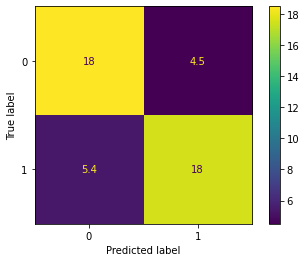

In [ ]:
# Run a Random Forest on the previous computed TF-IDF scores
model = RandomForestClassifier()

# Perform a Grid Search
params = [{'max_depth': [3,4,5,6,7,8,9], 'bootstrap': [True, False]}]
gs_params = grid_search(model, 'Random Forest for TFIDF', params, tfidfs.drop(columns=['CONDITION BINARY']), y = np.array(tfidfs[['CONDITION BINARY']] ).reshape(tfidfs[['CONDITION BINARY']] .shape[0],))

# Search for the best parameters
model = RandomForestClassifier(max_depth=gs_params['max_depth'], bootstrap=gs_params['bootstrap'], random_state=0)

# Run cross validation, output evaluation metrics and append accuracy to list
results = model_cv_fit_eval(model, 'Random Forest for TFIDF', tfidfs.drop(columns=['CONDITION BINARY']), tfidfs[['CONDITION BINARY']])

### Random Forest per question

Here we consider the whole dataset.

RF_per_question_all EX1G Discrimination - Cross Validation Results
Mean Accuracy 77.83%
STD Accuracy 5.65%


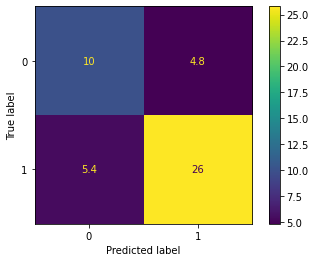

RF_per_question_all EX2G Discrimination - Cross Validation Results
Mean Accuracy 74.35%
STD Accuracy 6.58%


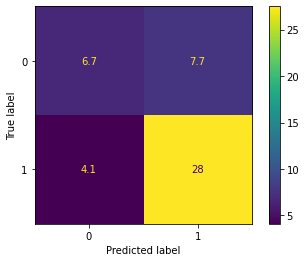

RF_per_question_all A1G Discrimination - Cross Validation Results
Mean Accuracy 83.48%
STD Accuracy 5.25%


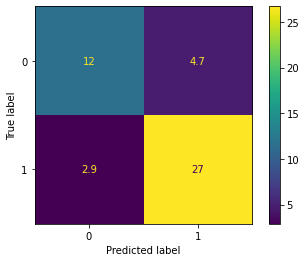

RF_per_question_all A2G Discrimination - Cross Validation Results
Mean Accuracy 80.22%
STD Accuracy 7.68%


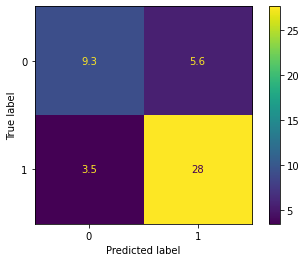

RF_per_question_all C1G Discrimination - Cross Validation Results
Mean Accuracy 77.17%
STD Accuracy 6.32%


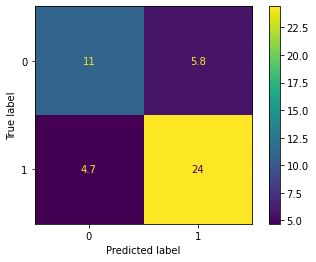

RF_per_question_all C2G Discrimination - Cross Validation Results
Mean Accuracy 80.43%
STD Accuracy 6.23%


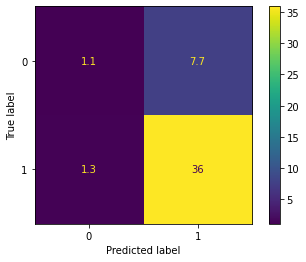

RF_per_question_all ES1G Discrimination - Cross Validation Results
Mean Accuracy 83.48%
STD Accuracy 3.91%


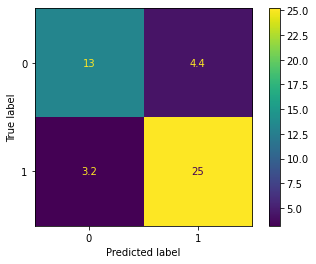

RF_per_question_all ES2G Discrimination - Cross Validation Results
Mean Accuracy 81.3%
STD Accuracy 3.1%


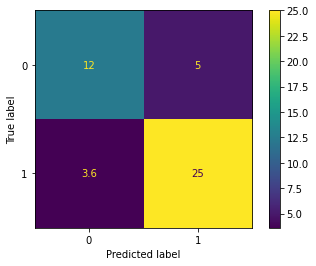

RF_per_question_all O1G Discrimination - Cross Validation Results
Mean Accuracy 78.04%
STD Accuracy 6.11%


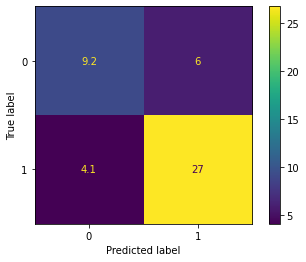

RF_per_question_all O2G Discrimination - Cross Validation Results
Mean Accuracy 75.43%
STD Accuracy 5.42%


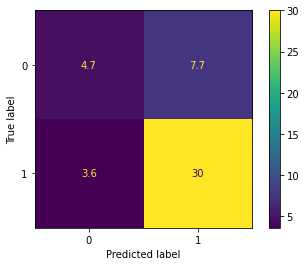

In [ ]:
per_question_accuracy_rf_all = []
per_question_sd_rf_all = []

for col in faked_all.columns:
  if not(str(col) == 'CONDITION'):

    # Select output column
    faked_vector = faked_all[str(col)]*1
    faked_vector = faked_vector.astype(int)
   
    # Initialize model
    model_name = 'RF_per_question_all ' + str(col)
    model = RandomForestClassifier(random_state=0, max_depth=7, bootstrap=True)

    # Run cross validation, output evaluation metrics and append accuracy to list
    rf_results = model_cv_fit_eval(model,model_name, X = df.drop(columns='CONDITION'),  y = faked_vector)
    per_question_accuracy_rf_all.append(rf_results[1])
    per_question_sd_rf_all.append(rf_results[2])


### Random Forest balanced per question


RF_per_question_all balanced EX1G Discrimination - Cross Validation Results
Mean Accuracy 79.78%
STD Accuracy 4.13%


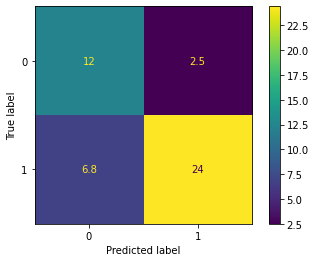

RF_per_question_all balanced EX2G Discrimination - Cross Validation Results
Mean Accuracy 76.09%
STD Accuracy 4.96%


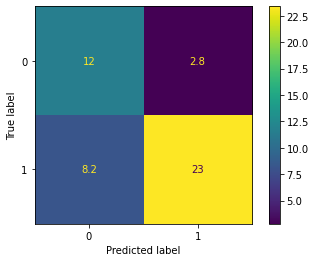

RF_per_question_all balanced A1G Discrimination - Cross Validation Results
Mean Accuracy 82.39%
STD Accuracy 4.9%


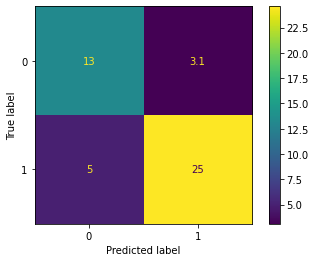

RF_per_question_all balanced A2G Discrimination - Cross Validation Results
Mean Accuracy 78.91%
STD Accuracy 5.92%


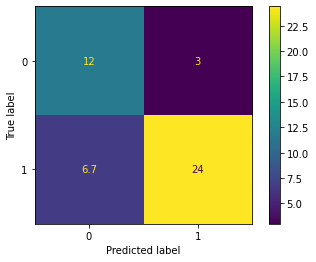

RF_per_question_all balanced C1G Discrimination - Cross Validation Results
Mean Accuracy 78.04%
STD Accuracy 6.84%


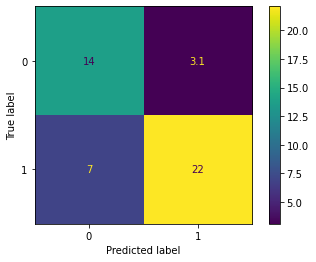

RF_per_question_all balanced C2G Discrimination - Cross Validation Results
Mean Accuracy 67.39%
STD Accuracy 6.45%


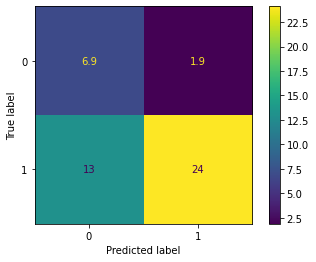

RF_per_question_all balanced ES1G Discrimination - Cross Validation Results
Mean Accuracy 80.65%
STD Accuracy 7.74%


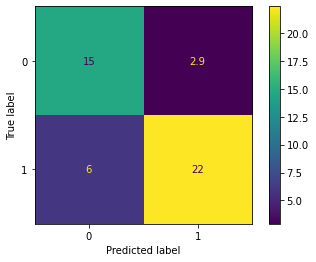

RF_per_question_all balanced ES2G Discrimination - Cross Validation Results
Mean Accuracy 80.22%
STD Accuracy 5.36%


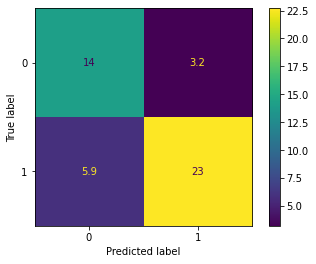

RF_per_question_all balanced O1G Discrimination - Cross Validation Results
Mean Accuracy 75.87%
STD Accuracy 3.94%


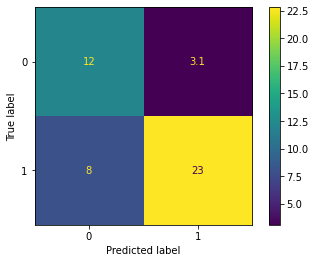

RF_per_question_all balanced O2G Discrimination - Cross Validation Results
Mean Accuracy 71.52%
STD Accuracy 7.56%


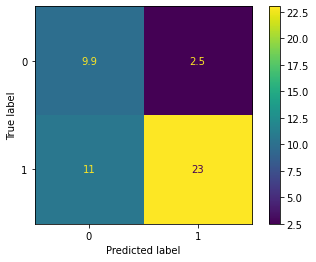

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

per_question_accuracy_rf_bal = []
per_question_sd_rf_bal = []

for col in faked_all.columns:
  if not(str(col) == 'CONDITION'):

    # Select output column
    faked_vector = faked_all[str(col)]*1
    faked_vector = faked_vector.astype(int)
   
    # Initialize model
    model = BalancedRandomForestClassifier(max_depth=7, random_state=0, bootstrap=True)
    model_name = 'RF_per_question_all balanced ' + str(col)

    # Run cross validation, output evaluation metrics and append accuracy to list
    rf_results = model_cv_fit_eval(model,model_name, X = df.drop(columns='CONDITION'),  y = faked_vector)
    per_question_accuracy_rf_bal.append(rf_results[1])
    per_question_sd_rf_bal.append(rf_results[2])


In [ ]:
np.mean(np.array(per_question_accuracy_rf_bal))

0.7708695652173911

### K Nearest Neighbors per question

KNN_per_question EX1G Discrimination - Cross Validation Results
Mean Accuracy 76.74%
STD Accuracy 3.77%


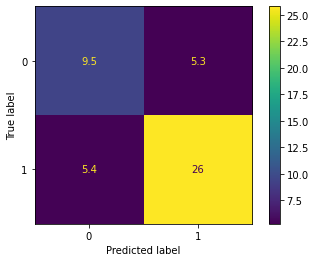

KNN_per_question EX2G Discrimination - Cross Validation Results
Mean Accuracy 74.35%
STD Accuracy 8.52%


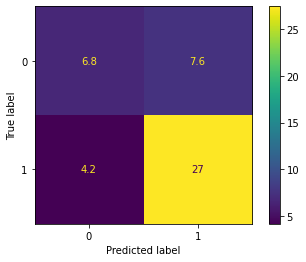

KNN_per_question A1G Discrimination - Cross Validation Results
Mean Accuracy 81.74%
STD Accuracy 5.69%


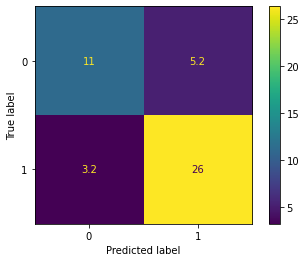

KNN_per_question A2G Discrimination - Cross Validation Results
Mean Accuracy 77.83%
STD Accuracy 6.65%


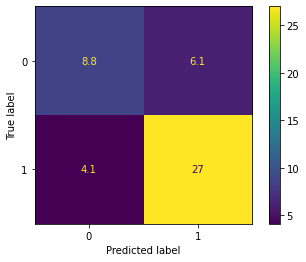

KNN_per_question C1G Discrimination - Cross Validation Results
Mean Accuracy 76.74%
STD Accuracy 4.67%


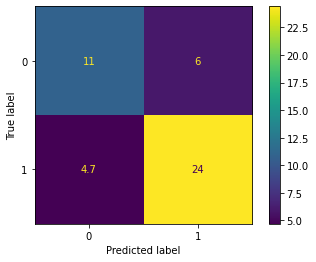

KNN_per_question C2G Discrimination - Cross Validation Results
Mean Accuracy 80.0%
STD Accuracy 4.33%


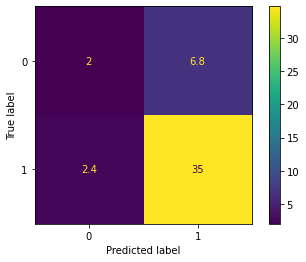

KNN_per_question ES1G Discrimination - Cross Validation Results
Mean Accuracy 79.13%
STD Accuracy 5.52%


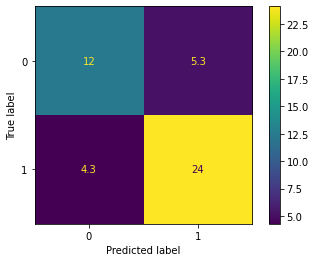

KNN_per_question ES2G Discrimination - Cross Validation Results
Mean Accuracy 76.96%
STD Accuracy 7.42%


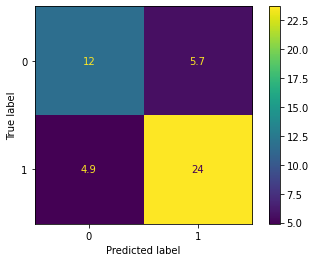

KNN_per_question O1G Discrimination - Cross Validation Results
Mean Accuracy 74.78%
STD Accuracy 5.43%


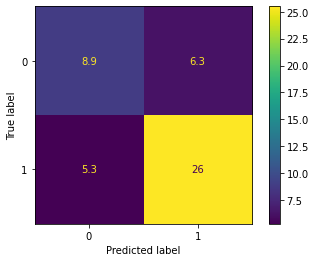

KNN_per_question O2G Discrimination - Cross Validation Results
Mean Accuracy 74.57%
STD Accuracy 4.35%


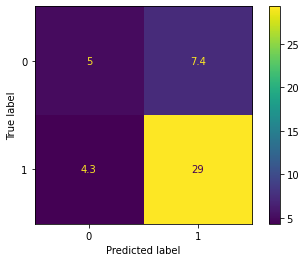

In [ ]:
per_question_accuracy_knn_all = []
per_question_sd_knn_all = []

for col in faked_all.columns:
  if not(str(col) == 'CONDITION'):

    # Select output column
    faked_vector = faked_all[str(col)]*1
    faked_vector = faked_vector.astype(int)

    # Initialize model
    model_name = 'KNN_per_question ' + str(col)
    model = KNeighborsClassifier(n_neighbors = 5, weights = 'uniform')

    # Run cross validation, output evaluation metrics and append accuracy to list
    knn_results = model_cv_fit_eval(model,model_name, X = df.drop(columns='CONDITION'),  y = faked_vector)
    per_question_accuracy_knn_all.append(knn_results[1])
    per_question_sd_knn_all.append(knn_results[2])



### Logistic Regression per question


Logistic Regression per question EX1G Discrimination - Cross Validation Results
Mean Accuracy 78.26%
STD Accuracy 5.67%


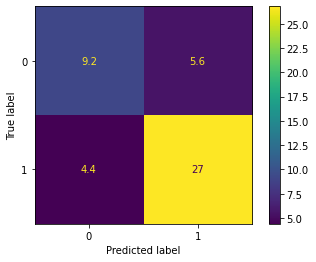

Logistic Regression per question EX2G Discrimination - Cross Validation Results
Mean Accuracy 75.65%
STD Accuracy 5.74%


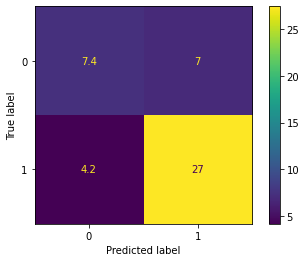

Logistic Regression per question A1G Discrimination - Cross Validation Results
Mean Accuracy 80.87%
STD Accuracy 5.4%


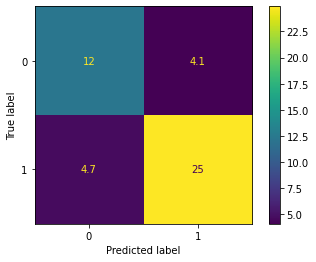

Logistic Regression per question A2G Discrimination - Cross Validation Results
Mean Accuracy 77.17%
STD Accuracy 4.48%


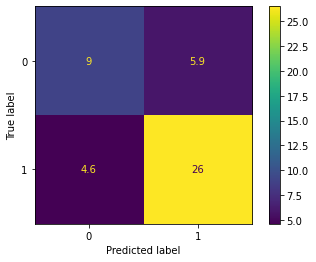

Logistic Regression per question C1G Discrimination - Cross Validation Results
Mean Accuracy 78.26%
STD Accuracy 6.59%


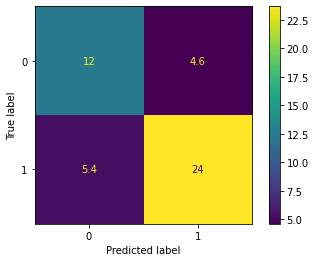

Logistic Regression per question C2G Discrimination - Cross Validation Results
Mean Accuracy 80.87%
STD Accuracy 3.86%


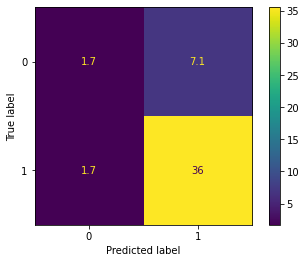

Logistic Regression per question ES1G Discrimination - Cross Validation Results
Mean Accuracy 78.26%
STD Accuracy 5.58%


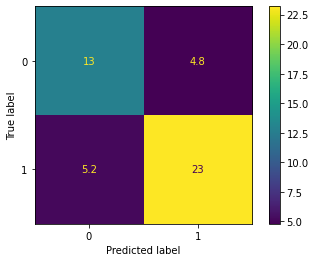

Logistic Regression per question ES2G Discrimination - Cross Validation Results
Mean Accuracy 78.48%
STD Accuracy 5.87%


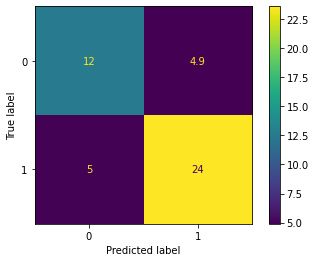

Logistic Regression per question O1G Discrimination - Cross Validation Results
Mean Accuracy 75.22%
STD Accuracy 3.66%


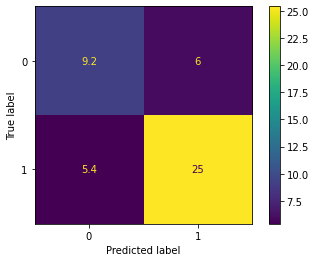

Logistic Regression per question O2G Discrimination - Cross Validation Results
Mean Accuracy 75.0%
STD Accuracy 7.48%


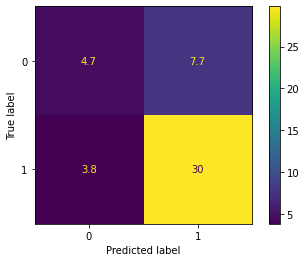

In [ ]:
per_question_accuracy_lr_all = []
per_question_sd_lr_all = []

for col in faked_all.columns:
  if not(str(col) == 'CONDITION'):

    # Select output column
    faked_vector = faked_all[str(col)]*1
    faked_vector = faked_vector.astype(int)
   
    # Initialize model
    model_name = 'Logistic Regression per question ' + str(col)
    model = LogisticRegression(random_state=0)

    # Run cross validation, output evaluation metrics and append accuracy to list
    rf_results = model_cv_fit_eval(model,model_name, X = df.drop(columns='CONDITION'),  y = faked_vector)
    per_question_accuracy_lr_all.append(rf_results[1])
    per_question_sd_lr_all.append(rf_results[2])

### MLP per question

Model for column EX1G
Epoch 1/300
23/23 [==============================] - 1s 12ms/step - loss: 0.7305 - accuracy: 0.5978 - val_loss: 0.6032 - val_accuracy: 0.6739
Epoch 2/300
23/23 [==============================] - 0s 5ms/step - loss: 0.6886 - accuracy: 0.5951 - val_loss: 0.5775 - val_accuracy: 0.7174
Epoch 3/300
23/23 [==============================] - 0s 3ms/step - loss: 0.6703 - accuracy: 0.6168 - val_loss: 0.5747 - val_accuracy: 0.6522
Epoch 4/300
23/23 [==============================] - 0s 3ms/step - loss: 0.6448 - accuracy: 0.6114 - val_loss: 0.5295 - val_accuracy: 0.7391
Epoch 5/300
23/23 [==============================] - 0s 4ms/step - loss: 0.6204 - accuracy: 0.6793 - val_loss: 0.5629 - val_accuracy: 0.6304
Epoch 6/300
23/23 [==============================] - 0s 3ms/step - loss: 0.6110 - accuracy: 0.6332 - val_loss: 0.5211 - val_accuracy: 0.6304
Epoch 7/300
23/23 [==============================] - 0s 3ms/step - loss: 0.5727 - accuracy: 0.6793 - val_loss: 0.5051 - val_accurac

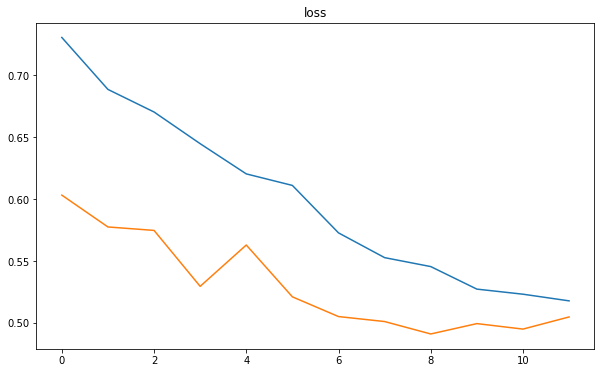

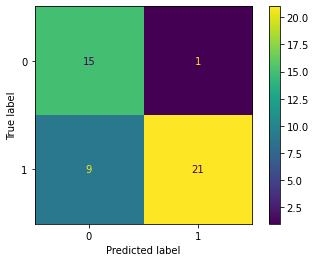

Model for column EX2G
Epoch 1/300
23/23 [==============================] - 1s 12ms/step - loss: 0.7365 - accuracy: 0.6223 - val_loss: 0.6965 - val_accuracy: 0.5217
Epoch 2/300
23/23 [==============================] - 0s 4ms/step - loss: 0.7247 - accuracy: 0.5951 - val_loss: 0.6681 - val_accuracy: 0.6304
Epoch 3/300
23/23 [==============================] - 0s 4ms/step - loss: 0.6824 - accuracy: 0.6304 - val_loss: 0.6478 - val_accuracy: 0.6087
Epoch 4/300
23/23 [==============================] - 0s 3ms/step - loss: 0.6580 - accuracy: 0.6522 - val_loss: 0.6444 - val_accuracy: 0.6739
Epoch 5/300
23/23 [==============================] - 0s 3ms/step - loss: 0.6393 - accuracy: 0.6440 - val_loss: 0.6254 - val_accuracy: 0.6304
Epoch 6/300
23/23 [==============================] - 0s 4ms/step - loss: 0.6266 - accuracy: 0.6386 - val_loss: 0.6316 - val_accuracy: 0.6304
Epoch 7/300
23/23 [==============================] - 0s 3ms/step - loss: 0.6128 - accuracy: 0.6386 - val_loss: 0.6261 - val_accurac

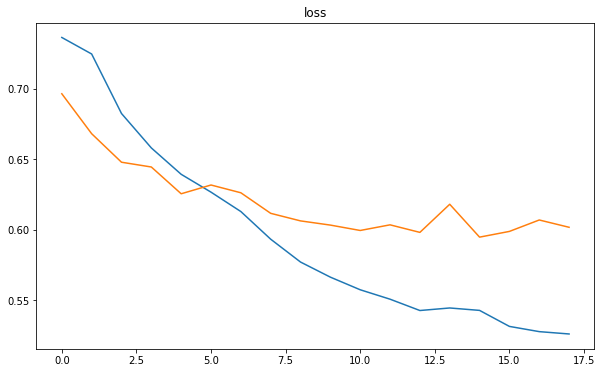

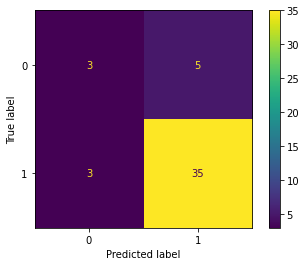

Model for column A1G
Epoch 1/300
23/23 [==============================] - 1s 11ms/step - loss: 0.7200 - accuracy: 0.5870 - val_loss: 0.6495 - val_accuracy: 0.6087
Epoch 2/300
23/23 [==============================] - 0s 4ms/step - loss: 0.6658 - accuracy: 0.6250 - val_loss: 0.6141 - val_accuracy: 0.6522
Epoch 3/300
23/23 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.6304 - val_loss: 0.5722 - val_accuracy: 0.6957
Epoch 4/300
23/23 [==============================] - 0s 3ms/step - loss: 0.6162 - accuracy: 0.6712 - val_loss: 0.5476 - val_accuracy: 0.7391
Epoch 5/300
23/23 [==============================] - 0s 3ms/step - loss: 0.5906 - accuracy: 0.7038 - val_loss: 0.5292 - val_accuracy: 0.7391
Epoch 6/300
23/23 [==============================] - 0s 3ms/step - loss: 0.5824 - accuracy: 0.7092 - val_loss: 0.5598 - val_accuracy: 0.6957
Epoch 7/300
23/23 [==============================] - 0s 4ms/step - loss: 0.5738 - accuracy: 0.6902 - val_loss: 0.4738 - val_accuracy

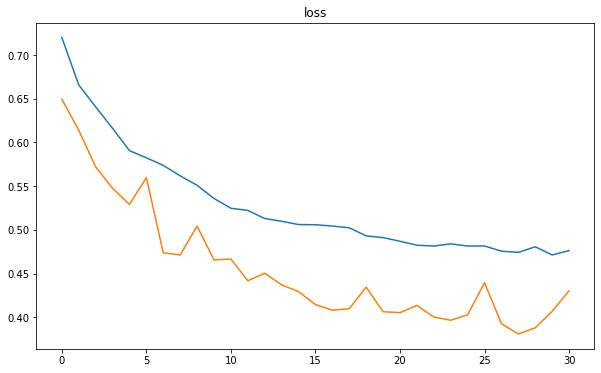

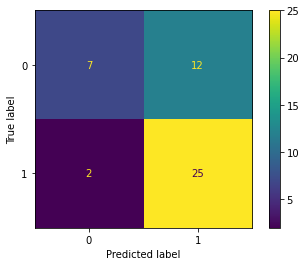

Model for column A2G
Epoch 1/300
23/23 [==============================] - 1s 11ms/step - loss: 5.0501 - accuracy: 0.3261 - val_loss: 2.8200 - val_accuracy: 0.3696
Epoch 2/300
23/23 [==============================] - 0s 2ms/step - loss: 1.7861 - accuracy: 0.3560 - val_loss: 0.9102 - val_accuracy: 0.5435
Epoch 3/300
23/23 [==============================] - 0s 2ms/step - loss: 1.0074 - accuracy: 0.5163 - val_loss: 0.9047 - val_accuracy: 0.5652
Epoch 4/300
23/23 [==============================] - 0s 2ms/step - loss: 0.9600 - accuracy: 0.5353 - val_loss: 0.8432 - val_accuracy: 0.5435
Epoch 5/300
23/23 [==============================] - 0s 3ms/step - loss: 0.9121 - accuracy: 0.5299 - val_loss: 0.8102 - val_accuracy: 0.5435
Epoch 6/300
23/23 [==============================] - 0s 3ms/step - loss: 0.8657 - accuracy: 0.5435 - val_loss: 0.7904 - val_accuracy: 0.6087
Epoch 7/300
23/23 [==============================] - 0s 3ms/step - loss: 0.8178 - accuracy: 0.5598 - val_loss: 0.7609 - val_accuracy

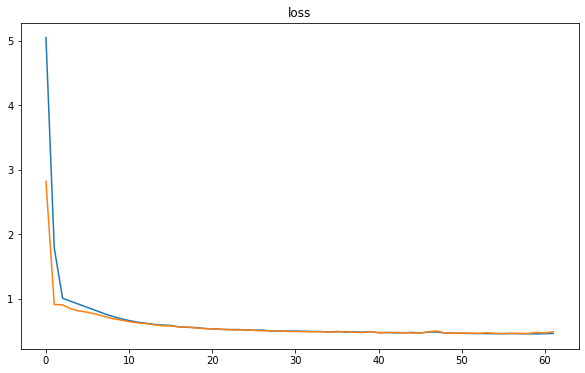

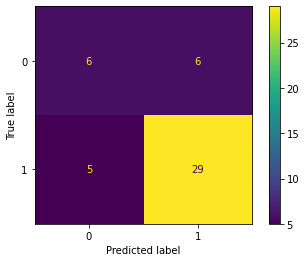

Model for column C1G
Epoch 1/300
23/23 [==============================] - 1s 11ms/step - loss: 1.0055 - accuracy: 0.5054 - val_loss: 0.7674 - val_accuracy: 0.5652
Epoch 2/300
23/23 [==============================] - 0s 2ms/step - loss: 0.8819 - accuracy: 0.4620 - val_loss: 0.6742 - val_accuracy: 0.5870
Epoch 3/300
23/23 [==============================] - 0s 2ms/step - loss: 0.8155 - accuracy: 0.4946 - val_loss: 0.6588 - val_accuracy: 0.6087
Epoch 4/300
23/23 [==============================] - 0s 3ms/step - loss: 0.7750 - accuracy: 0.5163 - val_loss: 0.6357 - val_accuracy: 0.6304
Epoch 5/300
23/23 [==============================] - 0s 3ms/step - loss: 0.7405 - accuracy: 0.5272 - val_loss: 0.6126 - val_accuracy: 0.6304
Epoch 6/300
23/23 [==============================] - 0s 3ms/step - loss: 0.6980 - accuracy: 0.5598 - val_loss: 0.5925 - val_accuracy: 0.6739
Epoch 7/300
23/23 [==============================] - 0s 2ms/step - loss: 0.6731 - accuracy: 0.5734 - val_loss: 0.6089 - val_accuracy

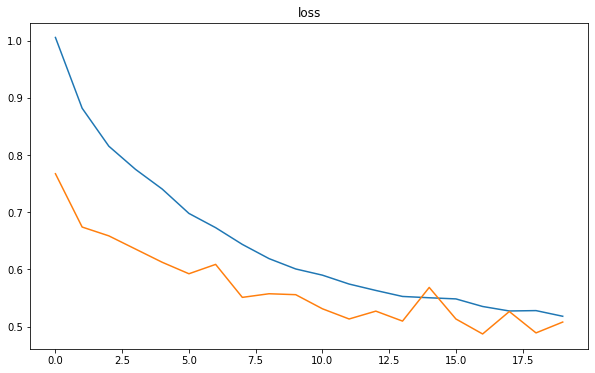

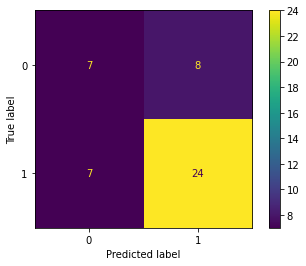

Model for column C2G
Epoch 1/300
23/23 [==============================] - 1s 11ms/step - loss: 1.1988 - accuracy: 0.8152 - val_loss: 0.9433 - val_accuracy: 0.7609
Epoch 2/300
23/23 [==============================] - 0s 3ms/step - loss: 0.6001 - accuracy: 0.8043 - val_loss: 0.4477 - val_accuracy: 0.8478
Epoch 3/300
23/23 [==============================] - 0s 3ms/step - loss: 0.5412 - accuracy: 0.7690 - val_loss: 0.4814 - val_accuracy: 0.8043
Epoch 4/300
23/23 [==============================] - 0s 3ms/step - loss: 0.5244 - accuracy: 0.7853 - val_loss: 0.4640 - val_accuracy: 0.8043
Epoch 5/300
23/23 [==============================] - 0s 3ms/step - loss: 0.5115 - accuracy: 0.7880 - val_loss: 0.4675 - val_accuracy: 0.8043
2/2 - 0s - loss: 0.4143 - accuracy: 0.8478 - 28ms/epoch - 14ms/step
[0.4143206477165222, 0.8478260636329651]
[0.4143206477165222, 0.8478260636329651]
MLP Discrimination for column C2G
Accuracy: 84.78260636329651


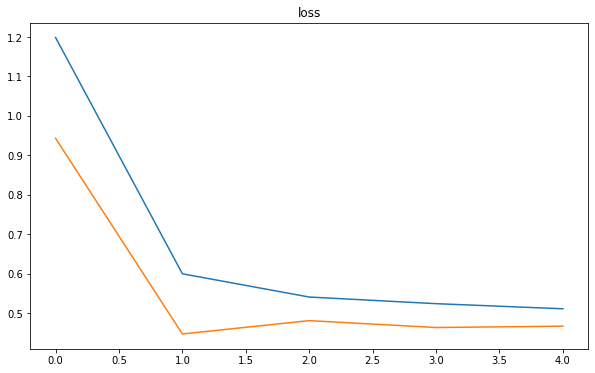

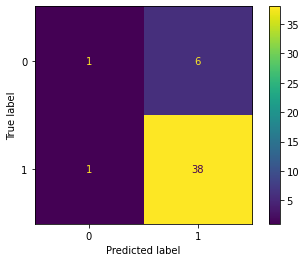

Model for column ES1G
Epoch 1/300
23/23 [==============================] - 1s 12ms/step - loss: 0.9684 - accuracy: 0.6060 - val_loss: 0.6357 - val_accuracy: 0.5870
Epoch 2/300
23/23 [==============================] - 0s 4ms/step - loss: 0.6911 - accuracy: 0.5978 - val_loss: 0.6226 - val_accuracy: 0.5870
Epoch 3/300
23/23 [==============================] - 0s 3ms/step - loss: 0.6436 - accuracy: 0.6467 - val_loss: 0.6053 - val_accuracy: 0.6739
Epoch 4/300
23/23 [==============================] - 0s 3ms/step - loss: 0.6066 - accuracy: 0.6630 - val_loss: 0.6087 - val_accuracy: 0.6739
Epoch 5/300
23/23 [==============================] - 0s 4ms/step - loss: 0.5785 - accuracy: 0.6821 - val_loss: 0.5898 - val_accuracy: 0.6739
Epoch 6/300
23/23 [==============================] - 0s 3ms/step - loss: 0.5542 - accuracy: 0.7011 - val_loss: 0.6015 - val_accuracy: 0.6957
Epoch 7/300
23/23 [==============================] - 0s 3ms/step - loss: 0.5412 - accuracy: 0.7174 - val_loss: 0.6536 - val_accurac

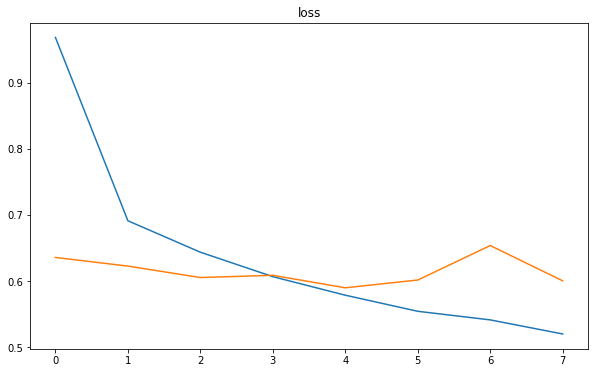

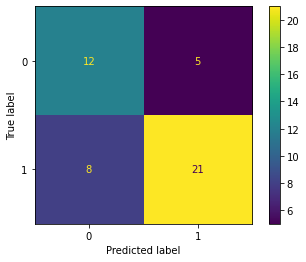

Model for column ES2G
Epoch 1/300
23/23 [==============================] - 1s 11ms/step - loss: 0.9029 - accuracy: 0.5380 - val_loss: 0.7429 - val_accuracy: 0.6522
Epoch 2/300
23/23 [==============================] - 0s 4ms/step - loss: 0.7582 - accuracy: 0.6168 - val_loss: 0.7153 - val_accuracy: 0.5870
Epoch 3/300
23/23 [==============================] - 0s 4ms/step - loss: 0.7094 - accuracy: 0.6386 - val_loss: 0.6497 - val_accuracy: 0.6304
Epoch 4/300
23/23 [==============================] - 0s 4ms/step - loss: 0.6725 - accuracy: 0.6413 - val_loss: 0.5628 - val_accuracy: 0.6522
Epoch 5/300
23/23 [==============================] - 0s 3ms/step - loss: 0.6193 - accuracy: 0.6630 - val_loss: 0.5278 - val_accuracy: 0.7174
Epoch 6/300
23/23 [==============================] - 0s 3ms/step - loss: 0.5848 - accuracy: 0.6793 - val_loss: 0.5159 - val_accuracy: 0.7826
Epoch 7/300
23/23 [==============================] - 0s 3ms/step - loss: 0.5574 - accuracy: 0.7092 - val_loss: 0.4374 - val_accurac

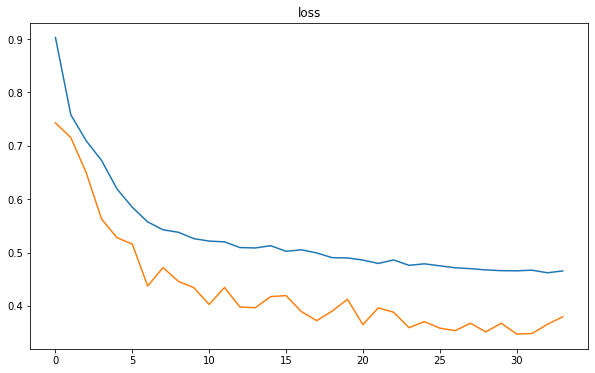

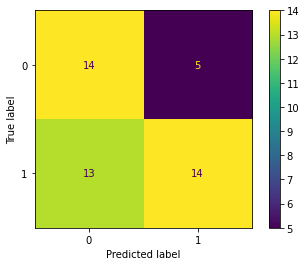

Model for column O1G
Epoch 1/300
23/23 [==============================] - 1s 11ms/step - loss: 0.6943 - accuracy: 0.6875 - val_loss: 0.5885 - val_accuracy: 0.6957
Epoch 2/300
23/23 [==============================] - 0s 3ms/step - loss: 0.6065 - accuracy: 0.6467 - val_loss: 0.5615 - val_accuracy: 0.6957
Epoch 3/300
23/23 [==============================] - 0s 3ms/step - loss: 0.5837 - accuracy: 0.6549 - val_loss: 0.5540 - val_accuracy: 0.6957
Epoch 4/300
23/23 [==============================] - 0s 3ms/step - loss: 0.5756 - accuracy: 0.6793 - val_loss: 0.5523 - val_accuracy: 0.7174
Epoch 5/300
23/23 [==============================] - 0s 3ms/step - loss: 0.5705 - accuracy: 0.6766 - val_loss: 0.5531 - val_accuracy: 0.7391
Epoch 6/300
23/23 [==============================] - 0s 3ms/step - loss: 0.5596 - accuracy: 0.6712 - val_loss: 0.5510 - val_accuracy: 0.7174
Epoch 7/300
23/23 [==============================] - 0s 2ms/step - loss: 0.5521 - accuracy: 0.6848 - val_loss: 0.5529 - val_accuracy

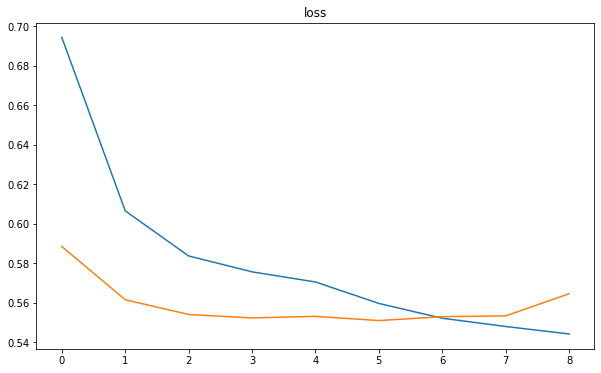

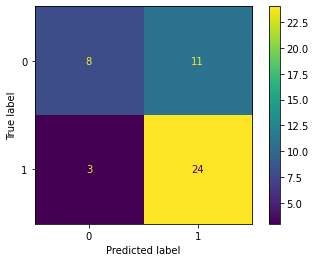

Model for column O2G
Epoch 1/300
23/23 [==============================] - 1s 10ms/step - loss: 0.7841 - accuracy: 0.5788 - val_loss: 0.8754 - val_accuracy: 0.5652
Epoch 2/300
23/23 [==============================] - 0s 3ms/step - loss: 0.7379 - accuracy: 0.6359 - val_loss: 0.7914 - val_accuracy: 0.5000
Epoch 3/300
23/23 [==============================] - 0s 2ms/step - loss: 0.6885 - accuracy: 0.6766 - val_loss: 0.7658 - val_accuracy: 0.6087
Epoch 4/300
23/23 [==============================] - 0s 2ms/step - loss: 0.6556 - accuracy: 0.6848 - val_loss: 0.7102 - val_accuracy: 0.5435
Epoch 5/300
23/23 [==============================] - 0s 3ms/step - loss: 0.6234 - accuracy: 0.6821 - val_loss: 0.7046 - val_accuracy: 0.6087
Epoch 6/300
23/23 [==============================] - 0s 3ms/step - loss: 0.5967 - accuracy: 0.7201 - val_loss: 0.6769 - val_accuracy: 0.6304
Epoch 7/300
23/23 [==============================] - 0s 4ms/step - loss: 0.5664 - accuracy: 0.7120 - val_loss: 0.6889 - val_accuracy

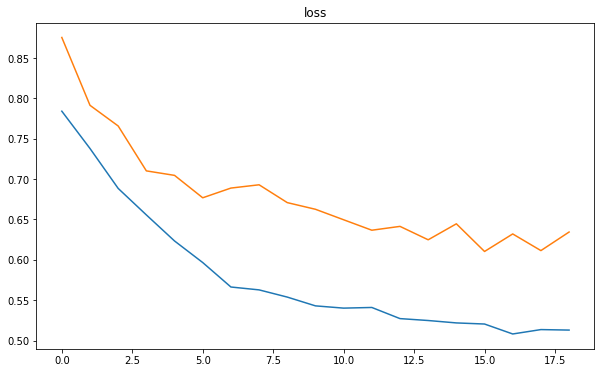

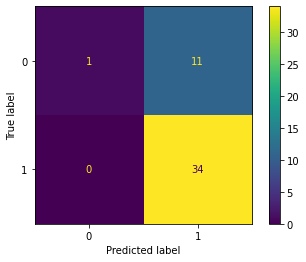

In [ ]:
# MLP Discrimination
per_question_accuracy_mlp = []
confusion_matrix_list = []

for col in faked.columns:
  if not(str(col) == 'CONDITION'):
    # Print
    print('Model for column ' + str(col))

    # Select output column
    faked_vector = faked_all[str(col)]*1
    faked_vector = faked_vector.astype(int)

    # Initialize lists
    scores = []

    # Split train, validation and test set
    X_train_, X_val_, y_train_, y_val_ = train_test_split(df.drop(columns='CONDITION'),  faked_vector, test_size = 0.2)
    X_val_, X_test_, y_val_, y_test_ = train_test_split(X_val_, y_val_, test_size = 0.5)

    # Define the model architecture
    model = Sequential()
    model.add(Dense(32, activation='relu', kernel_initializer = HeNormal()))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Create early stopping callback
    callback = EarlyStopping(monitor='val_loss', patience=3)

    # Fit data to model
    history = model.fit(X_train_, y_train_,
                  batch_size=16,
                  epochs=300,
                  callbacks = [callback],
                  validation_data=(X_val_, y_val_)
                  )
      
    # Plot the learning curves
    plot_loss(history)

    # Print evaluation metrics
    score = model.evaluate(X_test_, y_test_, verbose=2)
    print(score)
    per_question_accuracy_mlp.append(score[1])
    print(score)
    print("MLP Discrimination for column " + str(col))
    print("Accuracy: " + str(score[1]*100))

    # Create confusion matrix and append to list conf_matrix_list_of_arrays
    preds = model.predict(X_test_)
    pred_class = (preds > 0.5).astype('int')
    conf_matrix = confusion_matrix(y_test_, pred_class)
    confusion_matrix_list.append(conf_matrix)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot()
    plt.show()


[0.782608687877655, 0.8260869383811951, 0.695652186870575, 0.760869562625885, 0.6739130616188049, 0.8478260636329651, 0.717391312122345, 0.6086956262588501, 0.695652186870575, 0.760869562625885]
Accuracy: 0.782608687877655


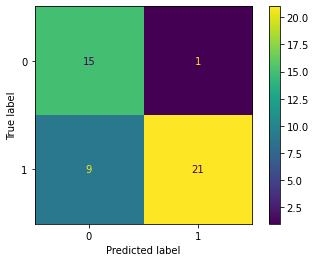

Accuracy: 0.8260869383811951


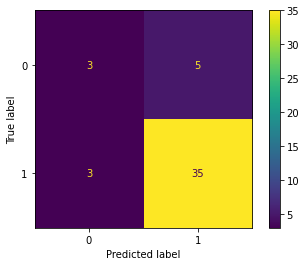

Accuracy: 0.695652186870575


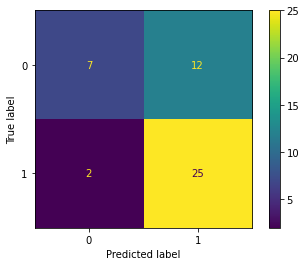

Accuracy: 0.760869562625885


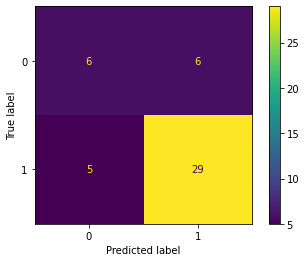

Accuracy: 0.6739130616188049


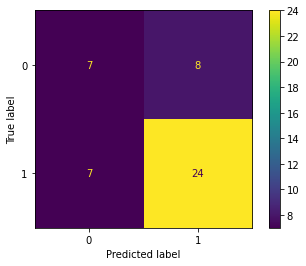

Accuracy: 0.8478260636329651


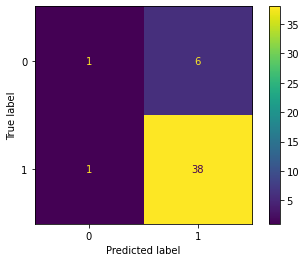

Accuracy: 0.717391312122345


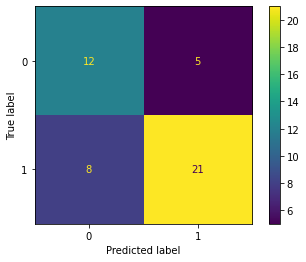

Accuracy: 0.6086956262588501


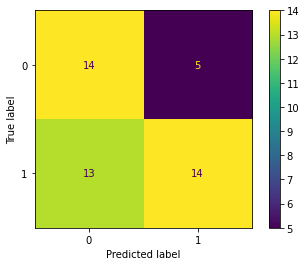

Accuracy: 0.695652186870575


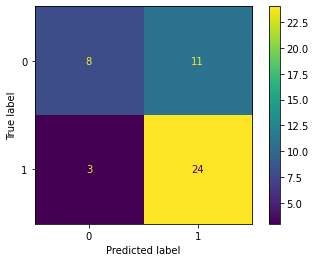

Accuracy: 0.760869562625885


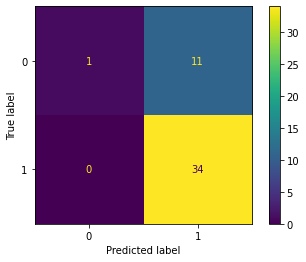

In [ ]:
print(per_question_accuracy_mlp)
for cm, ac in zip(confusion_matrix_list, per_question_accuracy_mlp):
  print('Accuracy: ' + str(ac))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show()


In [ ]:
per_question_accuracy_mlp


[0.782608687877655,
 0.8260869383811951,
 0.695652186870575,
 0.760869562625885,
 0.6739130616188049,
 0.8478260636329651,
 0.717391312122345,
 0.6086956262588501,
 0.695652186870575,
 0.760869562625885]

### Only faked responses

Here we tried to consider if the model would perform better considering only the faked responses. 

RF_per_question EX1G Discrimination - Grid Search Results
{'max_depth': 6}
RF_per_question EX1G Discrimination - Cross Validation Results
Mean Accuracy 64.35%
STD Accuracy 8.87%


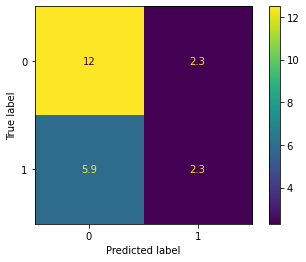

RF_per_question EX2G Discrimination - Grid Search Results
{'max_depth': 3}
RF_per_question EX2G Discrimination - Cross Validation Results
Mean Accuracy 62.17%
STD Accuracy 9.54%


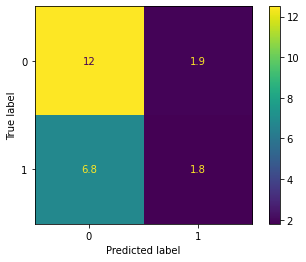

RF_per_question A1G Discrimination - Grid Search Results
{'max_depth': 6}
RF_per_question A1G Discrimination - Cross Validation Results
Mean Accuracy 73.04%
STD Accuracy 10.07%


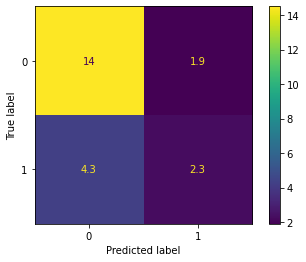

RF_per_question A2G Discrimination - Grid Search Results
{'max_depth': 9}
RF_per_question A2G Discrimination - Cross Validation Results
Mean Accuracy 66.09%
STD Accuracy 10.96%


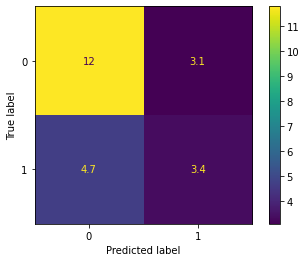

RF_per_question C1G Discrimination - Grid Search Results
{'max_depth': 6}
RF_per_question C1G Discrimination - Cross Validation Results
Mean Accuracy 74.35%
STD Accuracy 8.79%


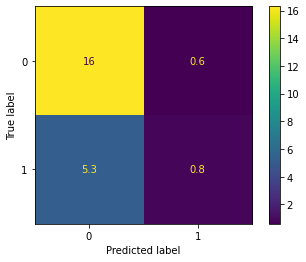

RF_per_question C2G Discrimination - Grid Search Results
{'max_depth': 3}
RF_per_question C2G Discrimination - Cross Validation Results
Mean Accuracy 69.57%
STD Accuracy 8.48%


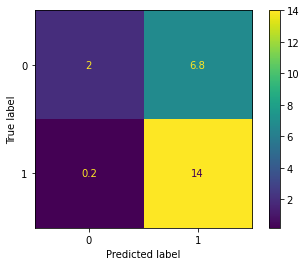

RF_per_question ES1G Discrimination - Grid Search Results
{'max_depth': 3}
RF_per_question ES1G Discrimination - Cross Validation Results
Mean Accuracy 75.22%
STD Accuracy 5.52%


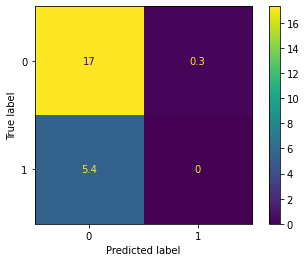

RF_per_question ES2G Discrimination - Grid Search Results
{'max_depth': 8}
RF_per_question ES2G Discrimination - Cross Validation Results
Mean Accuracy 73.48%
STD Accuracy 10.19%


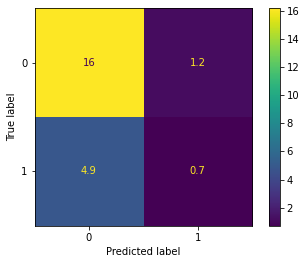

RF_per_question O1G Discrimination - Grid Search Results
{'max_depth': 3}
RF_per_question O1G Discrimination - Cross Validation Results
Mean Accuracy 62.61%
STD Accuracy 10.14%


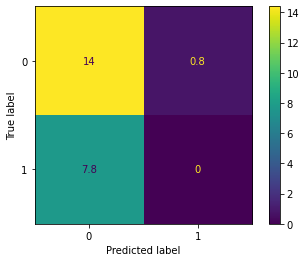

RF_per_question O2G Discrimination - Grid Search Results
{'max_depth': 8}
RF_per_question O2G Discrimination - Cross Validation Results
Mean Accuracy 51.3%
STD Accuracy 7.48%


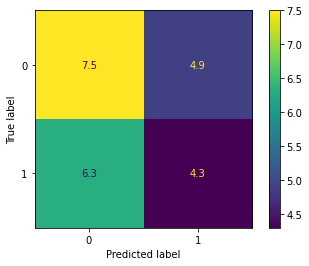

In [ ]:
# Random Forest for discriminate H/D for each question
per_question_accuracy_rf = []

# Repeat detecting between H/D per each column
for col in faked.columns:
  if not(str(col) == 'CONDITION'):

    # Select output column
    faked_vector = faked[[str(col)]]

    # Initialize dictionary of parameters to search
    params = [{'max_depth': [3,4,5,6,7,8,9]}]

    # Run grid search
    model_name = 'RF_per_question ' + str(col)
    model = RandomForestClassifier(random_state=0)
    gs_params = grid_search(model, model_name, params, X = dishonest_t,  y = np.array(faked_vector).reshape(faked_vector.shape[0],))

    # Initialize optimal model and model_name
    model = RandomForestClassifier(max_depth=gs_params['max_depth'],random_state=0)

    # Run cross validation, output evaluation metrics and append accuracy to list
    rf_results = model_cv_fit_eval(model,model_name, dishonest_t,  faked_vector)
    per_question_accuracy_rf.append(rf_results[1])

In [ ]:
# Average accuracy per question
np.mean(per_question_accuracy_rf)

0.6721739130434783

In [ ]:
faked.drop(columns = 'CONDITION')

EX1G   EX2G    A1G    A2G    C1G    C2G   ES1G   ES2G    O1G    O2G
0    False  False  False  False  False  False  False  False  False  False
1    False  False  False   True   True   True  False  False   True   True
2     True   True  False  False  False   True  False   True  False  False
3    False   True  False  False  False  False  False  False  False   True
4     True   True  False  False   True   True  False  False  False  False
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
225  False  False  False  False   True   True  False  False  False  False
226  False  False  False  False  False  False   True  False  False   True
227  False  False  False  False   True  False   True  False   True   True
228  False  False  False  False  False   True  False  False  False  False
229   True   True  False   True   True   True   True   True  False   True

[230 rows x 10 columns]

Another method was tried with the same approach: K Nearest Neighbors.

KNN Discrimination - Cross Validation Results
Mean Accuracy 61.3%
STD Accuracy 9.01%


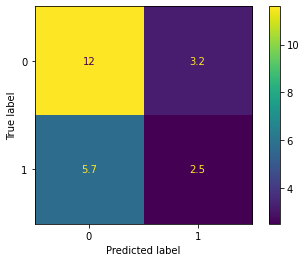

KNN Discrimination - Cross Validation Results
Mean Accuracy 55.65%
STD Accuracy 7.48%


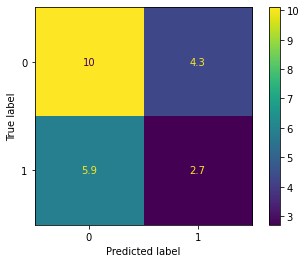

KNN Discrimination - Cross Validation Results
Mean Accuracy 72.17%
STD Accuracy 10.14%


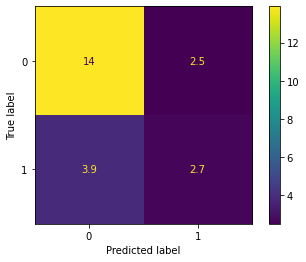

KNN Discrimination - Cross Validation Results
Mean Accuracy 59.57%
STD Accuracy 3.91%


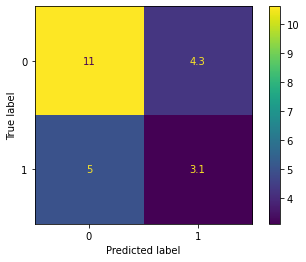

KNN Discrimination - Cross Validation Results
Mean Accuracy 70.87%
STD Accuracy 6.75%


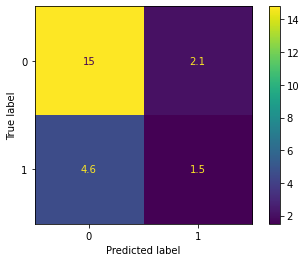

KNN Discrimination - Cross Validation Results
Mean Accuracy 64.35%
STD Accuracy 8.65%


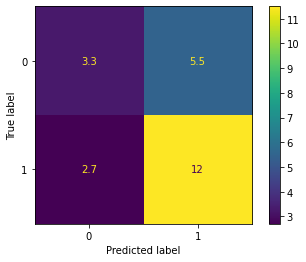

KNN Discrimination - Cross Validation Results
Mean Accuracy 73.48%
STD Accuracy 8.58%


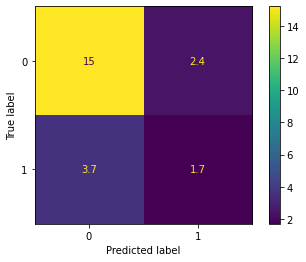

KNN Discrimination - Cross Validation Results
Mean Accuracy 71.3%
STD Accuracy 5.57%


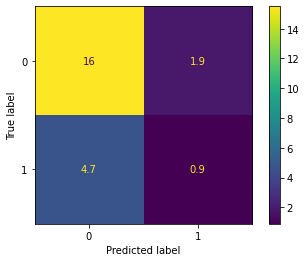

KNN Discrimination - Cross Validation Results
Mean Accuracy 58.7%
STD Accuracy 11.04%


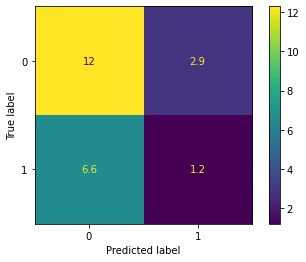

KNN Discrimination - Cross Validation Results
Mean Accuracy 52.17%
STD Accuracy 8.91%


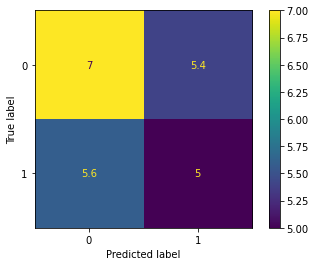

In [ ]:
per_question_accuracy_knn = []

for col in faked.columns:
  if not(str(col) == 'CONDITION'):

    # Select output column
    faked_vector = faked[[str(col)]]

    # Initialize dictionary of parameters to search
    params = [{'n_neighbors': [3, 5, 7, 9],
         'weights': ['uniform', 'distance']}]

    # Run grid search
    model_name = 'KNN_per_question ' + str(col)
    model = KNeighborsClassifier()
    # gs_params = grid_search(model,params, dishonest_t, np.array(faked_vector).reshape(faked_vector.shape[0],))

    # Initialize optimal model and model_name
    # model = KNeighborsClassifier(n_neighbors=gs_params['n_neighbors'], weights=gs_params['weights'])
    model_name = 'KNN'

    # Run cross validation, output evaluation metrics and append accuracy to list
    knn_results = model_cv_fit_eval(model,model_name, dishonest_t, faked_vector)
    per_question_accuracy_knn.append(knn_results[1])



### Compare Results per question

In [ ]:
per_question_scores = pd.DataFrame()
per_question_scores['RF'] = per_question_accuracy_rf
per_question_scores['KNN'] = per_question_accuracy_knn

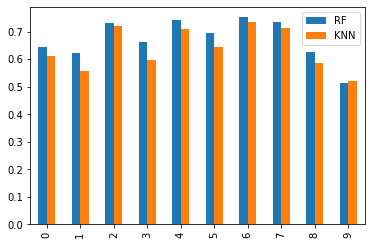

In [ ]:
per_question_scores.plot.bar()

In [ ]:
per_question_scores_all = pd.DataFrame()

per_question_scores_all['TF-IDF'] = per_question_accuracy_tfidf
per_question_scores_all['LR'] = per_question_accuracy_lr_all
per_question_scores_all['RF'] = per_question_accuracy_rf_all
per_question_scores_all['KNN'] = per_question_accuracy_knn_all
per_question_scores_all['MLP'] = per_question_accuracy_mlp

# per_question_scores_all.plot.bar().legend(loc='center left',bbox_to_anchor=(1.0, 0.5))


Average accuracy per question of model TF-IDF: 0.5847826086956521
Average accuracy per question of model LR: 0.7780434782608696
Average accuracy per question of model RF: 0.7917391304347825
Average accuracy per question of model KNN: 0.7728260869565218
Average accuracy per question of model MLP: 0.7369565188884735


[]

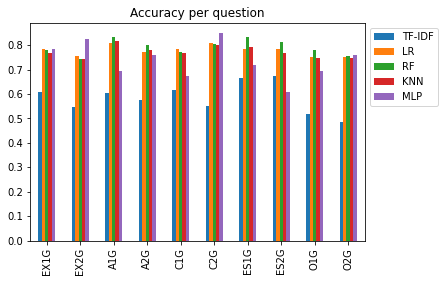

In [ ]:
for col in per_question_scores_all.columns:
  print('Average accuracy per question of model ' + str(col) +': ' + str(per_question_scores_all[str(col)].mean()))
  
ax = per_question_scores_all.plot.bar()
ax.set_title("Accuracy per question",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_xticklabels(input_variables)
ax.plot()

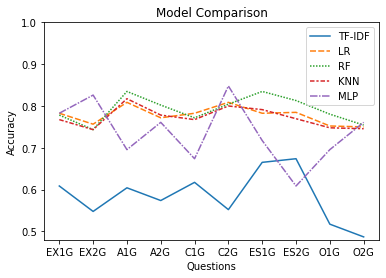

In [ ]:
_ = sns.lineplot(data=per_question_scores_all) #, x="Quest", y="value", hue="CONFUSION_CLASS",
                 #palette=["C0", "g", "r", "orange"])
_.set_xticklabels(input_variables)
_.set_xlabel('Questions')
_.set_ylabel('Accuracy')
_.set_title('Model Comparison')
_.set(ylim=(0.48, 1))

#_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
_ = plt.xticks(range(0,10))

In [ ]:
per_question_sd_all = pd.DataFrame()

#per_question_sd_all['TF-IDF'] = per_question_accuracy_tfidf
per_question_sd_all['LR'] = per_question_sd_lr_all
per_question_sd_all['RF'] = per_question_sd_rf_all
per_question_sd_all['KNN'] = per_question_sd_knn_all
#per_question_sd_all['MLP'] = per_question_sd_mlp

for col in per_question_sd_all.columns:
  print('Average accuracy per question of model ' + str(col) +': ' + str(per_question_sd_all[str(col)].mean()))

Average accuracy per question of model LR: 0.0543408654843617
Average accuracy per question of model RF: 0.05625416870270501
Average accuracy per question of model KNN: 0.05633889851813104


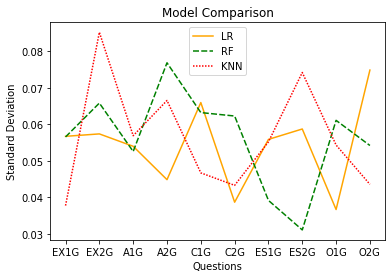

In [ ]:
_ = sns.lineplot(data=per_question_sd_all, palette=["orange", "g", "r"]) #, x="Quest", y="value", hue="CONFUSION_CLASS",
                 #palette=["C0", "g", "r", "orange"])
_.set_xticklabels(input_variables)
_.set_xlabel('Questions')
_.set_ylabel('Standard Deviation')
_.set_title('Model Comparison')
#_.set(ylim=(0.48, 1))

#_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
_ = plt.xticks(range(0,10))

## Reconstruction

In this section we went through the problem of reconstring the honest questionnaires given the dishonest ones. 
We tried different approaches in order to do so, from non parametric methods (feature spreading) to modeling $P(x_H|x)$ (denoising autoencoders) or $P(x_H,x_D)$ (graphical model). 

As an evaluation we decided to costruct estimators for the probability of exact reconstruction question-wise for each one of the models using cross validation. As a collateral advantage, this approach also gives us a measure of uncertainty for the estimators.

We compared the trivial reconstruction strategy with feature spreading and the two versions of denoising autoencoder both questionwise and overall.

This lead us in choosing the probabilistic CNN denoising autoencoder as the best reconstruction model overall, with a probility of correct reconstruction of $44.3\%$ on average over all questions.


### Denoising Autoencoder
Performs worse than average adjusting

In [ ]:
input = keras.Input(shape=(10,))
encoded = keras.layers.Dense(8, activation='relu')(input)
encoded = keras.layers.Dense(6, activation='relu')(input)
encoded = keras.layers.Dense(3, activation='relu')(encoded)

decoded = keras.layers.Dense(6, activation='relu')(encoded)
decoded = keras.layers.Dense(8, activation='relu')(encoded)
decoded = keras.layers.Dense(10, activation='linear')(decoded)

denoise_autoencoder = keras.Model(input, decoded)
denoise_autoencoder.compile(optimizer='adam', loss='mse')

history = denoise_autoencoder.fit(X_train_noise, X_train_honest,
                epochs=100,
                batch_size=10,
                shuffle=True,
                validation_data=(X_val_noise, X_val_honest))

Epoch 1/100
21/21 [==============================] - 1s 8ms/step - loss: 11.6019 - val_loss: 11.1920
Epoch 2/100
21/21 [==============================] - 0s 2ms/step - loss: 9.7735 - val_loss: 9.4871
Epoch 3/100
21/21 [==============================] - 0s 2ms/step - loss: 8.0785 - val_loss: 7.7561
Epoch 4/100
21/21 [==============================] - 0s 2ms/step - loss: 6.3633 - val_loss: 6.1452
Epoch 5/100
21/21 [==============================] - 0s 2ms/step - loss: 4.8874 - val_loss: 4.8569
Epoch 6/100
21/21 [==============================] - 0s 2ms/step - loss: 3.7430 - val_loss: 3.8927
Epoch 7/100
21/21 [==============================] - 0s 3ms/step - loss: 2.9105 - val_loss: 3.1948
Epoch 8/100
21/21 [==============================] - 0s 2ms/step - loss: 2.3236 - val_loss: 2.6916
Epoch 9/100
21/21 [==============================] - 0s 3ms/step - loss: 1.9185 - val_loss: 2.3354
Epoch 10/100
21/21 [==============================] - 0s 3ms/step - loss: 1.6467 - val_loss: 2.0912
Epoch 1

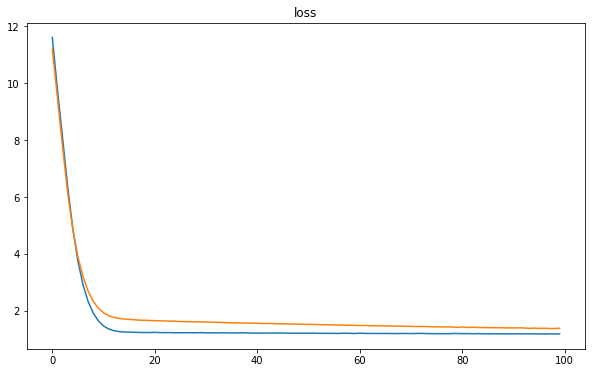

In [ ]:
plot_loss(history)

[0.42 0.37 0.28 0.42 0.2  0.55 0.24 0.23 0.4  0.22]
[ 0.19  0.    0.14  0.07  0.03  0.    0.17 -0.01  0.15 -0.05]
0.33
0.07


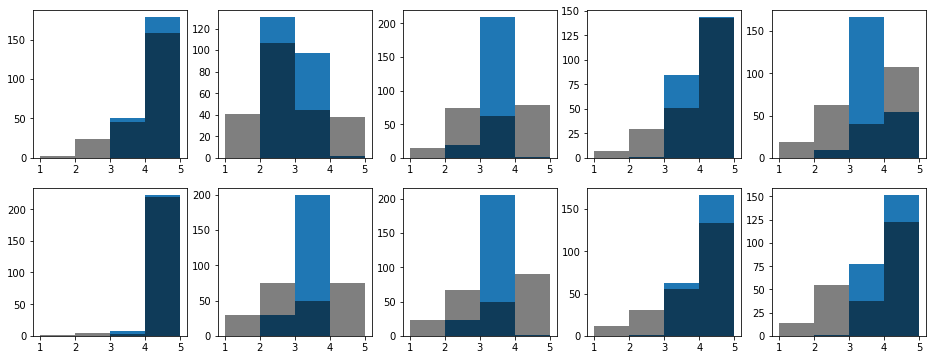

In [ ]:
pred = denoise_autoencoder.predict(X_noise)
acc_q, acc_t, pred_likert = calculate_accuracy(pred,X_honest)
print(np.round(acc_q,2))
print(np.round(acc_q-bench_q,2))

print(np.round(acc_t,2))
print(np.round(acc_t-bench_t,2))

plt.figure(figsize=(16,6))
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.hist(pred_likert[:,i], bins=[1,2,3,4,5])
  plt.hist(X_honest[:,i], bins=[1,2,3,4,5], fc=(0, 0, 0, 0.5))

In [ ]:
from tensorflow.keras.layers import Dense
from sklearn.model_selection import KFold

# Initialize lists
acc_per_fold_q = []
acc_per_fold_t = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X_noise, X_honest):

  input = keras.Input(shape=(10,))
  encoded = Dense(8, activation='relu')(input)
  encoded = Dense(6, activation='relu')(input)
  encoded = Dense(3, activation='relu')(encoded)

  decoded = Dense(6, activation='relu')(encoded)
  decoded = Dense(8, activation='relu')(encoded)
  decoded = Dense(10, activation='linear')(decoded)

  denoise_autoencoder = keras.Model(input, decoded)
  denoise_autoencoder.compile(optimizer='adam', loss='mse')

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  idx = round(len(test)/2)
  print(idx)

  val = test[:idx]
  test2 = test[idx:]

  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

  # Fit data to model 
  history = denoise_autoencoder.fit(X_noise[train], X_honest[train],
                epochs=300,
                batch_size=16,
                shuffle=True,
                callbacks = [callback],
                validation_data=(X_noise[val], X_honest[val]))

  # Generate generalization metrics
  pred = denoise_autoencoder.predict(X_noise[test2])
  acc_q, acc_t, pred_likert = calculate_accuracy(pred,X_honest[test2])
  acc_per_fold_q.append(acc_q)
  acc_per_fold_t.append(acc_t)

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
12
Epoch 1/300
13/13 [==============================] - 1s 15ms/step - loss: 17.9501 - val_loss: 16.1634
Epoch 2/300
13/13 [==============================] - 0s 4ms/step - loss: 15.2798 - val_loss: 14.3830
Epoch 3/300
13/13 [==============================] - 0s 3ms/step - loss: 13.8778 - val_loss: 13.4193
Epoch 4/300
13/13 [==============================] - 0s 3ms/step - loss: 13.0926 - val_loss: 12.7411
Epoch 5/300
13/13 [==============================] - 0s 3ms/step - loss: 12.5586 - val_loss: 12.1585
Epoch 6/300
13/13 [==============================] - 0s 3ms/step - loss: 12.0838 - val_loss: 11.6179
Epoch 7/300
13/13 [==============================] - 0s 3ms/step - loss: 11.5895 - val_loss: 11.0687
Epoch 8/300
13/13 [==============================] - 0s 3ms/step - loss: 11.0316 - val_loss: 10.4885
Epoch 9/300
13/13 [==============================] - 0s 3ms/step - loss: 10.3356 - val_loss

In [ ]:
print(np.array(acc_per_fold_q).mean(axis=0))
print(np.array(acc_per_fold_t).mean())

[0.42727273 0.30909091 0.29090909 0.46363636 0.21818182 0.53636364
 0.21818182 0.21818182 0.34545455 0.21818182]
0.3245454545454545


### Graphical Lasso for the joint honest-dishonest distribution


This section was useful for us as a preliminary analysis in order to try to capture what was people's strategy of lying by using the data.

The first thing we tried was a graphical model for the joint honest-dishonest questionnaires of a single person, since the joint covariance matrix was showing an evident difference in behaviour between liars and honest people.


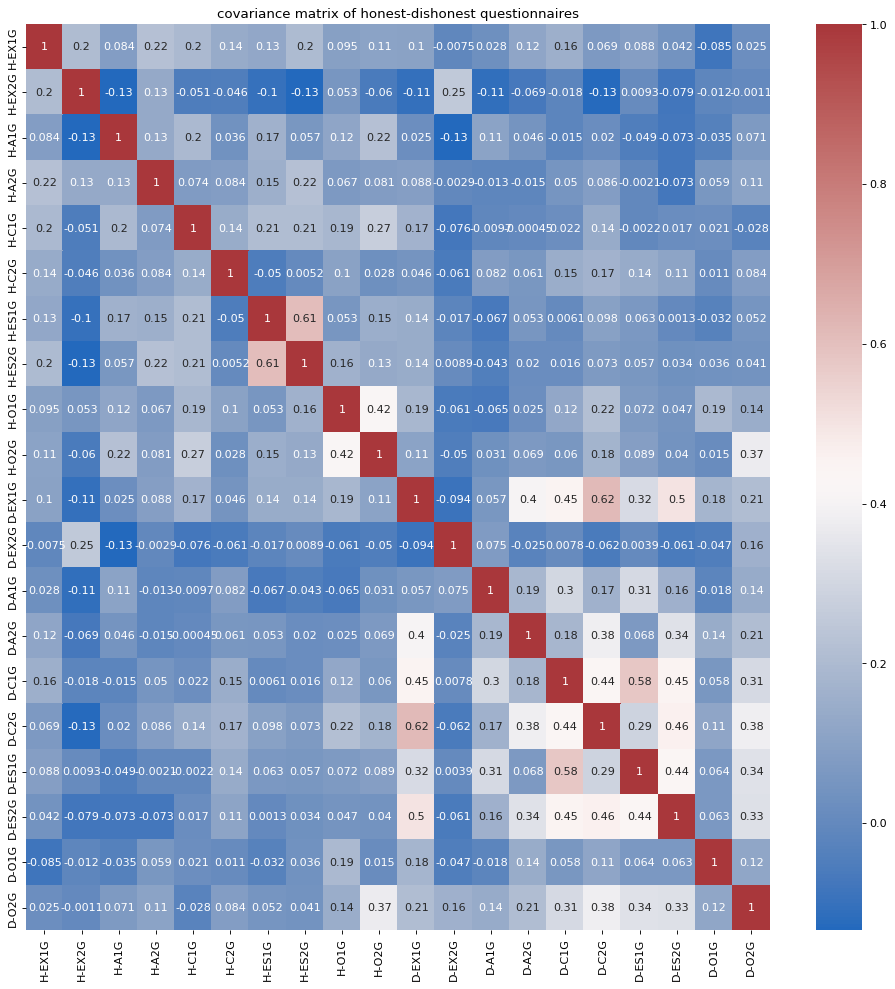

In [ ]:
# joint honest-dishonest correlation matrix

n_obs = X.shape[0]

current_palette = sns.color_palette("vlag", as_cmap=True)
corr = np.corrcoef(x = X[0:n_obs//2], y = X[n_obs//2:n_obs] ,rowvar= False)  
matrix = np.triu(corr)
fig = plt.figure(figsize=(15,15), dpi = 80)
hm = sns.heatmap( pd.DataFrame(corr,columns=['H-EX1G','H-EX2G','H-A1G','H-A2G','H-C1G','H-C2G','H-ES1G','H-ES2G','H-O1G','H-O2G','D-EX1G','D-EX2G','D-A1G','D-A2G','D-C1G','D-C2G','D-ES1G','D-ES2G','D-O1G','D-O2G'],
                         index = ['H-EX1G','H-EX2G','H-A1G','H-A2G','H-C1G','H-C2G','H-ES1G','H-ES2G','H-O1G','H-O2G','D-EX1G','D-EX2G','D-A1G','D-A2G','D-C1G','D-C2G','D-ES1G','D-ES2G','D-O1G','D-O2G'] ) ,
                 cmap=current_palette,annot = True)
plt.title('correlation matrix of honest-dishonest questionnaires')
plt.show()

The questionnaires of dishonest people seem to be more "structured", this can be seen looking the two diagonal blocks of the covariance matrix: higher correlations between dishonest answers.

To avoid having to code all the backpropagation with the MCMC part without having any hint on the goodness of the idea, we tried a Gaussian graphical model (even if the variables do not perfectly fit this assumption) just to see what it tells us. All this has been done under the hypothesis that the questionnaires are coupled, so that the $x_{merged}^{(i)}=(x^{(i)},x^{(i+230)})$ are the two different realizations of an honest-dishonest questionnaries from the same person.
We used a Lasso regularization to see if there are significant links within on inner to the two communities of the graphical model, in the affermative case they will tell us information about the way in which people decided to lie.

An important assumption of this method we're implicitly doing is that the distribution in the joint space is unimodal (this will be important in a future part of the presentation).

In [ ]:
# Merge hidden and visible (honest and dishonest)

X_merged = np.hstack([X[0:X.shape[0]//2],X[X.shape[0]//2:X.shape[0]]])

mu = np.mean(X_merged,axis=0)

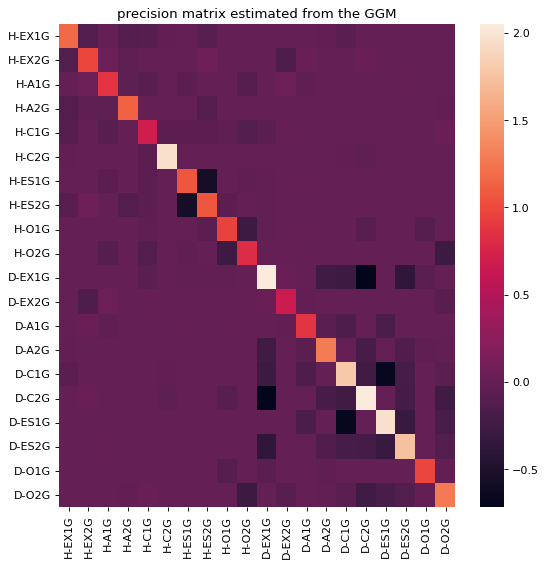


------------------------------------------
best CV alpha: 0.01


In [ ]:
model = GraphicalLassoCV()   # choice of the regularization parameter done using CV

model.fit(X_merged)

prec = model.get_precision()


fig = plt.figure(figsize=(8,8), dpi = 80)
sns.heatmap(pd.DataFrame(prec,
                         columns=['H-EX1G','H-EX2G','H-A1G','H-A2G','H-C1G','H-C2G','H-ES1G','H-ES2G','H-O1G','H-O2G','D-EX1G','D-EX2G','D-A1G','D-A2G','D-C1G','D-C2G','D-ES1G','D-ES2G','D-O1G','D-O2G'],
                         index = ['H-EX1G','H-EX2G','H-A1G','H-A2G','H-C1G','H-C2G','H-ES1G','H-ES2G','H-O1G','H-O2G','D-EX1G','D-EX2G','D-A1G','D-A2G','D-C1G','D-C2G','D-ES1G','D-ES2G','D-O1G','D-O2G'],
                         ))
plt.title('precision matrix estimated from the GGM')
plt.show()

print('\n------------------------------------------')
print('best CV alpha:',model.alpha)

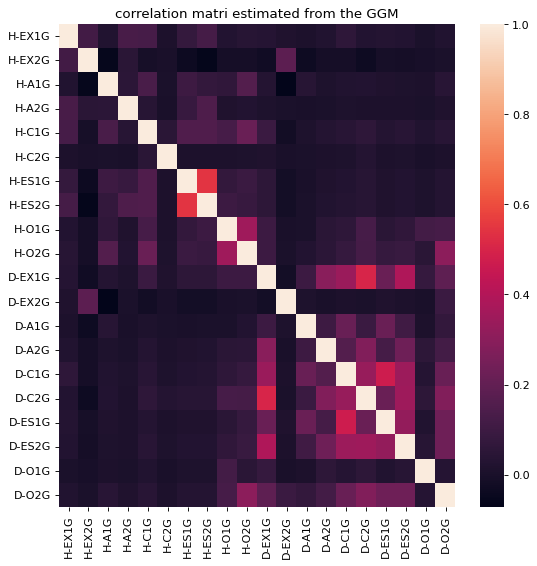

In [ ]:
cov = np.linalg.inv(prec)  #covariance matrix of the fitted GGM

corr = cov/np.outer(np.sqrt(np.diag(cov)),np.sqrt(np.diag(cov)))   #correlation matrix estimated from the GGM

fig = plt.figure(figsize=(8,8), dpi = 80)
sns.heatmap(pd.DataFrame(corr,
                         columns=['H-EX1G','H-EX2G','H-A1G','H-A2G','H-C1G','H-C2G','H-ES1G','H-ES2G','H-O1G','H-O2G','D-EX1G','D-EX2G','D-A1G','D-A2G','D-C1G','D-C2G','D-ES1G','D-ES2G','D-O1G','D-O2G'],
                         index = ['H-EX1G','H-EX2G','H-A1G','H-A2G','H-C1G','H-C2G','H-ES1G','H-ES2G','H-O1G','H-O2G','D-EX1G','D-EX2G','D-A1G','D-A2G','D-C1G','D-C2G','D-ES1G','D-ES2G','D-O1G','D-O2G']
                         ))
plt.title('correlation matri estimated from the GGM')
plt.show()

From the fitting of this model (again under the "coupling" hypothesis) we can tell that it seems that there's no evident strategy in trying to lie to reach the goal, we can see this by the fact that the blocks $(D,H)$ and $(H,D)$ are almost completely sparse in both matrices. Interestingly, it seems that the correlation structure of the questionnaire changes a lot conditioning on the lying condition, this can be seen by comparing the $(H,H)$ and the $(D,D)$ blocks (the first is almost sparse, the second is not at all).

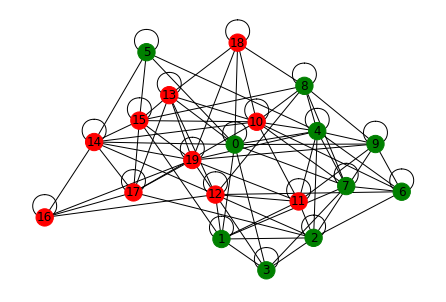

In [ ]:
# estimated graphical model, red dots are dishonest questions and gren one are honest ones

G = ntx.from_numpy_matrix(prec, create_using=ntx.Graph())

# Use spring_layout to handle positioning of graph
layout = ntx.spring_layout(G,weight = None,k=0.1)


# Use a list for node colours
color_map = ['g']*10+['r']*10

# Draw the graph using the layout - with_labels=True if you want node labels.
ntx.draw(G, layout,node_color=color_map,with_labels=True)


# Draw edge labels using layout and list of labels
ntx.draw_networkx_edge_labels(G,pos=layout,edge_labels={})

# Show plot
plt.show()

variable names:
   H-EX1G,H-EX2G,H-A1G,H-A2G,H-C1G,H-C2G,H-ES1G,H-ES2G,H-O1G,H-O2G


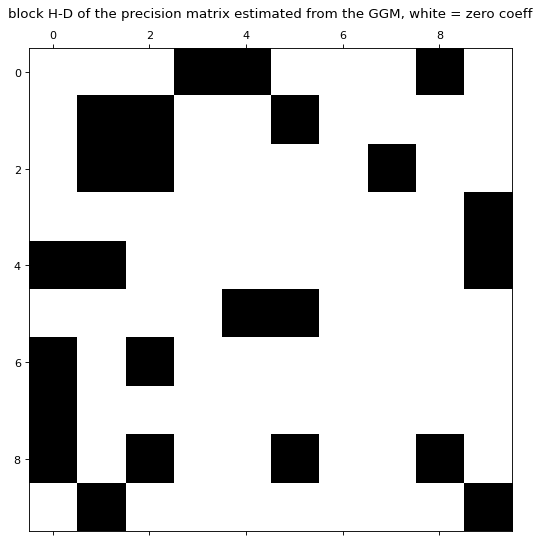


number of non zero coeffs:  24
total interaction coeffs: 100


In [ ]:
# plotting the spy to evidence where interactions were selected by the lasso

fig = plt.figure(figsize=(8,8), dpi = 80)
pd_prec = pd.DataFrame(prec[0:10,10:20],
                         columns=['H-EX1G','H-EX2G','H-A1G','H-A2G','H-C1G','H-C2G','H-ES1G','H-ES2G','H-O1G','H-O2G'],
                         index = ['D-EX1G','D-EX2G','D-A1G','D-A2G','D-C1G','D-C2G','D-ES1G','D-ES2G','D-O1G','D-O2G'],
                         )

plt.spy(pd_prec)
print('variable names:')
print('   H-EX1G,H-EX2G,H-A1G,H-A2G,H-C1G,H-C2G,H-ES1G,H-ES2G,H-O1G,H-O2G')
plt.title('block H-D of the precision matrix estimated from the GGM, white = zero coeff')
plt.show()

print('\nnumber of non zero coeffs: ',np.sum(prec[0:10,10:20]!=0))
print('total interaction coeffs: 100')

Interesting observation here, the graphical Lasso estimates significant "self" interactions among a question and its corresponding dishonest one only half of the times: this means that the model is suggesting that the decision of lying is not only reflected "question per question", but the decision of lying may be hiding a more complex behaviour.
This is an insight that the trivial strategy is too simplifying

variable names:
   H-EX1G,H-EX2G,H-A1G,H-A2G,H-C1G,H-C2G,H-ES1G,H-ES2G,H-O1G,H-O2G


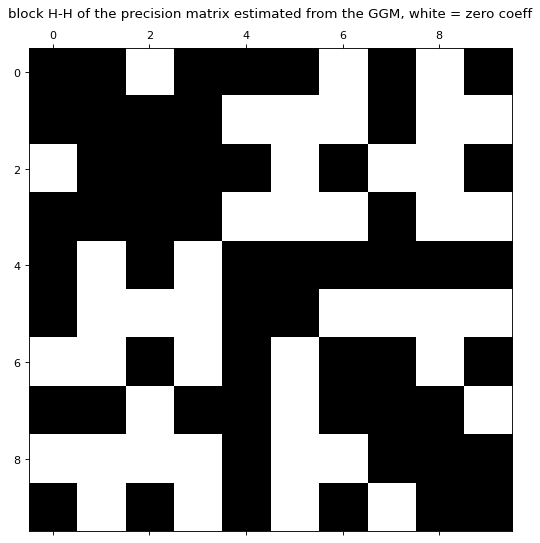


number of non zero coeffs:  56
total coeffs: 100


In [ ]:
fig = plt.figure(figsize=(8,8), dpi = 80)
pd_prec = pd.DataFrame(prec[0:10,0:10],
                         columns=['H-EX1G','H-EX2G','H-A1G','H-A2G','H-C1G','H-C2G','H-ES1G','H-ES2G','H-O1G','H-O2G'],
                         index = ['H-EX1G','H-EX2G','H-A1G','H-A2G','H-C1G','H-C2G','H-ES1G','H-ES2G','H-O1G','H-O2G'],
                         )

plt.spy(pd_prec)
print('variable names:')
print('   H-EX1G,H-EX2G,H-A1G,H-A2G,H-C1G,H-C2G,H-ES1G,H-ES2G,H-O1G,H-O2G')
plt.title('block H-H of the precision matrix estimated from the GGM, white = zero coeff')
plt.show()

print('\nnumber of non zero coeffs: ',np.sum(prec[0:10,0:10]!=0))
print('total coeffs: 100')

variable names:
   D-EX1G,D-EX2G,D-A1G,D-A2G,D-C1G,D-C2G,D-ES1G,D-ES2G,D-O1G,D-O2G


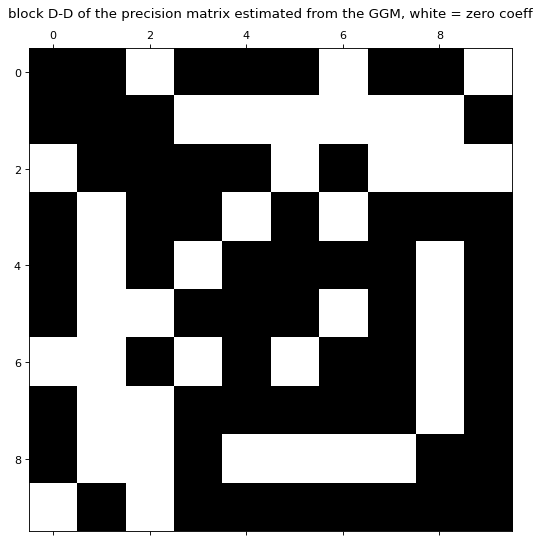


number of non zero coeffs:  60
total coeffs: 100


In [ ]:
fig = plt.figure(figsize=(8,8), dpi = 80)
pd_prec = pd.DataFrame(prec[10:20,10:20],
                         columns=['D-EX1G','D-EX2G','D-A1G','D-A2G','D-C1G','D-C2G','D-ES1G','D-ES2G','D-O1G','D-O2G'],
                         index = ['D-EX1G','D-EX2G','D-A1G','D-A2G','D-C1G','D-C2G','D-ES1G','D-ES2G','D-O1G','D-O2G'],
                         )

plt.spy(pd_prec)
print('variable names:')
print('   D-EX1G,D-EX2G,D-A1G,D-A2G,D-C1G,D-C2G,D-ES1G,D-ES2G,D-O1G,D-O2G')
plt.title('block D-D of the precision matrix estimated from the GGM, white = zero coeff')
plt.show()

print('\nnumber of non zero coeffs: ',np.sum(prec[10:20,10:20]!=0))
print('total coeffs: 100')

In [ ]:
#interaction effects (precision matrix)
headers = ['H-EX1G','H-EX2G','H-A1G','H-A2G','H-C1G','H-C2G','H-ES1G','H-ES2G','H-O1G','H-O2G']
prec_df = pd.DataFrame(prec[0:10,10:20],index = ['D-EX1G','D-EX2G','D-A1G','D-A2G','D-C1G','D-C2G','D-ES1G','D-ES2G','D-O1G','D-O2G'],
                       columns = headers) 
table = tabulate( prec_df, 
    headers = headers ,showindex = True, tablefmt="fancy_grid")
print('quantitative Dishonest-honest interaction effects on precision matrix')
print(table)

quantitative Dishonest-honest interaction effects on precision matrix
╒════════╤════════════╤═════════════╤═════════════╤═════════════╤═════════════╤════════════╤══════════╤═════════════╤═════════════╤════════════╕
│        │     H-EX1G │      H-EX2G │       H-A1G │       H-A2G │       H-C1G │      H-C2G │   H-ES1G │      H-ES2G │       H-O1G │      H-O2G │
╞════════╪════════════╪═════════════╪═════════════╪═════════════╪═════════════╪════════════╪══════════╪═════════════╪═════════════╪════════════╡
│ D-EX1G │ -0         │  0          │ -0          │ -0.00969732 │ -0.0611311  │ -0         │       -0 │ -0          │  0.00175163 │ -0         │
├────────┼────────────┼─────────────┼─────────────┼─────────────┼─────────────┼────────────┼──────────┼─────────────┼─────────────┼────────────┤
│ D-EX2G │  0         │ -0.146744   │  0.0300077  │  0          │  0          │  0.0367442 │       -0 │  0          │  0          │  0         │
├────────┼────────────┼─────────────┼─────────────┼─────────

In [ ]:
#H-H effects (precision matrix)
headers = ['H-EX1G','H-EX2G','H-A1G','H-A2G','H-C1G','H-C2G','H-ES1G','H-ES2G','H-O1G','H-O2G']
prec_df = pd.DataFrame(prec[0:10,0:10],index = ['H-EX1G','H-EX2G','H-A1G','H-A2G','H-C1G','H-C2G','H-ES1G','H-ES2G','H-O1G','H-O2G'],
                       columns = headers)

table = tabulate( prec_df, 
    headers = headers ,showindex = True, tablefmt="fancy_grid")
print('quantitative honest-honest interaction effects on precision matrix')
print(table)

quantitative honest-honest interaction effects on precision matrix
╒════════╤══════════════╤════════════╤════════════╤════════════╤════════════╤═════════════╤════════════╤════════════╤════════════╤══════════════╕
│        │       H-EX1G │     H-EX2G │      H-A1G │      H-A2G │      H-C1G │       H-C2G │     H-ES1G │     H-ES2G │      H-O1G │        H-O2G │
╞════════╪══════════════╪════════════╪════════════╪════════════╪════════════╪═════════════╪════════════╪════════════╪════════════╪══════════════╡
│ H-EX1G │  1.18049     │ -0.127094  │ -0         │ -0.122481  │ -0.093574  │ -0.00557425 │ -0         │ -0.0917054 │ -0         │ -0.000586969 │
├────────┼──────────────┼────────────┼────────────┼────────────┼────────────┼─────────────┼────────────┼────────────┼────────────┼──────────────┤
│ H-EX2G │ -0.127094    │  0.983598  │  0.0404655 │ -0.0472511 │  0         │  0          │  0         │  0.0651869 │ -0         │  0           │
├────────┼──────────────┼────────────┼────────────┼──────

In [ ]:
#D-D effects (precision matrix)
headers = ['D-EX1G','D-EX2G','D-A1G','D-A2G','D-C1G','D-C2G','D-ES1G','D-ES2G','D-O1G','D-O2G']
prec_df = pd.DataFrame(prec[10:20,10:20],index = headers,columns = headers)

table = tabulate( prec_df, 
    headers = headers ,showindex = True, tablefmt="fancy_grid")
print('quantitative dishonest-dishonest interaction effects on precision matrix')
print(table)

quantitative dishonest-dishonest interaction effects on precision matrix
╒════════╤════════════╤════════════╤════════════╤════════════╤════════════╤═══════════╤═══════════╤═══════════╤═════════════╤═════════════╕
│        │     D-EX1G │     D-EX2G │      D-A1G │      D-A2G │      D-C1G │     D-C2G │    D-ES1G │    D-ES2G │       D-O1G │       D-O2G │
╞════════╪════════════╪════════════╪════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═════════════╪═════════════╡
│ D-EX1G │  2.04693   │  0.0270814 │  0         │ -0.249583  │ -0.268419  │ -0.719275 │ -0        │ -0.36876  │ -0.0673674  │ -0          │
├────────┼────────────┼────────────┼────────────┼────────────┼────────────┼───────────┼───────────┼───────────┼─────────────┼─────────────┤
│ D-EX2G │  0.0270814 │  0.673044  │ -0.0128265 │  0         │  0         │  0        │  0        │  0        │  0          │ -0.0859198  │
├────────┼────────────┼────────────┼────────────┼────────────┼────────────┼───────────┼

from this last tables one can get some informations about the joint structure of $x=(x_{H}, x_{D})^{T}$. It was interesting for us to notice that diagonal effects in the $H-D$ block are not present for half of the questions, this means in particular that the trivial strategy of substracting the mean is probably too simplyfing and it's not representing the real behaviour.

####  estimated blocks of the correlation matrix

We plotted the same tables as before, this time for the estimated correlation matrix instead of the precision one.

In [ ]:
#interaction effects (correlation matrix)
headers = ['H-EX1G','H-EX2G','H-A1G','H-A2G','H-C1G','H-C2G','H-ES1G','H-ES2G','H-O1G','H-O2G']
corr_df = pd.DataFrame(corr[0:10,10:20],index = ['D-EX1G','D-EX2G','D-A1G','D-A2G','D-C1G','D-C2G','D-ES1G','D-ES2G','D-O1G','D-O2G'],
                       columns = headers
                       )

table = tabulate( corr_df, 
    headers = headers ,showindex = True, tablefmt="fancy_grid")
print('quantitative Dishonest-honest interaction effects on correlation matrix')
print(table)

quantitative Dishonest-honest interaction effects on correlation matrix
╒════════╤════════════╤══════════════╤══════════════╤═════════════╤════════════╤════════════╤═════════════╤═════════════╤═════════════╤═══════════╕
│        │     H-EX1G │       H-EX2G │        H-A1G │       H-A2G │      H-C1G │      H-C2G │      H-ES1G │      H-ES2G │       H-O1G │     H-O2G │
╞════════╪════════════╪══════════════╪══════════════╪═════════════╪════════════╪════════════╪═════════════╪═════════════╪═════════════╪═══════════╡
│ D-EX1G │  0.0333198 │  0.0193698   │  0.00966017  │  0.0207808  │  0.0581996 │  0.025969  │  0.0289139  │  0.0255226  │  0.00403565 │ 0.0214578 │
├────────┼────────────┼──────────────┼──────────────┼─────────────┼────────────┼────────────┼─────────────┼─────────────┼─────────────┼───────────┤
│ D-EX2G │ -0.0222597 │  0.185756    │ -0.0338774   │ -0.0110292  │ -0.010817  │ -0.033326  │ -0.00918857 │ -0.0117487  │ -0.00292946 │ 0.0048066 │
├────────┼────────────┼──────────────┼──

In [ ]:
#H-H effects (corr matrix)
headers = ['H-EX1G','H-EX2G','H-A1G','H-A2G','H-C1G','H-C2G','H-ES1G','H-ES2G','H-O1G','H-O2G']
prec_df = pd.DataFrame(corr[0:10,0:10],index = headers,columns = headers)

table = tabulate( prec_df, 
    headers = headers ,showindex = True, tablefmt="fancy_grid")
print('quantitative honest-honest interaction effects on precision matrix')
print(table)

quantitative honest-honest interaction effects on precision matrix
╒════════╤═══════════╤══════════════╤═════════════╤════════════╤═════════════╤══════════════╤═════════════╤════════════╤═════════════╤════════════╕
│        │    H-EX1G │       H-EX2G │       H-A1G │      H-A2G │       H-C1G │        H-C2G │      H-ES1G │     H-ES2G │       H-O1G │      H-O2G │
╞════════╪═══════════╪══════════════╪═════════════╪════════════╪═════════════╪══════════════╪═════════════╪════════════╪═════════════╪════════════╡
│ H-EX1G │ 1         │  0.115769    │  0.0209275  │ 0.129553   │  0.125359   │  0.0104478   │  0.0745062  │  0.122247  │  0.0267733  │  0.0373444 │
├────────┼───────────┼──────────────┼─────────────┼────────────┼─────────────┼──────────────┼─────────────┼────────────┼─────────────┼────────────┤
│ H-EX2G │ 0.115769  │  1           │ -0.0593896  │ 0.0468144  │ -0.00676481 │ -0.000736146 │ -0.0364281  │ -0.0615837 │ -0.0103054  │ -0.0115985 │
├────────┼───────────┼──────────────┼────────

In [ ]:
#D-D effects (corr matrix)
headers = ['D-EX1G','D-EX2G','D-A1G','D-A2G','D-C1G','D-C2G','D-ES1G','D-ES2G','D-O1G','D-O2G']
prec_df = pd.DataFrame(corr[10:20,10:20],index = headers,columns = headers)

table = tabulate( prec_df, 
    headers = headers ,showindex = True, tablefmt="fancy_grid")
print('quantitative dishonest-dishonest interaction effects on precision matrix')
print(table)

quantitative dishonest-dishonest interaction effects on precision matrix
╒════════╤════════════╤══════════════╤═══════════╤════════════╤═══════════╤════════════╤═══════════╤═══════════╤══════════════╤═══════════╕
│        │     D-EX1G │       D-EX2G │     D-A1G │      D-A2G │     D-C1G │      D-C2G │    D-ES1G │    D-ES2G │        D-O1G │     D-O2G │
╞════════╪════════════╪══════════════╪═══════════╪════════════╪═══════════╪════════════╪═══════════╪═══════════╪══════════════╪═══════════╡
│ D-EX1G │  1         │ -0.014703    │ 0.0973707 │ 0.299519   │ 0.341867  │ 0.502398   │ 0.219738  │ 0.388495  │  0.0796529   │ 0.189516  │
├────────┼────────────┼──────────────┼───────────┼────────────┼───────────┼────────────┼───────────┼───────────┼──────────────┼───────────┤
│ D-EX2G │ -0.014703  │  1           │ 0.0125285 │ 0.00153264 │ 0.0113553 │ 0.00636785 │ 0.0171673 │ 0.0102453 │ -0.000179811 │ 0.0919773 │
├────────┼────────────┼──────────────┼───────────┼────────────┼───────────┼────────────

the interaction between the two questionnaries of the same person is not that sparse as it seems, probably numerical integration tecniques for a better inference are needed.

#### discriminative accuracy estimation

In [ ]:
# Read data
df = pd.read_csv('BF_df_OU.csv')
df['CONDITION_BINARY'] = np.where(df['CONDITION']== 'H', 1, 0)

# Set variable names
input_variables = ['EX1G','EX2G','A1G','A2G','C1G','C2G','ES1G','ES2G','O1G','O2G']
input_labels = ['EX1G is outgoing',
                   'EX2G - is NOT reserved',
                   'A1G - NOT find faults',
                   'A2G - trusting',
                   'C1G - NOT lazy',
                   'C2G - thorough job',
                   'ES1G - NOT nervous',
                   'ES2G - relaxed',
                   'O1G - active imagination',
                   'O2G - NOT few art interest']
target_variable = 'CONDITION'
target_variable_binary = 'CONDITION_BINARY'

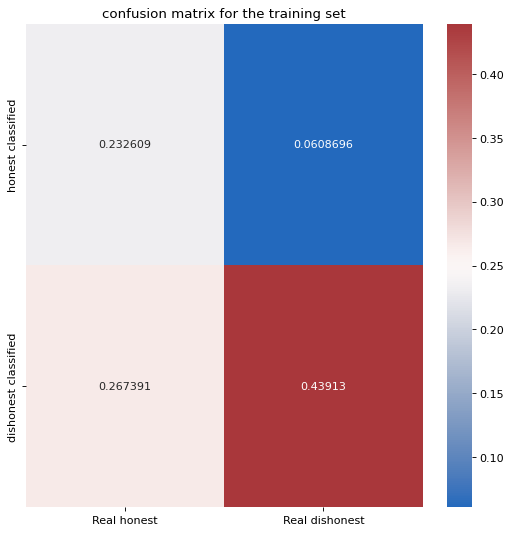


------------------------------------------------------
overall accuracy: 0.6717391304347826


In [ ]:
# functions for the block marginal distributions

def P(x,precision = prec,mu = mean):      

  d = precision.shape[0]

  if len(x.shape)==2:

    return np.array([P(x[i]-mu,precision) for i in range(x.shape[0])])

  y = x-mu

  return (1/(2*np.pi)**(d/2))*np.sqrt(np.abs(np.linalg.det(precision)))*np.exp(-(1/2)*y.T@precision@y)


def P_marg_x(x,precision = prec):    #approximate version

  d = precision.shape[0]

  return (1/(2*np.pi)**(d/4))*np.sqrt(np.abs(np.linalg.det(precision[0:10,0:10])))*np.exp(-(1/2)*x.T@precision[0:10,0:10]@x)

def P_marg_h(h,precision = prec):    #approximate version

  d = precision.shape[0]

  return (1/(2*np.pi)**(d/4))*np.sqrt(np.abs(np.linalg.det(precision[10:20,10:20])))*np.exp(-(1/2)*h.T@precision[10:20,10:20]@h)

def discrimination_func(x,precision = prec):   #discriminative function obtained from graphical model estimate

  '''
  negative result -> classify as dishonest
  positive result -> classify as honest

  '''

  return np.log(P_marg_x(x,precision)/P_marg_h(x,precision))


def classify(x,precision = prec):      #classification for just one sample questionnaire 

  if discrimination_func(x,precision)<0:

    return 0

  else:

    return 1


def group_classif(X,precision = prec):   # classify a matrix of samples

  y = np.zeros(X.shape[0])

  for i in range(X.shape[0]):

    y[i] = classify(X[i],precision)

  return y


# confusion matrix

X_centered = deepcopy(X)
X_centered[0:230]=X_centered[0:230]-mu[0:10]
X_centered[230:460]=X_centered[230:460]-mu[10:20]

y_hat = group_classif(X_centered,precision = prec)

True_dish = np.sum((df['CONDITION_BINARY'] == 0 ) & (y_hat==0))
True_hon = np.sum((df['CONDITION_BINARY'] == 1 ) & (y_hat==1))
False_dish =  np.sum((df['CONDITION_BINARY'] == 1 ) & (y_hat==0))
False_hon = np.sum((df['CONDITION_BINARY'] == 0 ) & (y_hat==1))

confusion_mat = np.array([[True_hon,False_hon],[False_dish,True_dish]])/X.shape[0]

pd.options.display.float_format = '{:.2f}'.format
fig = plt.figure(figsize=(8,8), dpi = 80)
hm = sns.heatmap(  pd.DataFrame(confusion_mat,columns=['Real honest','Real dishonest'],
                         index = ['honest classified','dishonest classified'] ) ,
                 cmap=current_palette,annot = True,fmt = 'g' )
plt.title('confusion matrix for the training set')
plt.show()

print('\n------------------------------------------------------')
print('overall accuracy:', np.sum(df['CONDITION_BINARY']==y_hat)/460)


Extremely punishing method, basically it classifies everyone as lying, so it has a big False negative rate even if we're considering only the training set. To have a less biased measure we use random sampling CV to get a better estimator for the confusion matrix

In [ ]:
# function for the randomized CV to estimate the accuracy of just prediction

def cv_accuracy(X,df,iter = 20,test_size = 10):   # the real test size is the test_size input doubled

  cv_confusions = []

  for i in range(iter):

    X_merged = np.hstack([X[0:X.shape[0]//2],X[X.shape[0]//2:X.shape[0]]])

    indexes = np.array([[i,230+i] for i in range(230)])

    X_train,X_test,index_train,index_test = train_test_split(X_merged,indexes,train_size=230-test_size)

    mu = np.mean(X_train,axis=0)

    model = GraphicalLassoCV()

    model.fit(X_train)

    prec = model.get_precision()

    X_centered_test = deepcopy(X_test) - mu
    X_centered_test = np.vstack([X_centered_test[:,0:10],X_centered_test[:,10:20]])
    index_test = np.hstack([index_test[:,0],index_test[:,1]])

    y_test = (df['CONDITION_BINARY'].to_numpy())[index_test]

    y_hat = group_classif(X_centered_test,precision = prec)

    True_dish = np.sum((y_test == 0 ) & (y_hat==0))
    True_hon = np.sum((y_test == 1 ) & (y_hat==1))
    False_dish =  np.sum((y_test == 1 ) & (y_hat==0))
    False_hon = np.sum((y_test == 0 ) & (y_hat==1))

    confusion_mat = np.array([[True_hon,False_hon],[False_dish,True_dish]])

    cv_confusions.append(confusion_mat)

  return np.array(cv_confusions)





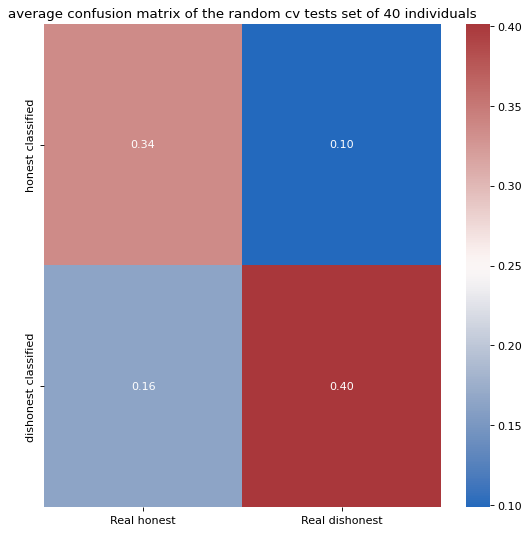


------------------------------------------------------
random cv test classification accuracy: 0.7375


In [ ]:
test_size = 40
cvs = cv_accuracy(X,df,iter = 20,test_size = test_size//2 )
mean_cv_confusion = np.mean(cvs,axis = 0)/test_size


pd.options.display.float_format = '{:.2f}'.format
fig = plt.figure(figsize=(8,8), dpi = 80)
hm = sns.heatmap(  pd.DataFrame(mean_cv_confusion,columns=['Real honest','Real dishonest'],
                         index = ['honest classified','dishonest classified'] ) ,
                 cmap=current_palette,annot = True,fmt = '.2f' )
plt.title('average confusion matrix of the random cv tests set of '+str(test_size)+' individuals')
plt.show()

print('\n------------------------------------------------------')
print('random cv test classification accuracy:', np.trace(mean_cv_confusion))

The only thing that we have to do more than that in this model is to see the goodness of reconstruction. We have to decide which measure to use

#### Reconstruction

 We are now interested in making some probabilistic reconstructions. Since we work in the hypothesis that the joint distribution of $x=(x_{H},x_{D})^{T}$ is Gaussian, we can calculate the conditioned ones , $p(x_{H}|x_{D};\theta)$ and $p(x_{D}|x_{H};\theta)$, that are again Gaussians.

 They are:

$$
p(x_{H}|x_{D};\theta) = \frac{|det(\theta_{HH})|^{1/2}}{(2 \pi)^{5}}\exp\Bigl[ -\frac{1}{2}\bigl[x_{H}-(\mu_{H}-\theta_{HH}^{-1} \theta_{HD}(x_{D}-\mu_{D})) \bigr]^{T}\theta_{HH}\bigl[\mu_{H}-\theta_{HH}^{-1} \theta_{HD}(x_{D}-\mu_{D})) \bigr]  \Bigr]
$$

and by symmetry

$$
p(x_{D}|x_{H};\theta) = \frac{|det(\theta_{DD})|^{1/2}}{(2 \pi)^{5}}\exp\Bigl[ -\frac{1}{2}\bigl[x_{D}-(\mu_{D}-\theta_{DD}^{-1} \theta_{DH}(x_{H}-\mu_{H})) \bigr]^{T}\theta_{DD}\bigl[\mu_{D}-\theta_{DD}^{-1} \theta_{DH}x_{H}-\mu_{H})) \bigr]  \Bigr]
$$


Once we have a classification for a new questionnaire $q$ (let's suppose it is lying), we can infer the most probable honest one by solving the optimization problem

\begin{equation*}
    \begin{cases} argmax_{x_{H}} p(x_{H}|q \,;\hat{\theta}) = argmin_{x_{H}} (x_H-\tilde{\mu})^{T}\hat{\theta}_{HH}(x_H-\tilde{\mu})  & \\\text{s.t.  } x_{H} \in \{1,..,5 \}^{10} \end{cases} 
\end{equation*}

That is non convex because the constrain has a combinatorial flavour.

In [ ]:
# conditional distributions for inference

def P_h_given_d(x_H,x_D,mean = mu,precision = prec):

  d = x_H.shape[0]

  theta_HH = precision[0:10,0:10]
  theta_HD = precision[0:10,10:20]
  theta_HH_inv = np.linalg.inv(theta_HH)
  m_H = mean[0:10]
  m_D = mean[10:20]
  mu_tilde = m_H-theta_HH_inv@theta_HD@(x_D-m_D)

  value =  ( np.sqrt(np.abs(np.linalg.det(theta_HH)))/(2*np.pi)**(d/2)   )*np.exp(  -0.5*(x_H-mu_tilde).T@theta_HH@(x_H-mu_tilde)  )

  return value


def P_d_given_h(x_D,x_H,mean = mu,precision = prec):

  d = x_H.shape[0]

  theta = np.block( [[precision[10:20,10:20],precision[0:10,10:20]],[precision[10:20,0:10],precision[0:10,0:10]]] )

  mu = np.hstack([mean[10:20],mean[0:10]])

  return P_h_given_d(x_D,x_H,mean = mu,precision = theta)


# functions to optimize

def infer_h_given_d_CW(x_D,mean = mu, precision = prec,tol = 1e-1,max_it = 100):           #coordinatewise optimization

  it = 1

  theta_HH = precision[0:10,0:10]
  theta_HD = precision[0:10,10:20]
  theta_HH_inv = np.linalg.inv(theta_HH)
  m_H = mean[0:10]
  m_D = mean[10:20]
  mu_tilde = m_H-theta_HH_inv@theta_HD@(x_D-m_D)

  x_H = deepcopy(x_D)

  s_k = 100

  while it<= max_it and s_k>tol :

    x_H_hat = deepcopy(x_H)

    for j in range(x_D.shape[0]):

      x_H[j] = mu_tilde[j]-( ( theta_HH[j]/ theta_HH[j,j]).T@(x_H-mu_tilde ) -(x_H[j]-mu_tilde[j] ) )  

      #rounding

      if x_H[j]>5:

        x_H[j] = 5

      elif x_H[j]<1:

        x_H[j] = 1

      else:

        x_H[j] = x_H[j].round()

    s_k = np.max(np.abs(x_H_hat-x_H))

    it+=1

  return x_H

In [ ]:
def confusion_tensor(v,w,levels = 5):      # list of confusion matrices, one for each question

  res = np.zeros(shape = (v.shape[0],levels,levels))

  for k in range(v.shape[0]):

    for i in range(levels):

      for j in range(levels):

        res[k,i,j] = int(v[k]==i+1 and w[k]==j+1)

  return res



def cv_reconstruction_tensor(X,df,iter = 20,test_size = 10,tol = 1e-1,max_it = 100,eta = 0.05):   # the real test size is the test_size input doubled

  prob_reconstruction = []

  confusion_matrices = []

  for i in range(iter):

    records_good_rec = []

    X_merged = np.hstack([X[0:X.shape[0]//2],X[X.shape[0]//2:X.shape[0]]])

    indexes = np.array([[i,230+i] for i in range(230)])

    X_train,X_test,index_train,index_test = train_test_split(X_merged,indexes,train_size=230-test_size)

    mu = np.mean(X_train,axis=0)

    model = GraphicalLassoCV()

    model.fit(X_train)

    prec = model.get_precision()

    conf_tensor = np.zeros((10,5,5))

    for j in range(X_test.shape[0]):

      reconstruction =  infer_h_given_d_CW( X_test[j][10:20] ,mean = mu, precision = prec,tol = tol ,max_it = max_it )   #FW -> CW last change

      conf_tensor += confusion_tensor(X_test[j][0:10],reconstruction) 

      records_good_rec.append(  reconstruction == X_test[j][0:10]  )
    
    confusion_matrices.append(conf_tensor/(10*test_size))

    prob_reconstruction.append( np.mean( np.array(records_good_rec),axis = 0 ) )

  return np.mean( np.array(confusion_matrices ),axis = 0 ),np.mean( np.array( prob_reconstruction  ) ,axis = 0)


---------------------------------------------------------
cv mean reconstruction probability per feature over 30 people
   EX1G  EX2G  A1G  A2G  C1G  C2G  ES1G  ES2G  O1G  O2G
0  0.20  0.47 0.30 0.24 0.28 0.41  0.31  0.27 0.20 0.18

---------------------------------------------------------


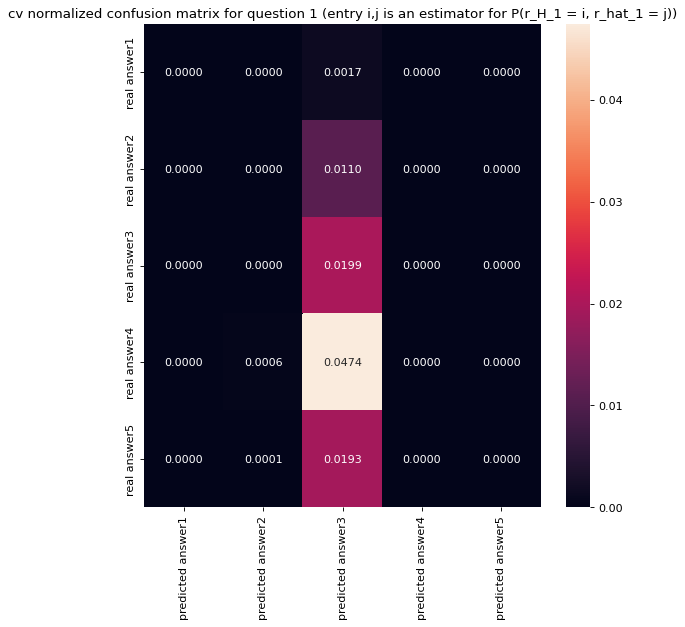

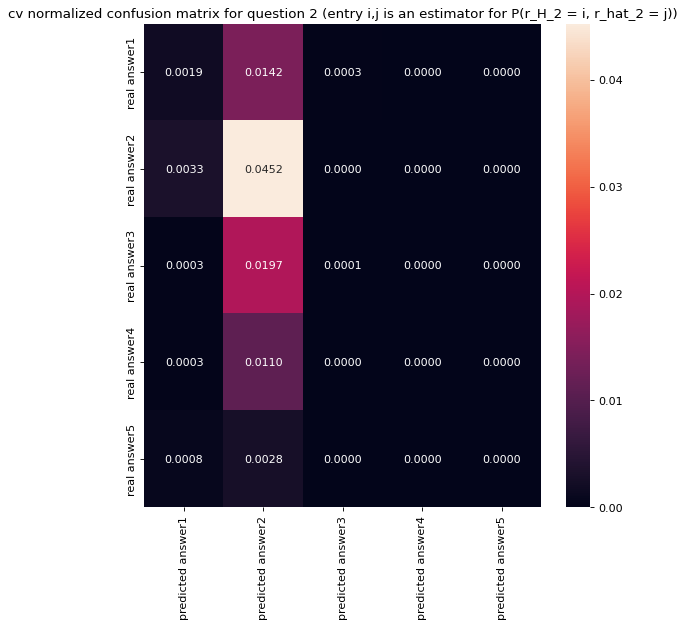

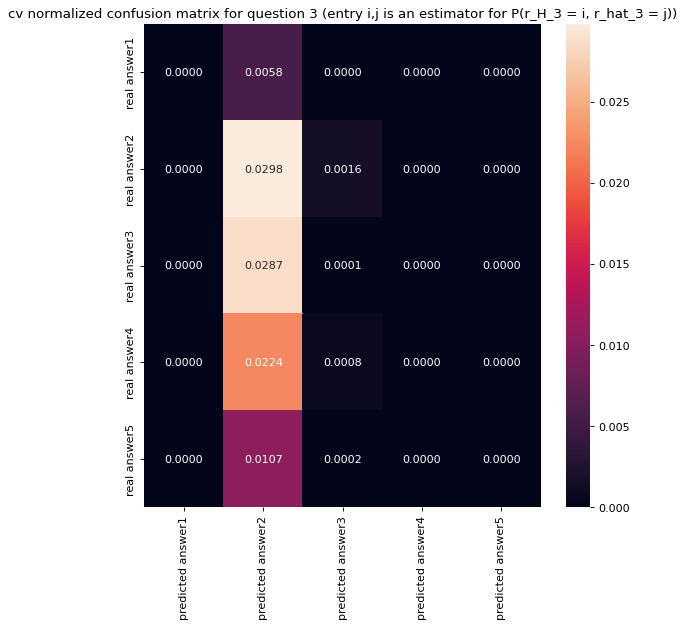

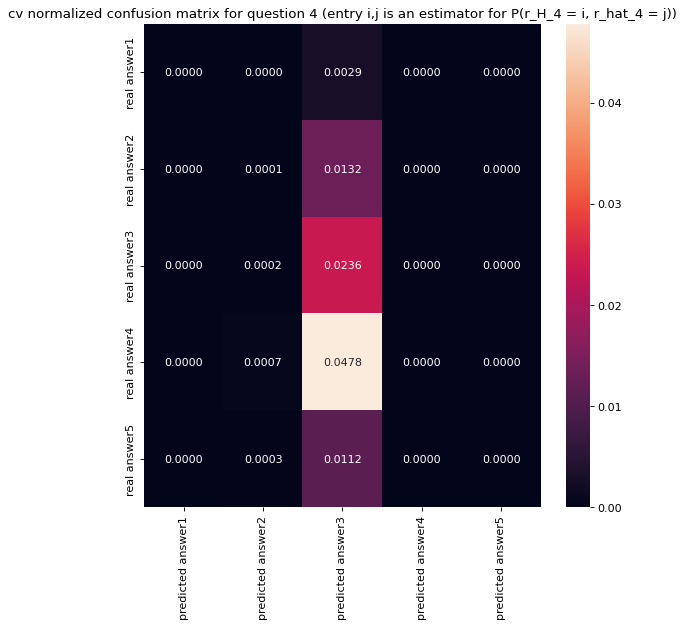

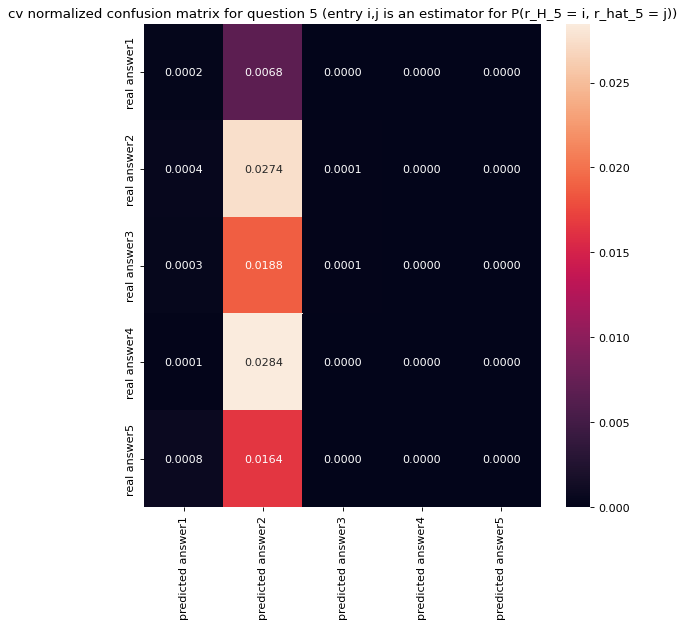

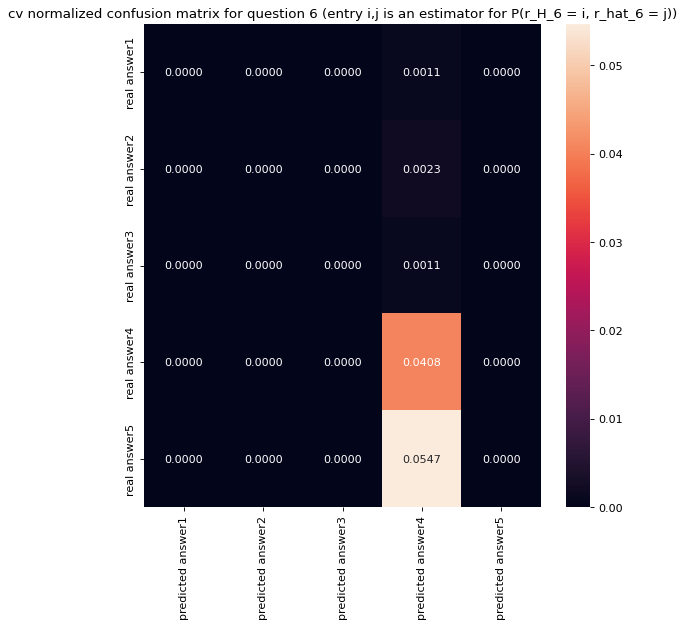

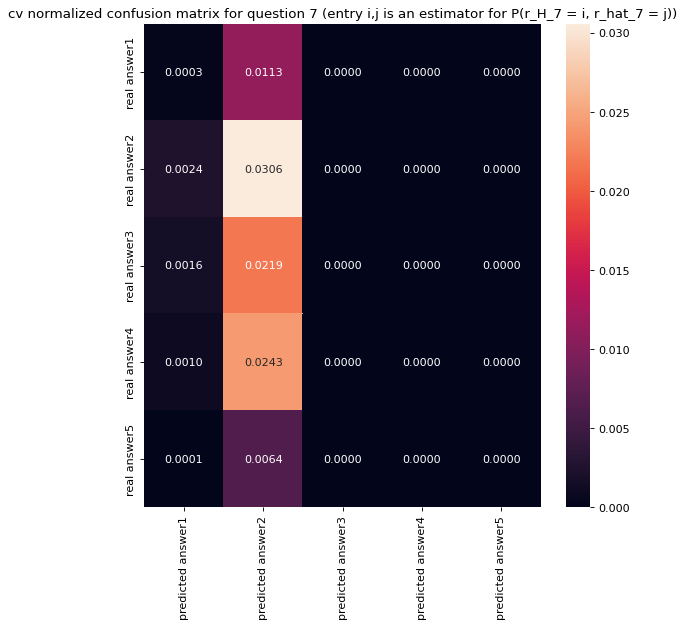

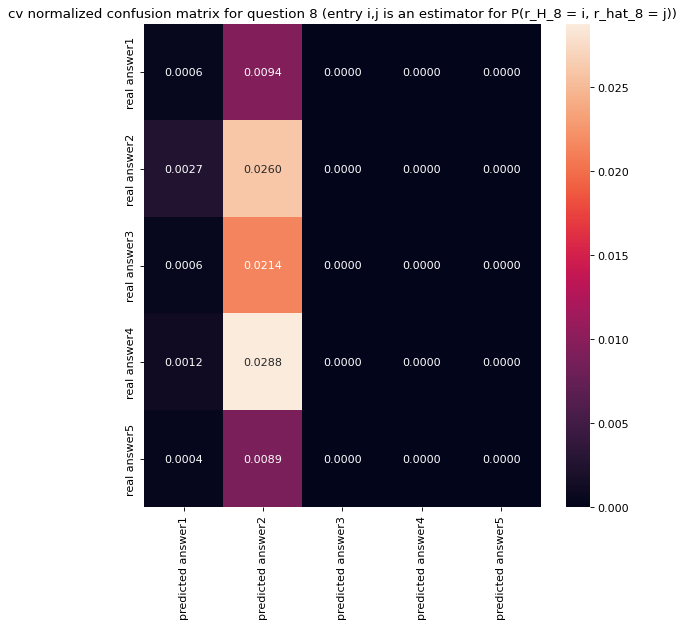

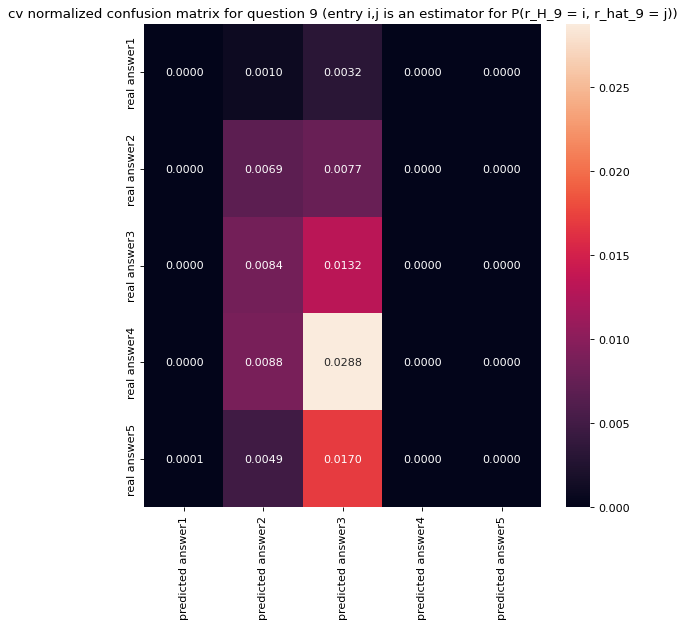

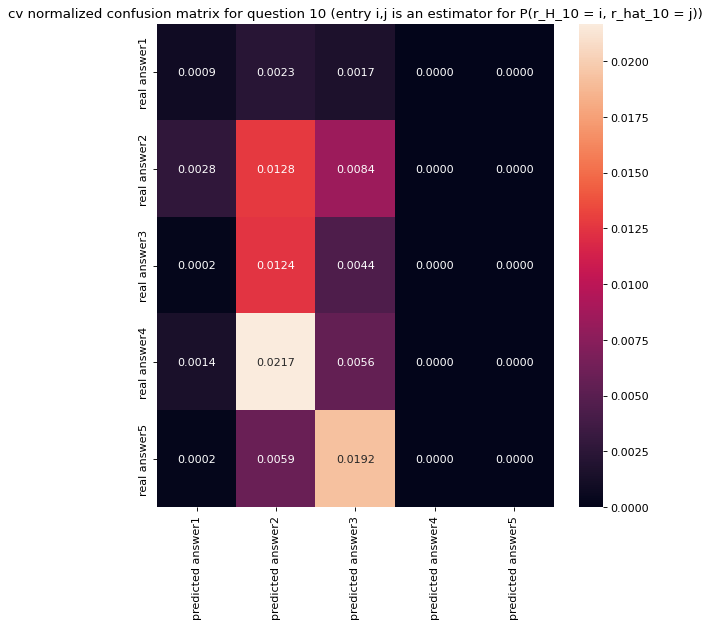

In [ ]:
# reconstruction probability
test_size = 30
cv_conf_rec,prob_reconstruction = cv_reconstruction_tensor(X,df,test_size = test_size,iter = 30)

cv_conf_rec_qcond = 10*cv_conf_rec   #multiply by the number of questions to normalize each question slice matrix (condition on question)

print('\n---------------------------------------------------------')
print('cv mean reconstruction probability per feature over '+str(test_size)+' people')
print(pd.DataFrame([prob_reconstruction],columns = ['EX1G','EX2G','A1G','A2G','C1G','C2G','ES1G','ES2G','O1G','O2G'] ) )
print('\n---------------------------------------------------------')

for question in range(1,11):

  pd.options.display.float_format = '{:.2f}'.format
  fig = plt.figure(figsize=(8,8), dpi = 80)
  hm = sns.heatmap(  pd.DataFrame(cv_conf_rec[question-1],columns=['predicted answer'+str(i) for i in range(1,6)],
                           index = ['real answer'+str(i) for i in range(1,6)] ) ,
                   annot = True,fmt = '.4f' )
  plt.title('cv normalized confusion matrix for question '+ str(question)+ ' (entry i,j is an estimator for P(r_H_'+str(question)+' = i, r_hat_'+str(question)+' = j))')
  plt.show()

From this confusion tensor we can notice that maybe the unimodal assumption on the posterior of $x_H|x_D$ is not a reasonable assumption. 

A thing we tried to do in order to investigate this fact more carefully was trying to do clustering in the space of joint honest-dishonest questionnaires (we tried even to do a kernel clustering in the space of features $\phi(x) = xx^T$ by using laplacian coordinates), but there seemed to be only one cluster.

In any case, graphical Lasso was in particular useful in giving us some insights about the general structure of lying and about next things to try.

### Feature propagation

Starting from the k-nearest neighbors idea, we decided to implement a similar strategy called feature propagation. Instead of computing the reconstruction as the average of the nearest neighbors in terms of questionnaire, we let the features flow in the knn graph just like a pagerank. We implemented this strategy in the joint space $(H,D)$ and we evaluated the goodness of this method both for reconstruction and per question discrimination by using loocv.
The features attached to a generic node $i$ of the graph is $f^{(i)}=\Bigl((1_{\{ x_{H}^{(i),j}=x_{D}^{(i),j} \}})_{j=1,..,10},x_H^{(i)},x_D^{(i)}\Bigr)$. When we have a new sample questionnaire $x$, we can suppose as a prior that the honest and dishonest questionnaire of this new sample would not change. Moreover we put a lying prior for each question of $0.5$ for being fair. 
After doing that, we constructed a knn graph by using this features as we run feature propagation to look for fixed points of the equation:
$$
F^{t} = \alpha P^{T}F^{t-1}+(1-\alpha)F^{0}
$$
where $F^{0}$ is the matrix of starting features, $P$ is a transition matrix on the knn graph and $\alpha$ is to be interpreted as a sort of prior on how much we believe on our starting features. 

In [ ]:
from sklearn.neighbors import kneighbors_graph

def normalized_laplacian(A):
  '''
  INPUT:
  A = adjacency matrix of a Graph
  OUTPUT:
  returns the normalized Laplacian matrix associated to A
  '''
  D = np.diag(np.sum(A,axis=1))
  L = D-A
  sqrtD = np.diag(np.sum(A,axis=1)**(-0.5))
  return sqrtD@L@sqrtD


def feature_spreading(adj,features,labels = None,labels_flag = True,alpha=0.85,toll=1e-6,maxit=100,gamma = 0):

  '''
  INPUT:
  adj = adjacency matrix of the graph
  features = matrix of features to attach to each node
  labels = matrix of one hot encoded labels to attach to each node
  alpha = probability of diffusion
  tol = tolerance for the stopping criterion
  maxit = maximum number of iteration before stopping
  gamma = parameter that controls the bias of transition probability to nodes with a lot of shared neighbors
  OUTPUT:
  Z_r = matrix whose ith row is the final result of feature spreading in node i of the graph

  '''

  if labels_flag == True:

    YX = np.hstack((labels,features))
    P = ((adj@adj+1)**gamma)*adj
    P = P/P.sum(axis = 1)[:,np.newaxis]
    training_features = deepcopy(features)
    Z_0 = np.hstack((labels,training_features))

  else:

    YX = features
    P = ((adj@adj+1)**gamma)*adj
    P = P/P.sum(axis = 1)[:,np.newaxis]
    training_features = deepcopy(features)
    Z_0 = training_features

  Z_r = alpha*P@Z_0+(1-alpha)*YX
  it=0
  while np.linalg.norm(Z_r-Z_0)>toll and it<maxit:
    Z_0,Z_r = Z_r, alpha*P@Z_r+(1-alpha)*YX
    it+=1
  return Z_r

In [ ]:
mu = np.mean(X,axis = 0)

X_merged = np.hstack([X[0:X.shape[0]//2],X[X.shape[0]//2:X.shape[0]]])


def predict_ls(x,X,y,alpha = 0.75,knn=3,gamma = 0):        #not using mu

  '''

  INPUT:
  x = known feature of a new node (oos questionnaire in our case)
  X = matrix of features (one sample per row)
  y = matrix of labels (one sample per row)
  alpha = probability of diffusion
  knn = number of nearest neighbors to costruct the graph from features
  mu = average feature among all samples
  gamma = parameter that controls the bias of transition probability to nodes with a lot of shared neighbors
  OUTPUT:
  Z = feature spreading applied to the graph whose features are X,labels y and
      by adding x as a new node and recomputing the whole structure

  '''

  new_x = x                             
  doubled_x = np.hstack( ( new_x,new_x)  )   

  X_tilde = deepcopy(X)
  X_tilde = np.vstack(( doubled_x , X_tilde))

  
  y_arr = (X[:,0:10]==X[:,10:20] )
  y_arr = np.vstack(( [0.5]*y_arr.shape[1],y_arr  ))
  A = kneighbors_graph( X_tilde+np.random.normal(size = X_tilde.shape ,scale = 0.001),n_neighbors = knn).toarray()


  Z = feature_spreading(A,X_tilde,y_arr,alpha = alpha,gamma = gamma)

  return Z


def loocv_ls(X,y,alpha = 0.75,knn=3,gamma = 0):

  '''
  INPUT:
  X = matrix of features (one sample per row)
  y = matrix of labels (one sample per row)
  alpha = probability of diffusion
  number of nearest neighbors to costruct the graph from features
  mu = average feature among all samples
  gamma = parameter that controls the bias of transition probability to nodes with a lot of shared neighbors
  OUTPUT:
  prediction_ls = list of (feat,real_feat) for each fold
  rmse = vector of rmse per question
  mae = vector of mean absolute error per question
  hard_error = vector whose i th entry is an estimator for the probability of correctly reconstructing question i
  classif = vector whose i th entry is an estimator for the probability of correctly discriminating question i

  '''



  predictions_ls = []

  mse = 0

  classif = 0

  mae = 0

  hard_error = 0

  for i in range(X.shape[0]):

    selector = [j for j in range(X.shape[0]) if j!=i]

    X_del_i = X[selector,:]

    y_del_i = y[selector]

    x = X[i,10:20]

    real_feats = np.hstack(( X[i,0:10]==X[i,10:20],X[i]   ))

    feats = predict_ls(x,X_del_i,y_del_i,alpha = alpha,knn = knn,gamma = gamma)[0]

    predictions_ls.append( ( feats ,real_feats ) )


    mse += (1/X.shape[0])*(feats[10:20]-real_feats[10:20])**2

    mae +=(1/X.shape[0])*np.abs(feats[10:20]-real_feats[10:20])    # 10-20 before

    hard_error+= (1/X.shape[0])*(feats[10:20].round()==real_feats[10:20])

    classif += (feats[:10].round() == real_feats[:10])/X.shape[0]

  rmse = np.sqrt(mse)


  return predictions_ls,rmse,mae,hard_error,classif

#### knn = 2

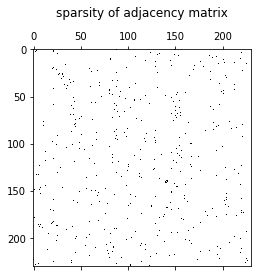

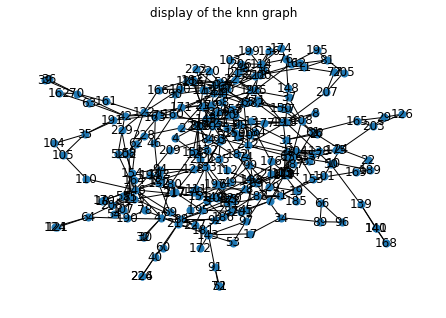

In [ ]:
A = kneighbors_graph( X_merged+np.random.normal(size = X_merged.shape ,scale = 0.001),n_neighbors = 2).toarray()  
G = ntx.from_numpy_matrix(A, create_using=ntx.Graph())

plt.spy(A)
plt.title('sparsity of adjacency matrix\n')
plt.show()

# Use spring_layout to handle positioning of graph
layout = ntx.spring_layout(G,weight = None,k = 0.01)


# Draw the graph using the layout - with_labels=True if you want node labels.
ntx.draw(G, layout,with_labels=True,node_size=50)


# Draw edge labels using layout and list of labels
ntx.draw_networkx_edge_labels(G,pos=layout,edge_labels={})
plt.title('display of the knn graph')

# Show plot
plt.show()

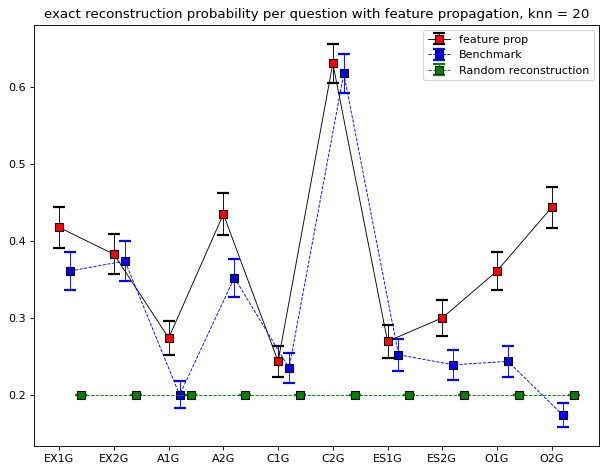

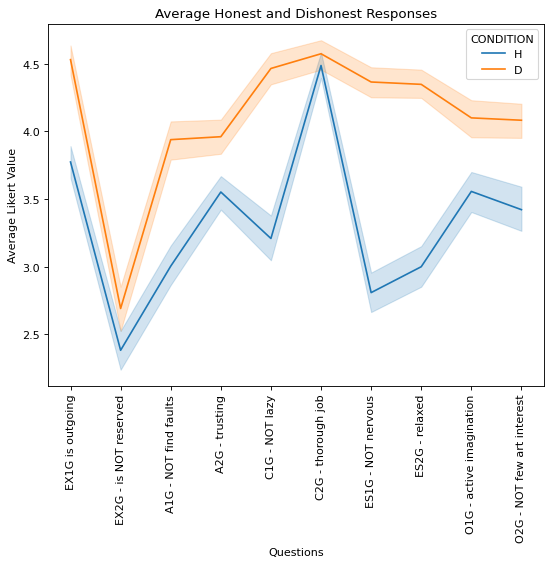

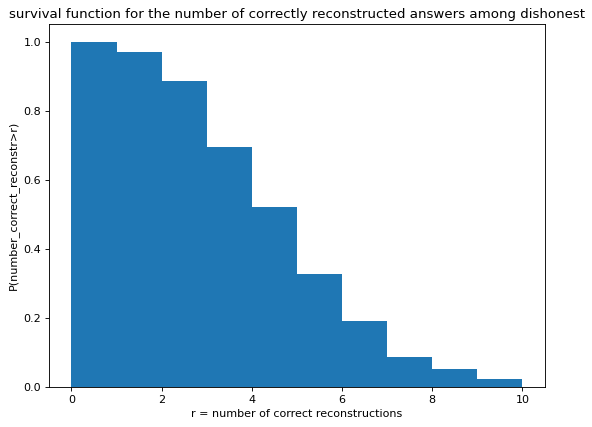


-----------------------------------------------------
rmse:
 [1.1660352  1.1897843  1.50263706 1.16566908 1.83244289 0.77689414
 1.82007998 1.71933462 1.33080647 1.40590354]
mean rmse 1.3909587296354062


mae:
 [0.85479978 0.91130477 1.21810207 0.84677697 1.46154037 0.52207454
 1.46873562 1.33643799 1.00645965 1.01951315]
mean mae:
 1.064574491106343


hard_reconstruction_prob per question:
 [0.4173913  0.3826087  0.27391304 0.43478261 0.24347826 0.63043478
 0.26956522 0.3        0.36086957 0.44347826]
mean hard_reconstruction_prob:
 0.3756521739130429


classif prob per question: 
 [0.55652174 0.52608696 0.54347826 0.42608696 0.42608696 0.53913043
 0.48695652 0.53478261 0.48695652 0.49130435]
mean classif prob:
 0.5017391304347812


benchmark:
 [0.36086957 0.37391304 0.2        0.35217391 0.23478261 0.6173913
 0.25217391 0.23913043 0.24347826 0.17391304]


In [ ]:
import scipy
import matplotlib as mpl

# loocv features spreading
predictions_ls,rmse,mae,hard_error,classif = loocv_ls(X_merged,np.array(y),alpha = 0.65,knn = 2,gamma = 0.2) 

# calculating confidence bands for the prediction
dof = 229
alpha = 1-0.05
t_obj = scipy.stats.t(dof)
q_alpha = t_obj.ppf(alpha)
conf_band = q_alpha*hard_error*(1-hard_error)/np.sqrt(X_merged.shape[0])


mean_diff = np.mean(X[0:230],axis = 0)-np.mean(X[230:460],axis = 0)   # trivial strategy


# plotting the results with confidence bands for reconstruction

plt.figure(figsize=(8, 6), dpi=80)
x_ticks = input_variables

x_1 = np.arange(0,10)
x_2 = x_1 + 0.2

y_1 = hard_error
y_2 =  np.mean((X[230:460]+mean_diff).round() == X[0:230] ,axis = 0)

err_1 = conf_band
err_2 = q_alpha*y_2*(1-y_2)/np.sqrt(X_merged.shape[0])

plt.errorbar(x=x_1, y=y_1, yerr=conf_band, color="black", capsize=5,
             linestyle="-",linewidth = 0.8,
             marker="s", markersize=7, mfc="red", mec="black",capthick = 2)

plt.errorbar(x=x_2, y=y_2, yerr=err_2, color="blue", capsize=5,
             linestyle="--",linewidth = 0.8,
             marker="s", markersize=7, mfc="blue", mec="black",capthick = 2)

plt.errorbar(x=x_2+0.2, y=1/5*np.ones(x_2.shape[0]), yerr=np.zeros(x_2.shape[0]), color="green", capsize=5,
             linestyle="--",linewidth = 0.8,
             marker="s", markersize=7, mfc="green", mec="black",capthick = 2)

plt.xticks(x_1, x_ticks)
plt.title('exact reconstruction probability per question with feature propagation, knn = 20')
plt.legend(['feature prop','Benchmark','Random reconstruction'])

plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 6), dpi=80)

visualDf = pd.melt(df, id_vars = ['CONDITION'],value_vars = input_variables)
_ = sns.lineplot(data=visualDf, x="variable", y="value", hue="CONDITION",)     #take a look at the standard deviation
_.set_xticklabels(input_labels)
_.set_xlabel('Questions')
_.set_ylabel('Average Likert Value')
_.set_title('Average Honest and Dishonest Responses')
_ = plt.xticks(rotation=90)
plt.show()


# plotting survival function for the number of correct reconstructed answers

distr = [np.sum(predictions_ls[i][0][10:20].round() == predictions_ls[i][1][10:20] ) for i in range(len(predictions_ls))]
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(distr,cumulative = -1,density=True,bins = 10)
plt.xlabel('r = number of correct reconstructions')
plt.ylabel('P(number_correct_reconstr>r)')
plt.title('survival function for the number of correctly reconstructed answers among dishonest')
plt.show()


# printing others metrics

print('\n-----------------------------------------------------')
print('rmse:\n', rmse)
print('mean rmse',rmse.mean())
print('\n')
print('mae:\n',mae)
print('mean mae:\n',mae.mean())
print('\n')
print('hard_reconstruction_prob per question:\n',hard_error)
print('mean hard_reconstruction_prob:\n',hard_error.mean())
print('\n')
print('classif prob per question: \n',classif)
print('mean classif prob:\n',classif.mean())
print('\n')
print('benchmark:\n', np.mean((X[230:460]+mean_diff).round() == X[0:230] ,axis = 0) )

#### knn = 20

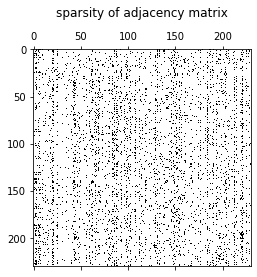

In [ ]:
A = kneighbors_graph( X_merged+np.random.normal(size = X_merged.shape ,scale = 0.001),n_neighbors = 20).toarray()  

plt.spy(A)
plt.title('sparsity of adjacency matrix\n')
plt.show()

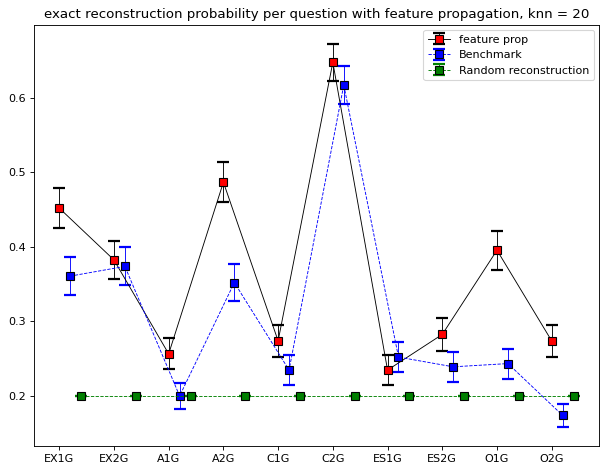

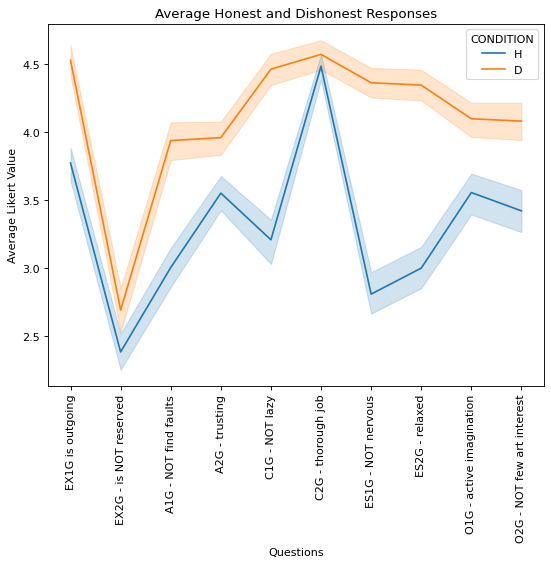

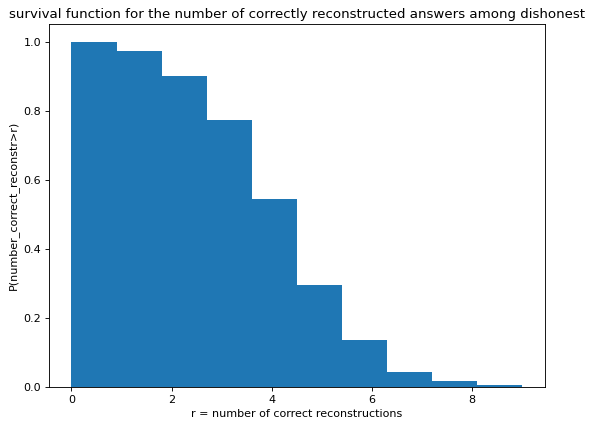


-----------------------------------------------------
rmse:
 [0.98170088 1.00828071 1.15476614 0.99771157 1.43480441 0.70389963
 1.3968736  1.31512765 1.12471421 1.29667542]
mean rmse:
 1.1414554223390907


mae:
 [0.71781786 0.80049866 0.98647857 0.73969813 1.15633619 0.54605305
 1.17419157 1.08295018 0.85510578 1.02993531]
mean mae:
 0.9089065297956493


hard_reconstruction_prob per question:
 [0.45217391 0.3826087  0.25652174 0.48695652 0.27391304 0.64782609
 0.23478261 0.2826087  0.39565217 0.27391304]
mean hard_reconstruction_prob:
 0.3686956521739124


classif prob per question:
 [0.64347826 0.54782609 0.71304348 0.6173913  0.73478261 0.6173913
 0.76521739 0.75652174 0.64347826 0.47391304]
mean classif prob:
 0.6513043478260847


benchmark:
 [0.36086957 0.37391304 0.2        0.35217391 0.23478261 0.6173913
 0.25217391 0.23913043 0.24347826 0.17391304]


In [ ]:
import scipy
import matplotlib as mpl

# loocv features spreading
predictions_ls,rmse,mae,hard_error,classif = loocv_ls(X_merged,np.array(y),alpha = 0.85,knn = 20,gamma = 0) 

# calculating confidence bands for the prediction
dof = 229
alpha = 1-0.05
t_obj = scipy.stats.t(dof)
q_alpha = t_obj.ppf(alpha)
conf_band = q_alpha*hard_error*(1-hard_error)/np.sqrt(X_merged.shape[0])


mean_diff = np.mean(X[0:230],axis = 0)-np.mean(X[230:460],axis = 0)   # trivial strategy


# plotting the results with confidence bands for reconstruction

plt.figure(figsize=(8, 6), dpi=80)
x_ticks = input_variables

x_1 = np.arange(0,10)
x_2 = x_1 + 0.2

y_1 = hard_error
y_2 =  np.mean((X[230:460]+mean_diff).round() == X[0:230] ,axis = 0)

err_1 = conf_band
err_2 = q_alpha*y_2*(1-y_2)/np.sqrt(X_merged.shape[0])

plt.errorbar(x=x_1, y=y_1, yerr=conf_band, color="black", capsize=5,
             linestyle="-",linewidth = 0.8,
             marker="s", markersize=7, mfc="red", mec="black",capthick = 2)

plt.errorbar(x=x_2, y=y_2, yerr=err_2, color="blue", capsize=5,
             linestyle="--",linewidth = 0.8,
             marker="s", markersize=7, mfc="blue", mec="black",capthick = 2)

plt.errorbar(x=x_2+0.2, y=1/5*np.ones(x_2.shape[0]), yerr=np.zeros(x_2.shape[0]), color="green", capsize=5,
             linestyle="--",linewidth = 0.8,
             marker="s", markersize=7, mfc="green", mec="black",capthick = 2)

plt.xticks(x_1, x_ticks)
plt.title('exact reconstruction probability per question with feature propagation, knn = 20')
plt.legend(['feature prop','Benchmark','Random reconstruction'])

plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 6), dpi=80)

visualDf = pd.melt(df, id_vars = ['CONDITION'],value_vars = input_variables)
_ = sns.lineplot(data=visualDf, x="variable", y="value", hue="CONDITION",)     #take a look at the standard deviation
_.set_xticklabels(input_labels)
_.set_xlabel('Questions')
_.set_ylabel('Average Likert Value')
_.set_title('Average Honest and Dishonest Responses')
_ = plt.xticks(rotation=90)
plt.show()


# plotting survival function for the number of correct reconstructed answers

distr = [np.sum(predictions_ls[i][0][10:20].round() == predictions_ls[i][1][10:20] ) for i in range(len(predictions_ls))]
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(distr,cumulative = -1,density=True,bins = 10)
plt.xlabel('r = number of correct reconstructions')
plt.ylabel('P(number_correct_reconstr>r)')
plt.title('survival function for the number of correctly reconstructed answers among dishonest')
plt.show()


# printing others metrics

print('\n-----------------------------------------------------')
print('rmse:\n', rmse)
print('mean rmse:\n',rmse.mean())
print('\n')
print('mae:\n',mae)
print('mean mae:\n',mae.mean())
print('\n')
print('hard_reconstruction_prob per question:\n',hard_error)
print('mean hard_reconstruction_prob:\n',hard_error.mean())
print('\n')
print('classif prob per question:\n',classif)
print('mean classif prob:\n',classif.mean())
print('\n')
print('benchmark:\n', np.mean((X[230:460]+mean_diff).round() == X[0:230] ,axis = 0) )

In the last two plot we can observe that this method is significantly better than the random reconstruction for each question. Moreover, already with 2 nearest neighbors the reconstruction accuracy is significantly better than the benchmark for the majority of questions, for all the others the performance is not significantly different than it.

### Probabilistic Multioutput CNN categorical autoencoder 

The idea of implementing a reconstructor like this came from the following observation : by using the raw denoising autoencoder with mse loss we are implicitly assuming that the reconstruction distribution $p(x_H|x;\theta)$ is a normal $N(f_\theta(x),\sigma^{2}I)$, where $f_\theta(x)$ is the neural network output. This approach has a series of problems, the first one is that we're just basically guessing the variance of the normal distribution and at the end we do not have a reliable measure of uncertainty of our estimate. This problem can be easily solved by implementing a method able to learn also the variance-covariance matrix of the output and optimizing it with the usual negative log likelihood (Tensorflow probability is probably a good option for doing that). But there's another problem more than that: even supposing $x_H|x \sim N\Bigl(f_\theta(x),\Sigma_\theta(x)\Bigr)$, we are implicitly assuming that there's an "obvious" strategy each person with the same dishonest questionnaire is following to lie. This last hypothesis is in our opinion questionable, since the information contained in $x$ is pretty far from being a proxy of the person's strategy of lying.
Also, a person is forced to a discrete choice of labels.

Given all this considerations we decided to allow for a more flexible model, that allows a probabilistic reconstruction by assuming $x_{H,i}|x\sim Multinomial(f_{\theta,i}(x))$ for all $i=1,..,d = 10$ questions.
This will produce a model that given an input $x$ is producing $d = 10$ probability distributions for reconstruction $$\Bigl(P(\text{honest answer to question i} = j \,|x \,;\,\theta)\Bigr)_{i = 1,..,d ,j = 1,,..,5}$$ 
This choice of output distribution is putting weaker assumptions on the behaviour of people, since it is able to capture discrete "multimodal" distributions.

To implement this strategy we did not input the raw questionnaires, for each training sample we used the per sample estimator of the second moment matrix $xx^{T}$ to include second order interaction terms between the variables. This choice is motivated by the fact that probably the information contained in moments higher than the first one is more able to discriminate between honest dishonest and make a more careful reconstruction without having the network to learn this features by itself. The choice of a CNN architecture allows to keep the number of parameters low and to exploit local information in the second moment matrix. 

To train it, we augmented the training set with gaussian noise and we regularize with elastic net on the first layers (to enforce even sparser interaction between the features) and dropout on the last layer.

The next step would be to construct a Bayes version of this network to infer about how the uncertainty in the posterior distribution of the parameters affects the uncertainty in the output distribution, just to have a measure of how much reliable is the model globally.


In [ ]:
# Multioutput classification CNN autoencoder, takes a while to do all the folds

n_copies = 200   


X_feat = np.array(list(map(lambda x: np.outer(x,x),X)))   #features for both kind of people, honest and dishonest (first 230 honest and the next 230 the corresponding dishonest)
X_doubled = np.vstack( ( X[0:230] , X[0:230])) -1    # doubling honest features

n_folds = 12
performances = []
cnn_den_hard = []
res_cnn = []

for _ in range(n_folds):

  print('fold '+str(_+1))

  X_feat_train,X_feat_test,X_merged_train,X_merged_test = train_test_split(X_feat,X_doubled,test_size = 0.15)
  X_merged_train = np.vstack([ X_merged_train for _ in range(n_copies)]) 
  X_feat_train = np.vstack([X_feat_train+np.random.normal(size = X_feat_train.shape,scale = 0.5) for _ in range(n_copies)])   # augmenting training set features

  X_feat_val,X_feat_test,X_merged_val,X_merged_test = train_test_split(X_feat_test,X_merged_test,test_size = 0.1)

  print('final test shape:',X_merged_test.shape)

# Model

  input = tf.keras.layers.Input(shape = (10,10,1))
  h = tf.keras.layers.Conv2D(filters  = 16*3,kernel_size = (4,4),activation = 'relu')(input)
  h = tf.keras.layers.BatchNormalization()(h)
  h = tf.keras.layers.Conv2D(filters  = 16,kernel_size = (3,3),activation = 'relu',kernel_regularizer='l1_l2')(h)
  h = tf.keras.layers.BatchNormalization()(h)
  h = tf.keras.layers.Flatten()(h)
  h  = tf.keras.layers.Dropout(rate = 0.8)(h)
  h = tf.keras.layers.Dense(units = 10,activation = 'relu')(h)
  h = tf.keras.layers.BatchNormalization()(h)

  output = tf.keras.layers.concatenate([tf.keras.layers.Dense(units = 5,activation = 'softmax')(h) for _ in range(10)], axis=1)
  output = tf.keras.layers.Reshape(target_shape = (10,5))(output)


  cb = tf.keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0.01,
      patience=10,
      verbose=0,
      mode="auto",
      baseline=None,
      restore_best_weights=True,
  )

  model = tf.keras.Model(input,outputs = output)

  model.summary()

  model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy',metrics = 'accuracy')


  history = model.fit(X_feat_train, X_merged_train.reshape(X_merged_train.shape[0],10,1),
                 epochs=500,
                  batch_size=300,
                  callbacks = cb,
                  shuffle=True,verbose = True,
                  validation_data=(X_feat_val, X_merged_val.reshape(X_merged_val.shape[0],10,1)))



  res_mat = (np.argmax(model.predict(X_feat_test),axis = 2) == X_merged_test)   
  cnn_den_hard.append(res_mat)                                                        #saving the map reconstructions
  res_cnn.append( [model.predict(X_feat_test), X_merged_test ] )                      # saving even the raw predictions cause we need them later

  test_acc_per_q = np.mean( res_mat,axis = 0)                                         # test accuracy per question
  test_acc_overall = np.mean( res_mat)
  print('test_acc_per_q: ',test_acc_per_q)
  print('overall test acc',test_acc_overall)
  print('---------------------------------------------------------\n')

  performances.append((test_acc_per_q,test_acc_overall))

fold 1
final test shape: (7, 10)
Model: "model_53"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_54 (InputLayer)          [(None, 10, 10, 1)]  0           []                               
                                                                                                  
 conv2d_86 (Conv2D)             (None, 7, 7, 48)     816         ['input_54[0][0]']               
                                                                                                  
 batch_normalization_129 (Batch  (None, 7, 7, 48)    192         ['conv2d_86[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_87 (Conv2D)             (None, 5, 5, 16)     6928 

In [ ]:
#np.save('/content/drive/MyDrive/Y_true_CNN_den_cat.npy',np.array([r[1] for r in res_cnn]).reshape(X_merged_test.shape[0]*len(res_cnn),10,1))
#np.save('/content/drive/MyDrive/Y_true_CNN_den_cat.npy',np.array([r[0] for r in res_cnn]).reshape(X_merged_test.shape[0]*len(res_cnn),10,5))

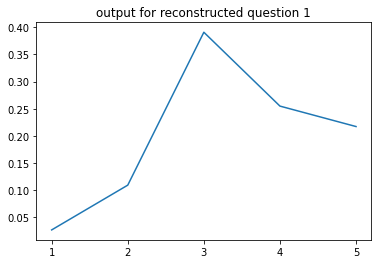

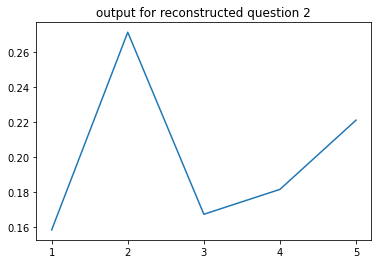

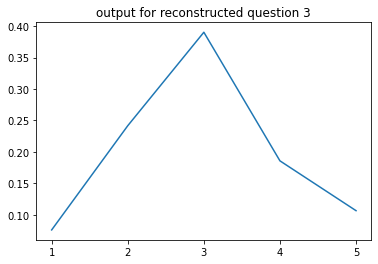

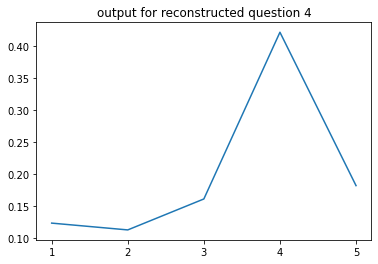

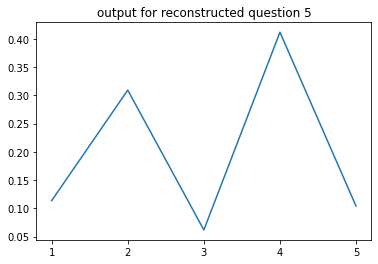

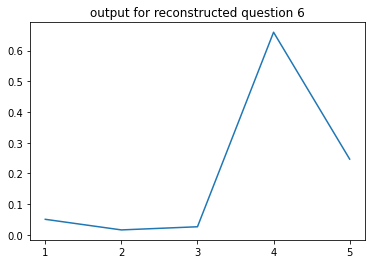

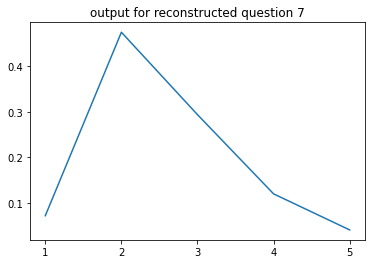

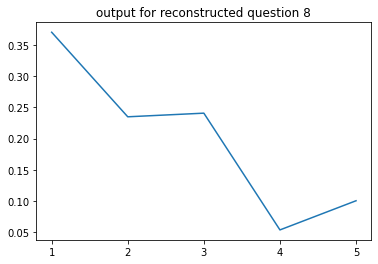

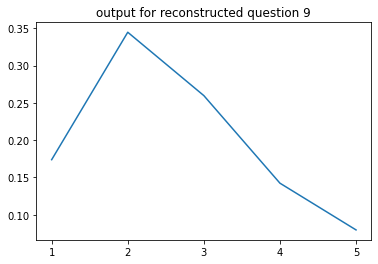

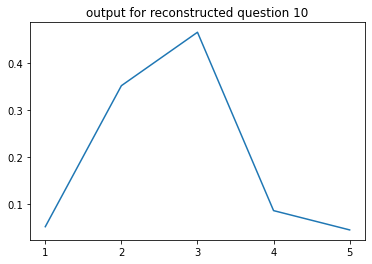

In [ ]:
random_test_sample = np.random.choice(len(res_cnn))    # visualize the output distributions of a random test sample

for question in range(10):

  plt.plot(np.arange(1,6,1),np.array([r[0] for r in res_cnn]).reshape(X_merged_test.shape[0]*len(res_cnn),10,5)[random_test_sample,question])
  plt.xticks(ticks = np.arange(1,6,1),labels = [str(i) for i in range(1,6)])
  plt.title('output for reconstructed question '+str(question+1))
  plt.show()

# bimodal distribution of answer for question 5 given the random sample questionnaire

In [ ]:
y_pred_probs = np.array([r[0] for r in res_cnn]).reshape(X_merged_test.shape[0]*len(res_cnn),10,5)  # results of cross validation
y_true_labels = np.array([r[1] for r in res_cnn]).reshape(X_merged_test.shape[0]*len(res_cnn),10,1)

In [ ]:
from sklearn.metrics import top_k_accuracy_score

def top_k(y_true,y_pred,k):   # top k accuracy per question, handling the error of a missing label in the fold

  '''
  INPUTS:
  y_true = true honest values, shape = (n,10,1)
  y_pred = matrix containing the distributions of the predictions, shape = (n,10,5)
  k = parameter for the top k accuracy score

  OUTPUTS:
  array containing the top k accuracy scores for each question
  '''

  top_k_scores = []

  for i in range(y_pred.shape[1]):

    try :


      y_true_i = y_true[:,i,:]
      y_pred_i = y_pred[:,i,:]

      t = top_k_accuracy_score(y_true_i,y_pred_i,k = k)

      top_k_scores.append(t)

    except:


      missing_labels = [k for k in range(5) if k not in np.ndarray.flatten(y_true[:,i,:])]
      y_true_copy_i = deepcopy(y_true_i)
      y_pred_copy_i = deepcopy(y_pred_i)
      
      for lab in missing_labels:


        y_true_copy_i = np.vstack( (  y_true_copy_i , np.array([lab]).reshape(1,1)  ))
        y_pred_copy_i = np.vstack(( y_pred_copy_i, y_pred_i[np.random.choice( y_pred_i.shape[0]   )]  ))

      t = top_k_accuracy_score(y_true_copy_i,y_pred_copy_i,k = k)
      top_k_scores.append(t)



  return np.array(top_k_scores)




def is_in_top_two(y_true,y_pred,k):     # constructing indicator array for sns confidence intervals

  '''
  INPUTS:
  y_true = true honest values, shape = (n,10,1)
  y_pred = matrix containing the distributions of the predictions, shape = (n,10,5)
  k = parameter for the top k accuracy score

  OUTPUTS:
  result_matrix = indicator matrix ,shape = (n,n_questions) whose element (i,j) tells us if the true label y_pred[i,j]
   was in the top k scores or not

  '''

  result_matrix = np.zeros(shape = y_true.shape)

  for i in range(y_true.shape[0]):

    for q in range(y_true.shape[1]):

      top_k_pred = np.argpartition(y_pred[i,q],-k)[-k:]

      if y_true[i,q] in top_k_pred:

        result_matrix[i,q]+=1

  return result_matrix



pred_cnn_indicator = is_in_top_two(y_true_labels,y_pred_probs,k = 2)
top_2_cnn = top_k(y_true_labels,y_pred_probs,2)
top_1_cnn = top_k(y_true_labels,y_pred_probs,1)

print('top 1 score per question:',top_1_cnn)
print('\n')
print('averaged over questions',top_1_cnn.mean())
print('\n--------------------------------------------------------------------------------\n')
print('top 2 score per question:',top_2_cnn)
print('\n')
print('averaged over questions',top_2_cnn.mean())

top 1 score per question: [0.49411765 0.48809524 0.3452381  0.35714286 0.36904762 0.68604651
 0.39285714 0.3452381  0.44047619 0.48809524]


averaged over questions 0.4406354634877207

--------------------------------------------------------------------------------

top 2 score per question: [0.74117647 0.70238095 0.58333333 0.6547619  0.57142857 0.94186047
 0.60714286 0.54761905 0.66666667 0.69047619]


averaged over questions 0.6706846459514039


#### Reconstruction results comparison

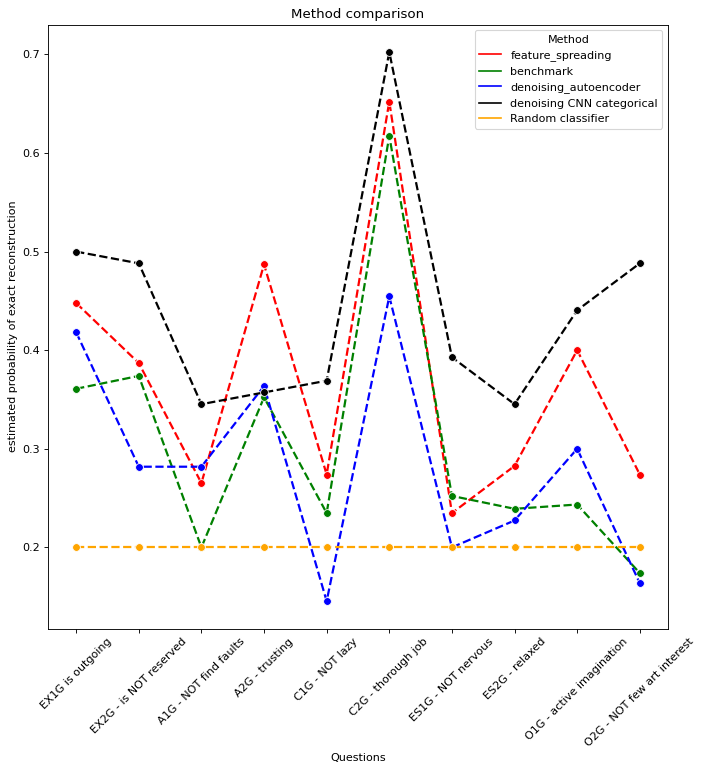

In [ ]:
mean_diff = np.mean(X[0:230],axis = 0)-np.mean(X[230:460],axis = 0)   # mean difference between honest and dishonests for the trivial strategy

predictions_ls,rmse,mae,hard_error,classif = loocv_ls(X_merged,np.array(y),alpha = 0.85,knn = 20,gamma = 0)   #feature spreading loocv evaluation

fs_hard = np.array([predictions_ls[i][0][10:20].round() == predictions_ls[i][1][10:20].round() for i in range(len(predictions_ls))])
bench_hard = np.array((X[230:460]+mean_diff).round() == X[0:230])
da_hard = np.array(acc_per_fold_q)
da_cnn = np.array(cnn_den_hard).reshape(X_merged_test.shape[0]*len(res_cnn),10)


plt.figure(figsize = (10,10),dpi = 80)

df_fs = pd.DataFrame(data = np.vstack([fs_hard,bench_hard,da_hard,da_cnn,0.2*np.ones(da_hard.shape)]),columns = input_variables)#['feature_spreading','benchmark','denoising_autoencoder'] )
df_fs['Method'] = ['feature_spreading']*fs_hard.shape[0]+['benchmark']*bench_hard.shape[0]+\
   ['denoising_autoencoder']*da_hard.shape[0]+ ['denoising CNN categorical']*da_cnn.shape[0]+['Random classifier']*da_hard.shape[0]
visualDf = pd.melt(df_fs, id_vars = ['Method'],value_vars = input_variables)
_ = sns.lineplot(data=visualDf, x="variable", y="value", hue="Method",ci = False,palette = ['red','green','blue','black','orange'],err_style=None,
                 n_boot = 200,alpha = 1,marker = 'o',linestyle = '--',markersize = 7,linewidth = 2)

_.set_xticklabels(input_labels)
_.set_xlabel('Questions')
_.set_ylabel('estimated probability of exact reconstruction')
_.set_title('Method comparison')
_ = plt.xticks(rotation=45)

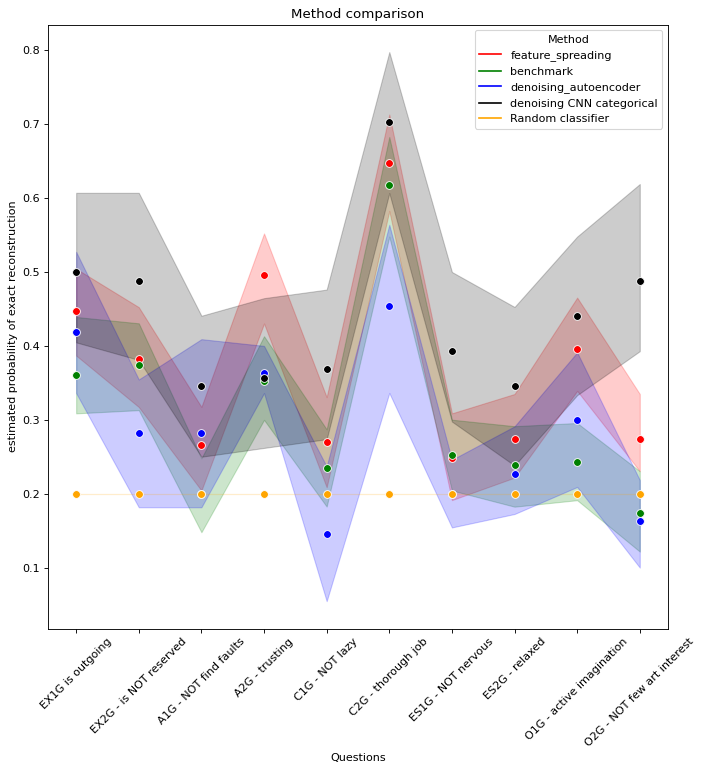

In [ ]:
mean_diff = np.mean(X[0:230],axis = 0)-np.mean(X[230:460],axis = 0)   # mean difference between honest and dishonests for the trivial strategy

predictions_ls,rmse,mae,hard_error,classif = loocv_ls(X_merged,np.array(y),alpha = 0.85,knn = 20,gamma = 0)   #feature spreading loocv evaluation

fs_hard = np.array([predictions_ls[i][0][10:20].round() == predictions_ls[i][1][10:20].round() for i in range(len(predictions_ls))])
bench_hard = np.array((X[230:460]+mean_diff).round() == X[0:230])
da_hard = np.array(acc_per_fold_q)
da_cnn = np.array(cnn_den_hard).reshape(X_merged_test.shape[0]*len(res_cnn),10)


plt.figure(figsize = (10,10),dpi = 80)

df_fs = pd.DataFrame(data = np.vstack([fs_hard,bench_hard,da_hard,da_cnn,0.2*np.ones(da_hard.shape)]),columns = input_variables)
df_fs['Method'] = ['feature_spreading']*fs_hard.shape[0]+['benchmark']*bench_hard.shape[0]+\
   ['denoising_autoencoder']*da_hard.shape[0]+ ['denoising CNN categorical']*da_cnn.shape[0]+['Random classifier']*da_hard.shape[0]
visualDf = pd.melt(df_fs, id_vars = ['Method'],value_vars = input_variables)
_ = sns.lineplot(data=visualDf, x="variable", y="value", hue="Method",ci = False,palette = ['red','green','blue','black','orange'],err_style=None,
                 n_boot = 200,alpha = 1,marker = 'o',linestyle = '',markersize = 7,linewidth = 2)
_ = sns.lineplot(data=visualDf, x="variable", y="value", hue="Method",ci = 95,palette = ['red','green','blue','black','orange'],err_style='band',
                n_boot = 200,alpha = 0,legend = False,marker = 'o',linestyle = '',markersize = 7)
_.set_xticklabels(input_labels)
_.set_xlabel('Questions')
_.set_ylabel('estimated probability of exact reconstruction')
_.set_title('Method comparison')
_ = plt.xticks(rotation=45)

top 1 score per question: [0.49411765 0.48809524 0.3452381  0.35714286 0.36904762 0.68604651
 0.39285714 0.3452381  0.44047619 0.48809524]


averaged over questions 0.4406354634877207

--------------------------------------------------------------------------------

top 2 score per question: [0.74117647 0.70238095 0.58333333 0.6547619  0.57142857 0.94186047
 0.60714286 0.54761905 0.66666667 0.69047619]


averaged over questions 0.6706846459514039


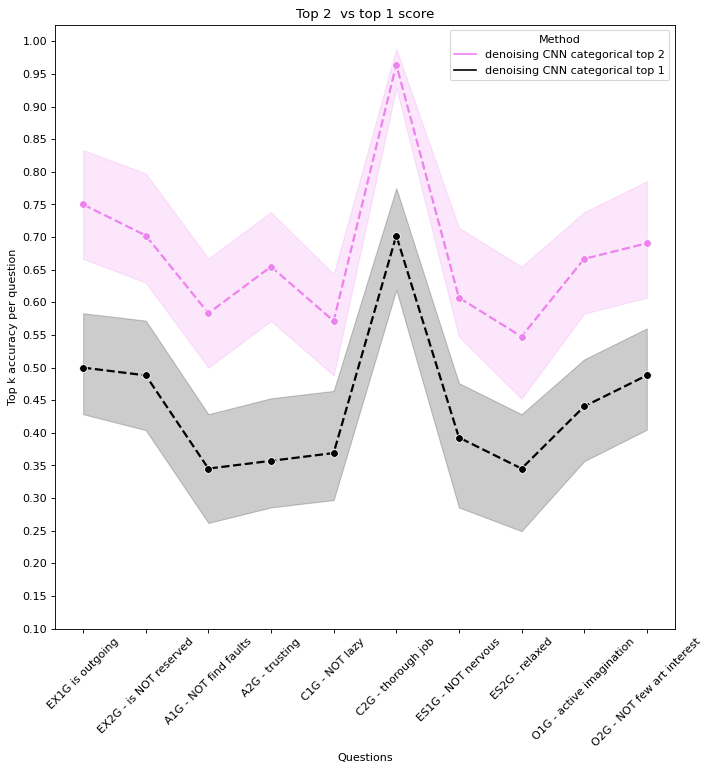

In [ ]:
top_2_cnn = top_k(y_true_labels,y_pred_probs,2)
top_1_cnn = np.array( df_fs.loc[df_fs['Method'] == 'denoising CNN categorical'][input_variables] )

print('top 1 score per question:',top_k(y_true_labels,y_pred_probs,1))
print('\n')
print('averaged over questions',top_k(y_true_labels,y_pred_probs,1).mean())
print('\n--------------------------------------------------------------------------------\n')
print('top 2 score per question:',top_2_cnn)
print('\n')
print('averaged over questions',top_2_cnn.mean())

plt.figure(figsize = (10,10),dpi = 80)

df_fs = pd.DataFrame(data = np.vstack((pred_cnn_indicator.reshape(X_merged_test.shape[0]*len(res_cnn),10) , top_1_cnn)),columns = input_variables)#['feature_spreading','benchmark','denoising_autoencoder'] )
df_fs['Method'] = ['denoising CNN categorical top 2']*pred_cnn_indicator.shape[0]+ ['denoising CNN categorical top 1']*top_1_cnn.shape[0]

visualDf = pd.melt(df_fs, id_vars = ['Method'],value_vars = input_variables)
_ = sns.lineplot(data=visualDf, x="variable", y="value", hue="Method",ci = False, palette = ['violet','black'],err_style=None,
                 n_boot = 200,alpha = 1,marker = 'o',linestyle = '--',markersize = 7,linewidth = 2)
_ = sns.lineplot(data=visualDf, x="variable", y="value", hue="Method",ci = 90,palette = ['violet','black'],err_style='band',
                n_boot = 100,alpha = 0,legend = False,marker = 'o',linestyle = '',markersize = 7)
_.set_xticklabels(input_labels)
_.set_xlabel('Questions')
_.set_ylabel('Top k accuracy per question')
_.set_yticks(np.arange(0.1, 1.05, 0.05))
_.set_title('Top 2  vs top 1 score')
_ = plt.xticks(rotation=45)

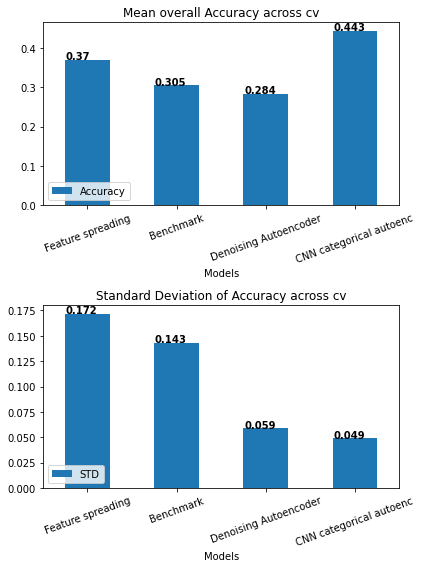

In [ ]:
#df_fs.to_csv('reco_results_cnn_pred.csv')

perf_cnn = np.hstack((np.array([p[0] for p in performances]) , np.array([[p[1]] for p in performances]) ))  # stacking performance across folds and overall across question


df_fs = pd.DataFrame(data = np.vstack([fs_hard,bench_hard,da_hard,perf_cnn[:,0:10],0.2*np.ones(da_hard.shape)]),columns = input_variables)
df_fs['Method'] = ['feature_spreading']*fs_hard.shape[0]+['benchmark']*bench_hard.shape[0]+\
   ['denoising_autoencoder']*da_hard.shape[0]+ ['denoising CNN categorical']*perf_cnn.shape[0]+['Random classifier']*da_hard.shape[0]

models_accuracy = np.array([['Feature spreading','Benchmark','Denoising Autoencoder','CNN categorical autoenc'],\
                            [np.mean(fs_hard),np.mean(bench_hard),np.mean(da_hard),np.mean(da_cnn)],\
                            [np.std(np.mean(fs_hard,axis = 1)),np.std(np.mean(bench_hard,axis = 1)),np.std(np.mean(da_hard,axis = 1)),\
                             np.std(np.mean(perf_cnn[:,0:10],axis = 1)) ]   ]).T


# Plot result comparisons for cross validation discrimination

fig, ax = fig, axs = plt.subplots(2, figsize=(6,8))

# Create dataframe from model_accuracy list
discriminationDf = pd.DataFrame(models_accuracy, columns = ['Models','Accuracy','STD'])
discriminationDf['Accuracy'] = pd.to_numeric(discriminationDf['Accuracy'])
discriminationDf['STD'] = pd.to_numeric(discriminationDf['STD'])


# Plot model accuracies
ax[0] = discriminationDf.plot.bar(x='Models', y='Accuracy', rot=0, ax = ax[0])

# Add accuracy as annotations to bars 
for p in ax[0].patches:
    ax[0].annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005),weight = 'bold')

# Move legend for accuracy plot
ax[0].legend(loc = "lower left")
ax[0].set_title("Mean overall Accuracy across cv")
plt.setp( axs[0].xaxis.get_majorticklabels(), rotation=20 )


# Plot standard deviation of accuracy
ax[1] = discriminationDf.plot.bar(x='Models', y='STD', rot=0, ax= ax[1])

# Add standard deviation as annotations to bars 
for p in ax[1].patches:
    ax[1].annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005),weight = 'bold')

# Move legend for std plot
ax[1].legend(loc = "lower left")
plt.xticks(rotation=20)
ax[1].set_title("Standard Deviation of Accuracy across cv")
plt.tight_layout()

### Support vector regression

In [ ]:
# construct response variables by stacking the condition and the target honest responses
y = np.vstack([X[0:230],X[0:230]]) 
y = np.hstack ( [df['CONDITION_BINARY'].to_numpy().reshape((460,1)) ,y] )  


# test train split the dataset and fit the multioutput SVR

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=300)

svr = SVR(C = 0.01,epsilon=0.1)
model = MultiOutputRegressor(svr)
model.fit(X_train,y_train)

# test prediction
y_hat = model.predict(X_test)

# classification metrics

True_dish = np.sum((y_test[:,0] == 0 ) & (y_hat[:,0].round()==0))
True_hon = np.sum((y_test[:,0] == 1 ) & (y_hat[:,0].round()==1))
False_dish =  np.sum((y_test[:,0] == 1 ) & (y_hat[:,0].round()==0))
False_hon = np.sum((y_test[:,0] == 0 ) & (y_hat[:,0].round()==1))

class_conf_matrix = np.array([[True_hon,False_hon],[False_dish,True_dish]])

# reconstruction metrics

feat_mse = np.mean((y_hat[:,1:11]-y_test[:,1:11])**2,axis=0)    # vector of mse per feature
overall_mse = np.sum(feat_mse)

In [ ]:
def confusion_tensor(v,w,levels = 5):

  res = np.zeros(shape = (v.shape[0],levels,levels))

  for k in range(v.shape[0]):

    for i in range(levels):

      for j in range(levels):

        res[k,i,j] = int(v[k]==i+1 and w[k]==j+1)

  return res



def cv_svr(X,y,iter = 20,test_size = 160 ):
  
  # test train split the dataset and fit the multioutput SVR

  n = X.shape[0]
  D = X.shape[1]
  d = y.shape[1]

  class_conf_matrix = []
  feat_mse = []
  hard_reconstruction_error = []
  conf_tensor = []

  for i in range(iter):

    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = n-test_size)

    svr = SVR(C = 0.01,epsilon=0.1)    #probably cv can be used here to select good hyperparameters
    model = MultiOutputRegressor(svr)
    model.fit(X_train,y_train)

    # test prediction
    y_hat = model.predict(X_test)

    y_hard = y_hat.round()

    # classification metrics

    True_dish = np.sum((y_test[:,0] == 0 ) & (y_hard[:,0]==0))
    True_hon = np.sum((y_test[:,0] == 1 ) & (y_hard[:,0]==1))
    False_dish =  np.sum((y_test[:,0] == 1 ) & (y_hard[:,0]==0))
    False_hon = np.sum((y_test[:,0] == 0 ) & (y_hard[:,0]==1))

    class_conf_matrix.append( np.array([[True_hon,False_hon],[False_dish,True_dish]])/(test_size) )

    # reconstruction metrics

    hard_reconstruction_error.append( np.mean( y_hard[:,1:d]==y_test[:,1:d]  ,axis = 0 )  )

    feat_mse.append( np.mean((y_hat[:,1:d]-y_test[:,1:d])**2,axis=0) )   # vector of mse per feature

    conf_tensor.append( sum([confusion_tensor( y_test[j,1:d], y_hard[j,1:d]  ) for j in range(test_size) ])/(10*test_size)  )


  return np.mean(np.array(conf_tensor),axis = 0),np.array(class_conf_matrix),np.array(feat_mse),np.array(hard_reconstruction_error)

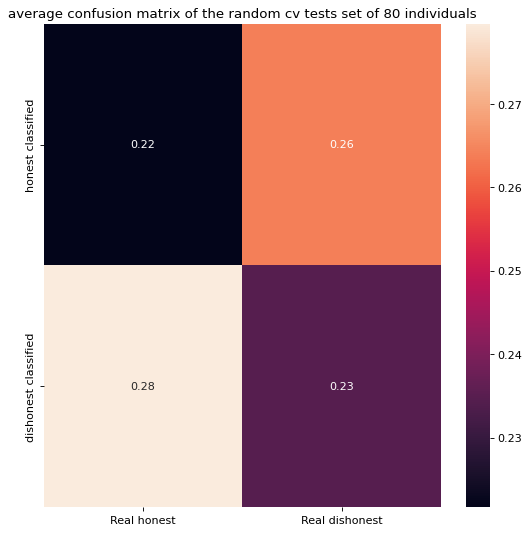


------------------------------------------------------
random cv test classification accuracy: 0.45624999999999993

---------------------------------------------------------
cv mean mse per feature over 80 people
   EX1G  EX2G  A1G  A2G  C1G  C2G  ES1G  ES2G  O1G  O2G
0  0.93  1.13 1.21 1.01 1.58 0.60  1.30  1.39 1.30 1.80

---------------------------------------------------------
cv mean hard reconstruction accuracy per feature over 80 people
   EX1G  EX2G  A1G  A2G  C1G  C2G  ES1G  ES2G  O1G  O2G
0  0.46  0.48 0.27 0.52 0.16 0.60  0.22  0.21 0.37 0.28



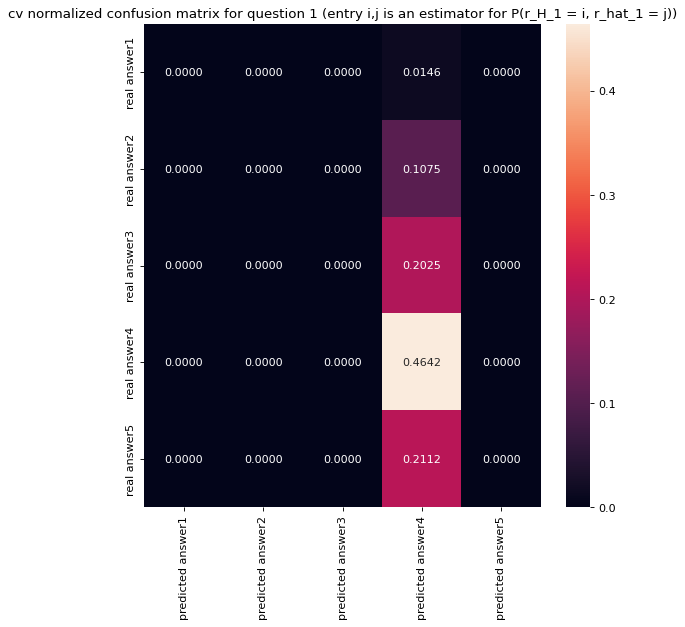

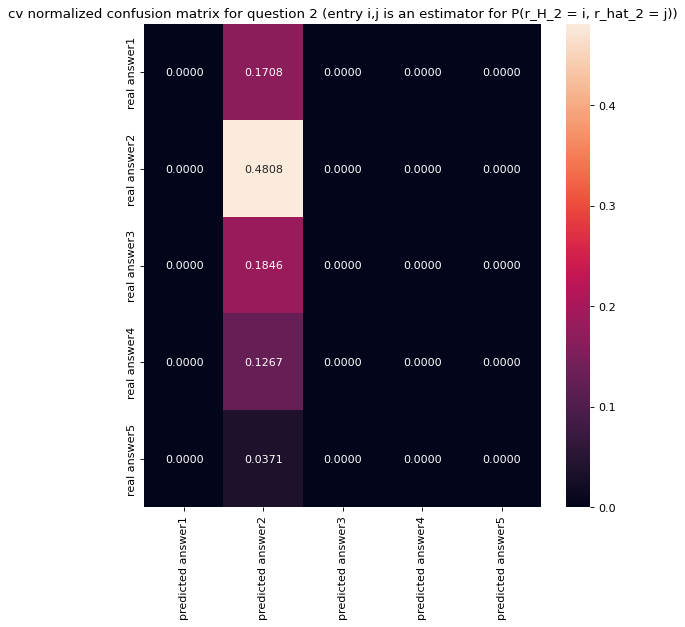

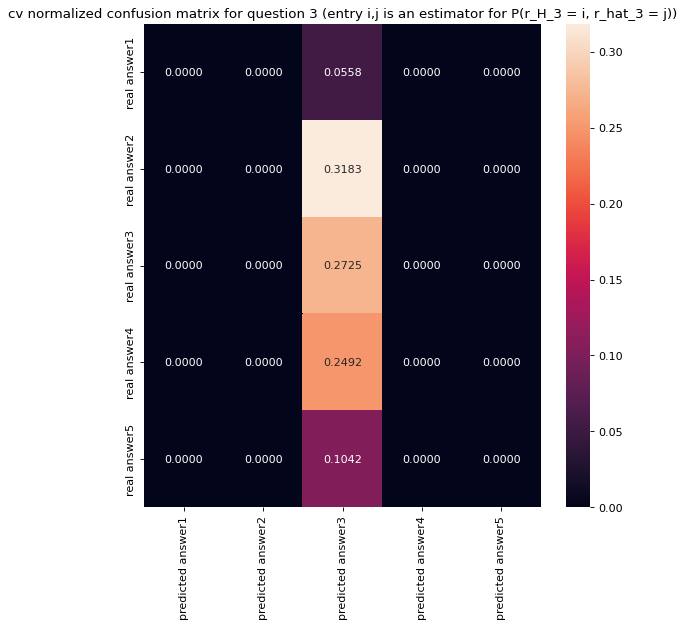

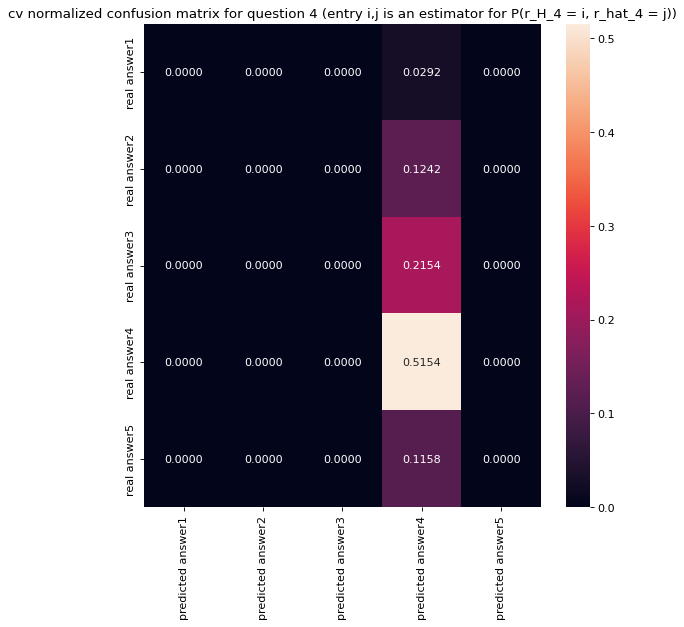

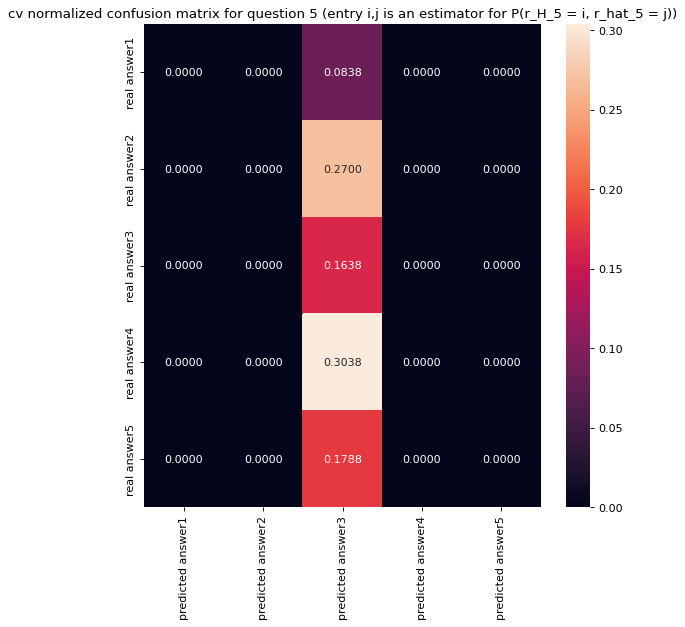

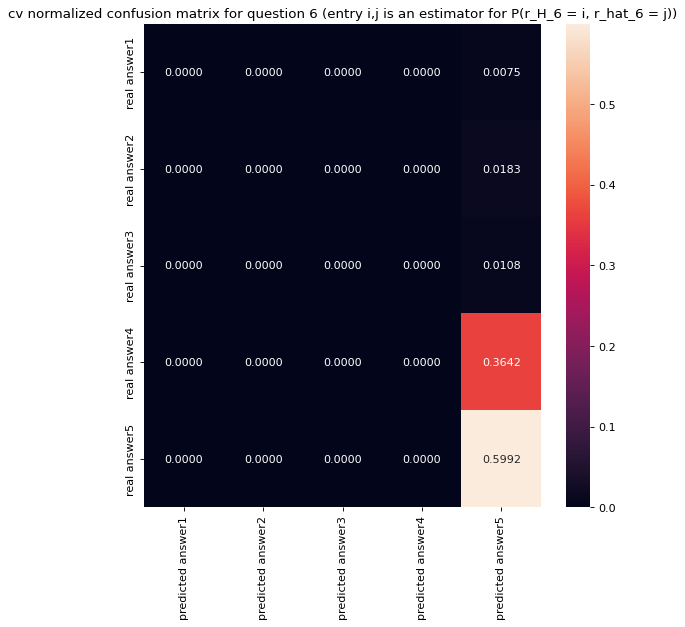

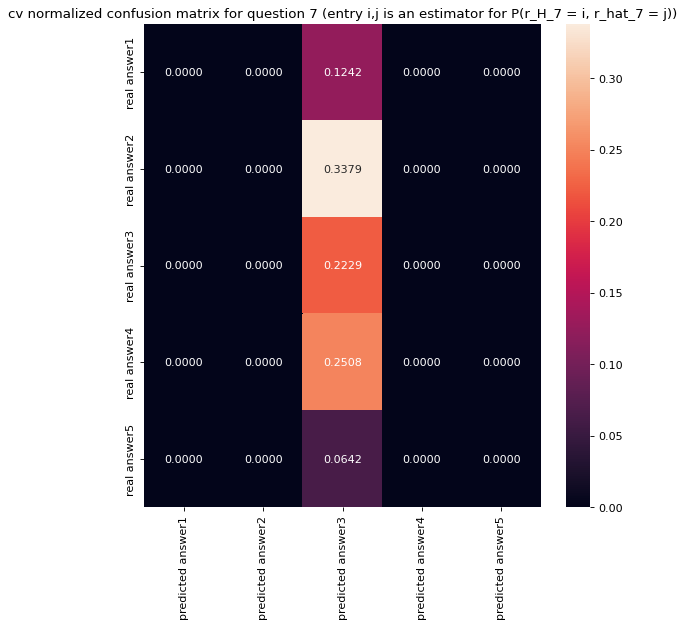

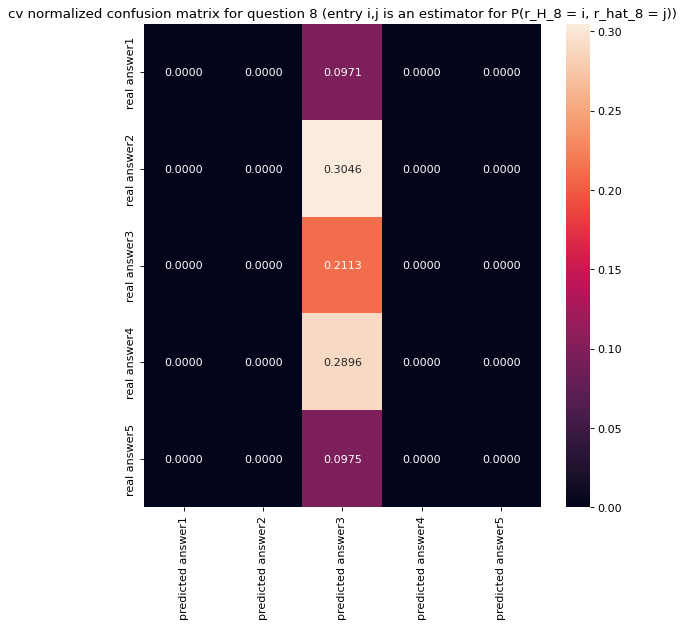

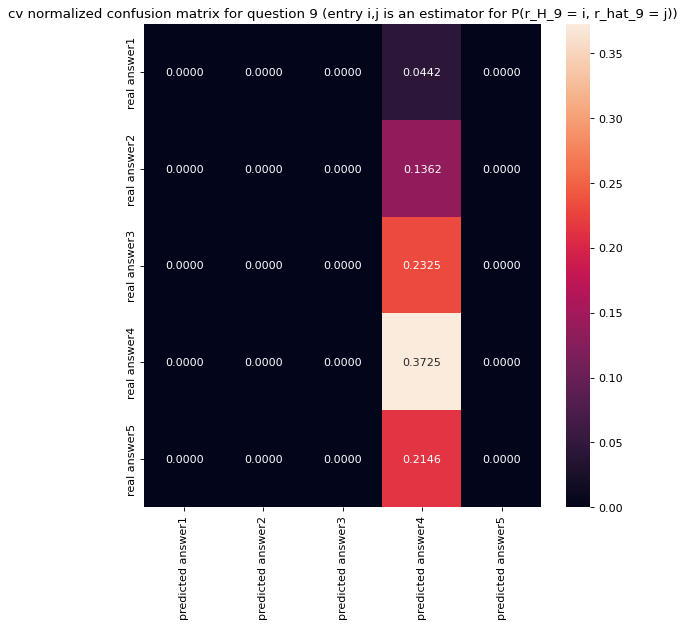

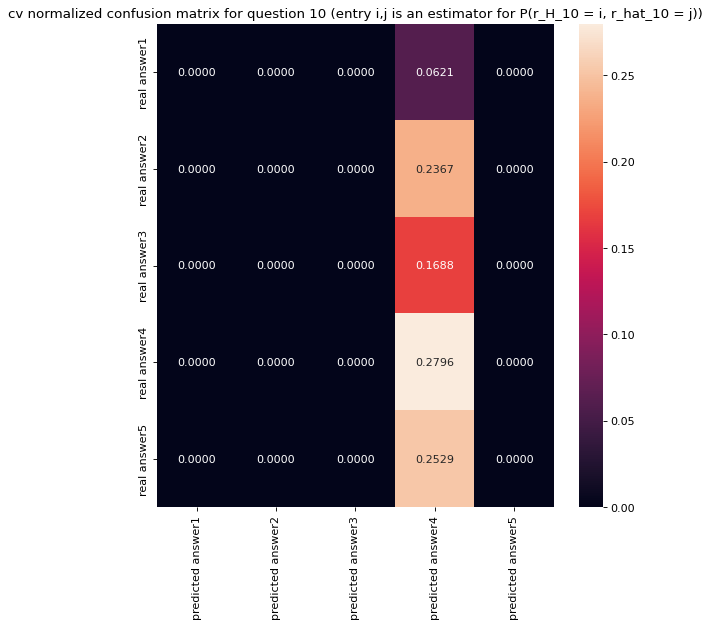

In [ ]:
test_size = 80
cv_conf_tens_svr,conf_svr,mse_svr,hard_reconstruction_svr = cv_svr(X,y,iter = 30,test_size = test_size )

mean_svr_confusion = np.mean(conf_svr,axis = 0)
cv_conf_tens_svr_qcond = 10*cv_conf_tens_svr        #question conditioned confusion tensor, is it the same as multyplying by 10    



pd.options.display.float_format = '{:.2f}'.format
fig = plt.figure(figsize=(8,8), dpi = 80)
hm = sns.heatmap(  pd.DataFrame(mean_svr_confusion,columns=['Real honest','Real dishonest'],
                         index = ['honest classified','dishonest classified'] ) ,
                 annot = True,fmt = '.2f' )
plt.title('average confusion matrix of the random cv tests set of '+str(test_size)+' individuals')
plt.show()

print('\n------------------------------------------------------')
print('random cv test classification accuracy:', np.trace(mean_svr_confusion))


# mse 

mean_svr_mse = np.mean(mse_svr,axis = 0)
mean_hard_rec = np.mean(hard_reconstruction_svr,axis=0)

print('\n---------------------------------------------------------')
print('cv mean mse per feature over '+str(test_size)+' people')
print(pd.DataFrame([mean_svr_mse],columns = ['EX1G','EX2G','A1G','A2G','C1G','C2G','ES1G','ES2G','O1G','O2G'] ) )

print('\n---------------------------------------------------------')
print('cv mean hard reconstruction accuracy per feature over '+str(test_size)+' people')
print(pd.DataFrame([mean_hard_rec],columns = ['EX1G','EX2G','A1G','A2G','C1G','C2G','ES1G','ES2G','O1G','O2G'] ))
print('\n==========================================================')


for question in range(1,11):

  pd.options.display.float_format = '{:.2f}'.format
  fig = plt.figure(figsize=(8,8), dpi = 80)
  hm = sns.heatmap(  pd.DataFrame(cv_conf_tens_svr_qcond[question-1],columns=['predicted answer'+str(i) for i in range(1,6)],
                           index = ['real answer'+str(i) for i in range(1,6)] ) ,
                   annot = True,fmt = '.4f' )
  plt.title('cv normalized confusion matrix for question '+ str(question)+ ' (entry i,j is an estimator for P(r_H_'+str(question)+' = i, r_hat_'+str(question)+' = j))')
  plt.show()